# **ITI110 Deep Learning Project**

Name: Adison Goh (22A191W)

With ongoing digital transformation efforts across various industries, many companies make use of electronic service tickets to keep track of requests. With a large volume of tickets, triaging and assignment to the appropriate team for resolution can be a resource- and time-intensive task. Delays in ticket resolution can impact the service-level agreement and customer satisfaction to great extent. Hence, the goal of this project is to automate the classification of e-service tickets to an appropriate category. 

## 0. Data Pre-Processing

In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
import random

from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Input, concatenate
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, GlobalAveragePooling2D, GlobalMaxPooling2D
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GlobalAveragePooling1D
from tensorflow.keras.models import Model

from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


In [ ]:
# Connect to your Google Drive here
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Folder path
proj_folder = '/content/drive/MyDrive/NYP SDAAI/ITI110 Deep Learning Project'
# proj_folder = '/content/drive/MyDrive/ITI110'

tickets_path = proj_folder + "/dataset/all_tickets_processed_improved_v3.csv"
# tickets_path = proj_folder + '/all_tickets_processed_improved_v3.csv'


### i. Text Exploration

The dataset consists of 47837 rows and 2 columns.

The 'Document' column contains the full text of the e-service ticket that was  logged.

The 'Topic_group' columns contains the classification or topic of the ticket. <br>There are 8 possible topics - 'Hardware', 'Access', 'Storage', 'Internal Project', 'HR Support', 'Administrative rights', 'Purchase', 'Miscellaneous'.

In [ ]:
# Read the CSV into a pandas dataframe
tickets_df = pd.read_csv(tickets_path)

print(tickets_df.shape)
tickets_df.head()

(47837, 2)


,Document,Topic_group
0,connection with icon icon dear please setup ic...,Hardware
1,work experience user work experience user hi w...,Access
2,requesting for meeting requesting meeting hi p...,Hardware
3,reset passwords for external accounts re expir...,Access
4,mail verification warning hi has got attached ...,Miscellaneous


In [ ]:
# shuffle the DataFrame rows
tickets_df = tickets_df.sample(frac=1, random_state=28)

tickets_df.head()

,Document,Topic_group
40715,federation service seems to have changed sent ...,Hardware
2292,mail dear please create possibility mails whic...,Miscellaneous
22204,creation of a mail called am team wednesday pm...,Miscellaneous
43308,password reset for tine hello there let ask me...,Access
10378,access to confluence wednesday pm confluence d...,Access


Unique categories: ['Hardware' 'Miscellaneous' 'Access' 'Storage' 'Internal Project'
 'HR Support' 'Administrative rights' 'Purchase'] 

Hardware                 13617
HR Support               10915
Access                    7125
Miscellaneous             7060
Storage                   2777
Purchase                  2464
Internal Project          2119
Administrative rights     1760
Name: Topic_group, dtype: int64 



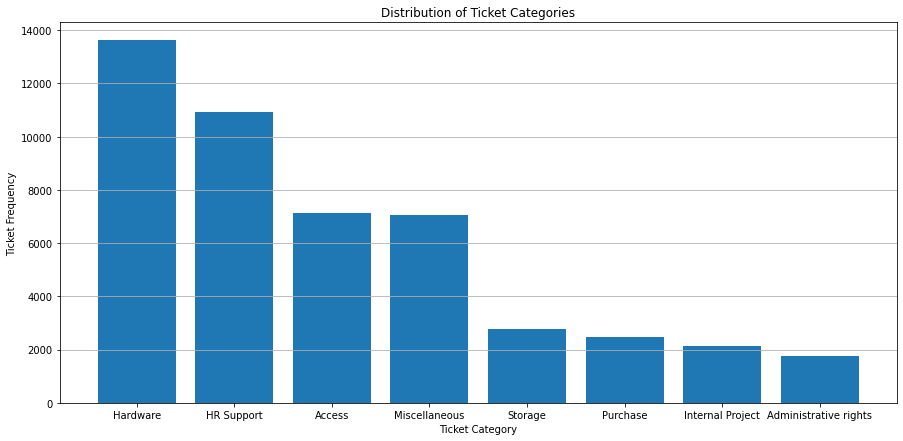

In [ ]:
# Find the unique values in the "Topic_group" column
unique_categories = tickets_df['Topic_group'].unique()
print("Unique categories:", unique_categories, "\n")

# Plot a bar plot showing the distribution of categories
category_counts = tickets_df['Topic_group'].value_counts()
print(category_counts, "\n")

fig, ax = plt.subplots(figsize=(15,7))
ax.bar(category_counts.index, category_counts.values)
ax.set_xlabel("Ticket Category")
ax.set_ylabel("Ticket Frequency")
ax.set_title("Distribution of Ticket Categories")
ax.grid(visible=True, axis = 'y')
plt.show()

To balance out the dataset, downsample the majority classes (Hardware, HR Support, Access, Miscellaneous) such that there are only 5000 rows each.

In [ ]:
# Get the indices for each category
hardware_indices = tickets_df[tickets_df['Topic_group'] == 'Hardware'].index
hr_support_indices = tickets_df[tickets_df['Topic_group'] == 'HR Support'].index
access_indices = tickets_df[tickets_df['Topic_group'] == 'Access'].index
miscellaneous_indices = tickets_df[tickets_df['Topic_group'] == 'Miscellaneous'].index

# Create a list of indices to drop
indices_to_drop = random.sample(list(hardware_indices), len(hardware_indices) - 5000) + \
                  random.sample(list(hr_support_indices), len(hr_support_indices) - 5000) + \
                  random.sample(list(access_indices), len(access_indices) - 5000) + \
                  random.sample(list(miscellaneous_indices), len(miscellaneous_indices) - 5000)

# Drop the rows
tickets_df_downsample = tickets_df.drop(indices_to_drop)

# Check the number of rows for each category
print(tickets_df_downsample.shape)
print("Hardware count:", tickets_df_downsample[tickets_df_downsample['Topic_group'] == 'Hardware'].shape[0])
print("HR Support count:", tickets_df_downsample[tickets_df_downsample['Topic_group'] == 'HR Support'].shape[0])
print("Access count:", tickets_df_downsample[tickets_df_downsample['Topic_group'] == 'Access'].shape[0])
print("Miscellaneous count:", tickets_df_downsample[tickets_df_downsample['Topic_group'] == 'Miscellaneous'].shape[0])

tickets_df_downsample.head()

(29120, 2)
Hardware count: 5000
HR Support count: 5000
Access count: 5000
Miscellaneous count: 5000


,Document,Topic_group
2292,mail dear please create possibility mails whic...,Miscellaneous
10378,access to confluence wednesday pm confluence d...,Access
12436,change july pm change hello please update than...,Miscellaneous
39553,unable to access folder sent friday july re re...,Storage
22450,people management structure thursday pm re str...,Hardware


Unique categories: ['Miscellaneous' 'Access' 'Storage' 'Hardware' 'Internal Project'
 'HR Support' 'Administrative rights' 'Purchase'] 

Miscellaneous            5000
Access                   5000
Hardware                 5000
HR Support               5000
Storage                  2777
Purchase                 2464
Internal Project         2119
Administrative rights    1760
Name: Topic_group, dtype: int64 



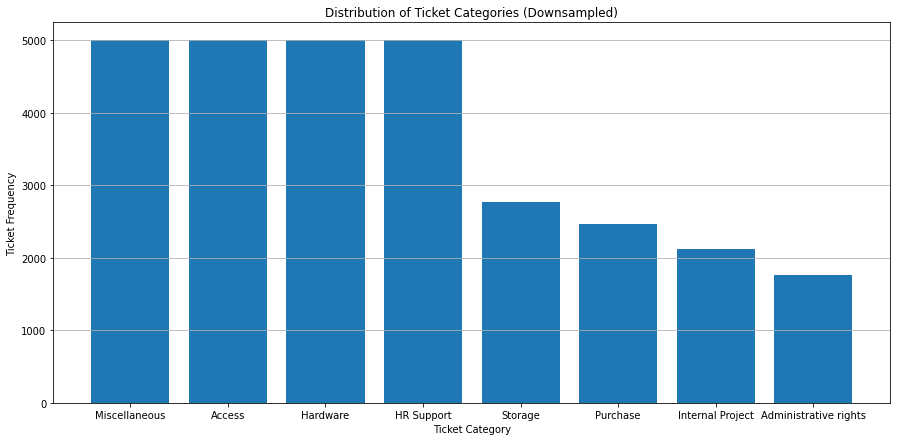

In [ ]:
# Find the unique values in the "Topic_group" column
unique_categories = tickets_df_downsample['Topic_group'].unique()
print("Unique categories:", unique_categories, "\n")

# Plot a bar plot showing the distribution of categories
category_counts = tickets_df_downsample['Topic_group'].value_counts()
print(category_counts, "\n")

fig, ax = plt.subplots(figsize=(15,7))
ax.bar(category_counts.index, category_counts.values)
ax.set_xlabel("Ticket Category")
ax.set_ylabel("Ticket Frequency")
ax.set_title("Distribution of Ticket Categories (Downsampled)")
ax.grid(visible=True, axis = 'y')
plt.show()

### ii. Text Vectorisation & Splitting to Train-Validation-Test Data

In [ ]:
# Split the data into training/validation (95%) and testing (5%) sets
testing_samples = int(len(tickets_df_downsample) * 0.05)
tickets_df_test = tickets_df_downsample[:testing_samples]
tickets_df_train_val = tickets_df_downsample[testing_samples:]

# Split the rest of the data into training (80%) & validation (20%) sets
training_samples = int(len(tickets_df_train_val) * 0.8)
tickets_df_train = tickets_df_train_val[:training_samples]
tickets_df_val = tickets_df_train_val[training_samples:]

print("Training: ", tickets_df_train.shape)
print("Validation: ", tickets_df_val.shape)
print("Testing: ", tickets_df_test.shape)

Training:  (22131, 2)
Validation:  (5533, 2)
Testing:  (1456, 2)


In [ ]:
# Vocabulary size and number of words in a sequence.
VOCAB_SIZE = 10000
MAX_SEQUENCE_LENGTH = 200
# Max length: if < 200, pad with zeros. if longer, truncate

# Use the text vectorization layer to normalize, split, and map strings to integers.
# Set maximum_sequence length as all samples are not of the same length.
vectorize_layer = keras.layers.TextVectorization(
    max_tokens=10000, 
    standardize='lower_and_strip_punctuation',
    split='whitespace',
    output_mode='int',
    output_sequence_length=200
)

In [ ]:
# Call adapt on the Training dataset to build the vocabulary.
vectorize_layer.adapt(tickets_df_train['Document'].values)

In [ ]:
VOCAB_SIZE = len(vectorize_layer.get_vocabulary())
print(VOCAB_SIZE)

9690


In [ ]:
vectorize_layer.get_vocabulary()

['',
 '[UNK]',
 'please',
 'pm',
 'hi',
 'regards',
 'thank',
 'for',
 'hello',
 're',
 'thanks',
 'you',
 'kind',
 'sent',
 'access',
 'dear',
 'tuesday',
 'help',
 'wednesday',
 'thursday',
 'by',
 'with',
 'best',
 'friday',
 'july',
 'to',
 'can',
 'have',
 'change',
 'has',
 'log',
 'add',
 'code',
 'error',
 'issue',
 'ext',
 'be',
 'new',
 'engineer',
 'po',
 'name',
 'purchase',
 'let',
 'attached',
 'order',
 'october',
 'information',
 'details',
 'also',
 'date',
 'november',
 'form',
 'update',
 'create',
 'analyst',
 'senior',
 'we',
 'your',
 'mailbox',
 'upgrade',
 'user',
 'issues',
 'confluence',
 'administrator',
 'card',
 'client',
 'december',
 'number',
 'report',
 'leaver',
 'receive',
 'provide',
 'leave',
 'march',
 'officer',
 'site',
 'how',
 'high',
 'request',
 'could',
 'work',
 'if',
 'assigned',
 'manager',
 'or',
 'february',
 'cannot',
 'location',
 'take',
 'needed',
 'oracle',
 'working',
 'days',
 'more',
 'other',
 'rights',
 'find',
 'folder',
 'us

In [ ]:
# Vectorize the ticket text ('Document') in the training, validation & testing dataset
train_text = vectorize_layer(tickets_df_train['Document'].values)
val_text = vectorize_layer(tickets_df_val['Document'].values)
test_text = vectorize_layer(tickets_df_test['Document'].values)

print("Training: ", train_text.shape)
print("Validation: ", val_text.shape)
print("Testing: ", test_text.shape)

train_text

Training:  (22131, 200)
Validation:  (5533, 200)
Testing:  (1456, 200)


<tf.Tensor: shape=(22131, 200), dtype=int64, numpy=
array([[1102, 1796,   37, ...,    0,    0,    0],
       [ 103,  112,   28, ...,    0,    0,    0],
       [1812,  463,  592, ...,    0,    0,    0],
       ...,
       [ 211,   25,   25, ...,    0,    0,    0],
       [ 227,   23,   73, ...,    0,    0,    0],
       [ 326,   78,  549, ...,    0,    0,    0]])>

In [ ]:
# One-hot encode the labels ('Topic_group')
train_labels = pd.get_dummies(tickets_df_train['Topic_group']).to_numpy()
val_labels = pd.get_dummies(tickets_df_val['Topic_group']).to_numpy()
test_labels = pd.get_dummies(tickets_df_test['Topic_group']).to_numpy()

print("Training: ", train_labels.shape)
print("Validation: ", val_labels.shape)
print("Testing: ", test_labels.shape)

train_labels

Training:  (22131, 8)
Validation:  (5533, 8)
Testing:  (1456, 8)


array([[0, 0, 0, ..., 1, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 1, 0, 0],
       [0, 0, 1, ..., 0, 0, 0]], dtype=uint8)

### iii. Helper Functions

In [ ]:
# Use the model_checkpoint_callback to save our best checkpoint in terms of validation accuracy.

def save_best_model(checkpoint_path): 

    model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_path,
        save_weights_only=True,
        monitor='val_accuracy',
        mode='max',
        save_best_only=True)
    
    return model_checkpoint_callback
    

# This function is used to display the history the train/test accuracy/loss of the Keras training.

def display_training_loss_and_accuracy(history):
    
    plt.figure(figsize=(20,4))
    
    # summarize history for accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    
    # summarize history for loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper right')
    plt.show()    


# Define function to display confusion matrix & classification report

def display_classification_confusion_matrix(keras_model, x_train, y_train, x_test, y_test, labels):

    x_train = np.array(x_train)
    y_train = np.array(y_train)
    
    actual_y_train = keras_model.predict(x_train)
    actual_y_test = keras_model.predict(x_test)

    plt.figure(figsize=(20,6))  

    labels = np.array(labels)

    # Convert the target labels into the categorical index
    #
    y_train_index = y_train.argmax(axis=1)
    actual_y_train_index = actual_y_train.argmax(axis=1)
    y_test_index = y_test.argmax(axis=1)
    actual_y_test_index = actual_y_test.argmax(axis=1)

    
    # Print the first Confusion Matrix for the training data
    #
    cm = confusion_matrix(y_train_index, actual_y_train_index)

    cm_df = pd.DataFrame(cm, labels, labels)          
    plt.subplot(1, 2, 1)
    plt.title('Confusion Matrix (Train Data)')
    sns.heatmap(cm_df, annot=True)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')        
    
    # Print the second Confusion Matrix for the test data
    #    
    cm = confusion_matrix(y_test_index, actual_y_test_index)

    
    cm_df = pd.DataFrame(cm, labels, labels)          
    plt.subplot(1, 2, 2)
    plt.title('Confusion Matrix (Test Data)')
    sns.heatmap(cm_df, annot=True)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')        
    
    plt.show()

    # Finally display the classification reports
    #
    print ("Train Data:")
    print ("--------------------------------------------------------")
    print(classification_report(actual_y_train_index, y_train_index, target_names=labels))
    print ("")
    print ("Test Data:")
    print ("--------------------------------------------------------")
    print(classification_report(actual_y_test_index, y_test_index, target_names=labels))

## 1. Basic RNN

### 1A. Build Simple RNN model
- SimpleRNN (64, tanh) 

In [ ]:
EMBEDDING_DIM=128

inputs = keras.Input(shape=(MAX_SEQUENCE_LENGTH,))

embedded = keras.layers.Embedding(input_dim=VOCAB_SIZE, 
                                  output_dim=EMBEDDING_DIM, 
                                  mask_zero=True)(inputs)

# RNN Example:
x = keras.layers.SimpleRNN(64)(embedded) # default activation function is tanh
outputs = keras.layers.Dense(8, activation='softmax')(x)   # 8 categories

model_RNN = keras.Model(inputs, outputs)

model_RNN.compile(optimizer=keras.optimizers.Adam(1e-4),
              loss=keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

model_RNN.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 200)]             0         
                                                                 
 embedding_1 (Embedding)     (None, 200, 128)          1245568   
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 64)                12352     
                                                                 
 dense_1 (Dense)             (None, 8)                 520       
                                                                 
Total params: 1,258,440
Trainable params: 1,258,440
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history_spec_RNN = model_RNN.fit(
    train_text, 
    train_labels,
    validation_data=(val_text, val_labels),
    epochs=5, 
    batch_size=32,
    callbacks=[save_best_model('best_checkpoint_1A_bilstm')])

Epoch 1/5
692/692 [==============================] - 277s 396ms/step - loss: 1.7257 - accuracy: 0.3940 - val_loss: 1.3795 - val_accuracy: 0.5662
Epoch 2/5
692/692 [==============================] - 229s 330ms/step - loss: 1.1893 - accuracy: 0.6327 - val_loss: 1.1095 - val_accuracy: 0.6613
Epoch 3/5
692/692 [==============================] - 229s 331ms/step - loss: 1.0047 - accuracy: 0.6900 - val_loss: 1.0221 - val_accuracy: 0.6738
Epoch 4/5
692/692 [==============================] - 225s 325ms/step - loss: 0.8394 - accuracy: 0.7543 - val_loss: 0.9001 - val_accuracy: 0.7408
Epoch 5/5
692/692 [==============================] - 226s 327ms/step - loss: 0.7776 - accuracy: 0.7809 - val_loss: 0.8646 - val_accuracy: 0.7459


46/46 [==============================] - 1s 23ms/step - loss: 0.8820 - accuracy: 0.7424


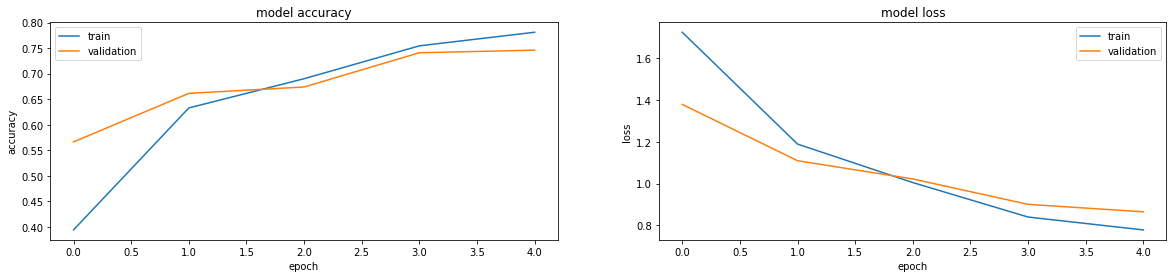

46/46 [==============================] - 2s 35ms/step


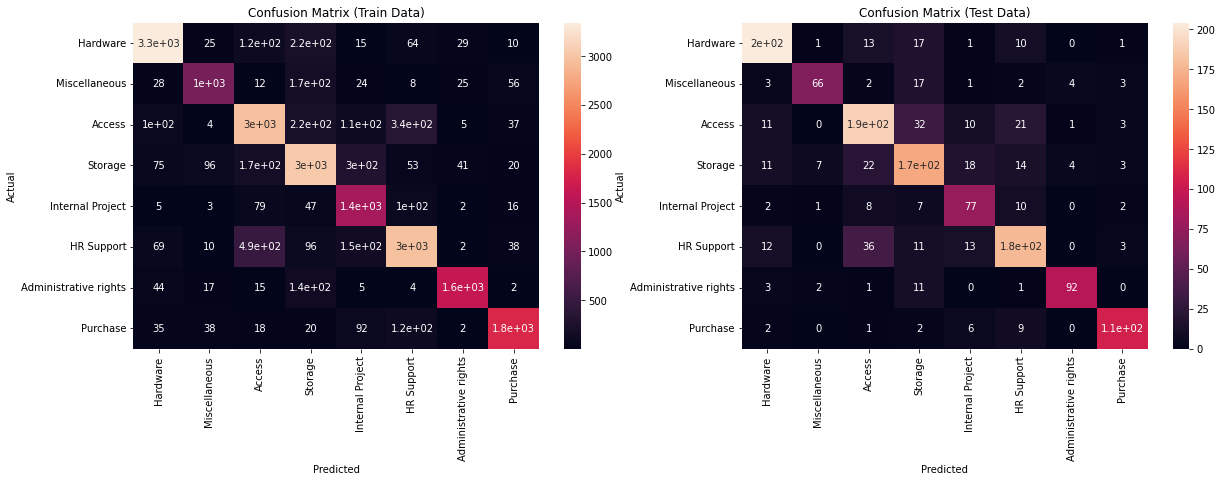

Train Data:
--------------------------------------------------------
                       precision    recall  f1-score   support

             Hardware       0.88      0.90      0.89      3698
        Miscellaneous       0.76      0.84      0.80      1202
               Access       0.78      0.77      0.78      3855
              Storage       0.80      0.77      0.79      3942
     Internal Project       0.84      0.67      0.74      2063
           HR Support       0.78      0.81      0.79      3655
Administrative rights       0.88      0.94      0.91      1727
             Purchase       0.85      0.91      0.88      1989

             accuracy                           0.82     22131
            macro avg       0.82      0.83      0.82     22131
         weighted avg       0.82      0.82      0.82     22131


Test Data:
--------------------------------------------------------
                       precision    recall  f1-score   support

             Hardware       0.83      0

In [ ]:
model_RNN.load_weights("best_checkpoint_1A_bilstm")

# Evaluate on test data
model_RNN.evaluate(x=test_text, y=test_labels)

# Display Training History
display_training_loss_and_accuracy(history_spec_RNN)

# Display confusion matrix & classification report
display_classification_confusion_matrix(model_RNN, train_text, train_labels, test_text, test_labels, unique_categories)

Accuracy is fair as the model may be too simple.
Variance is relatively low. 

More training / epochs as well as adding more weights/layers to may be explored in order to improve the accuracy of the model.

### 1B. Build RNN model with Dense layer
- SimpleRNN (64, tanh) 
- Dense (32, relu)

In [ ]:
EMBEDDING_DIM=128

inputs = keras.Input(shape=(MAX_SEQUENCE_LENGTH,))

embedded = keras.layers.Embedding(input_dim=VOCAB_SIZE, 
                                  output_dim=EMBEDDING_DIM, 
                                  mask_zero=True)(inputs)

# RNN Example:
x = keras.layers.SimpleRNN(64)(embedded)
x = keras.layers.Dense(32, activation='relu')(x)
outputs = keras.layers.Dense(8, activation='softmax')(x)   # 8 categories

model_RNN = keras.Model(inputs, outputs)

model_RNN.compile(optimizer=keras.optimizers.Adam(1e-4),
              loss=keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

model_RNN.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 200)]             0         
                                                                 
 embedding (Embedding)       (None, 200, 128)          1227776   
                                                                 
 simple_rnn (SimpleRNN)      (None, 64)                12352     
                                                                 
 dense (Dense)               (None, 32)                2080      
                                                                 
 dense_1 (Dense)             (None, 8)                 264       
                                                                 
Total params: 1,242,472
Trainable params: 1,242,472
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history_spec_RNN = model_RNN.fit(
    train_text, 
    train_labels,
    validation_data=(val_text, val_labels),
    epochs=5, # 2+5 (total 7 epochs)
    batch_size=32,
    callbacks=[save_best_model('best_checkpoint_1B_bilstm')])

Epoch 1/5
692/692 [==============================] - 263s 380ms/step - loss: 0.9647 - accuracy: 0.6994 - val_loss: 0.9391 - val_accuracy: 0.7110
Epoch 2/5
692/692 [==============================] - 244s 352ms/step - loss: 0.7852 - accuracy: 0.7635 - val_loss: 0.8283 - val_accuracy: 0.7520
Epoch 3/5
692/692 [==============================] - 232s 336ms/step - loss: 0.6465 - accuracy: 0.8081 - val_loss: 0.7754 - val_accuracy: 0.7683
Epoch 4/5
692/692 [==============================] - 214s 309ms/step - loss: 0.5929 - accuracy: 0.8281 - val_loss: 0.7767 - val_accuracy: 0.7659
Epoch 5/5
692/692 [==============================] - 225s 325ms/step - loss: 0.5027 - accuracy: 0.8537 - val_loss: 0.7328 - val_accuracy: 0.7759


46/46 [==============================] - 1s 25ms/step - loss: 0.6991 - accuracy: 0.7843


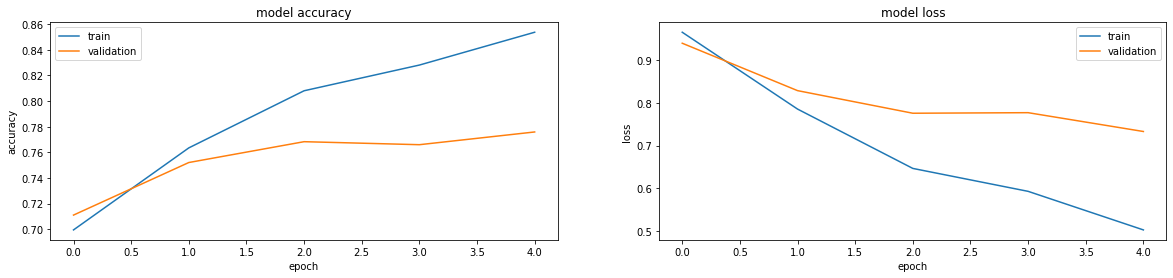

46/46 [==============================] - 1s 22ms/step


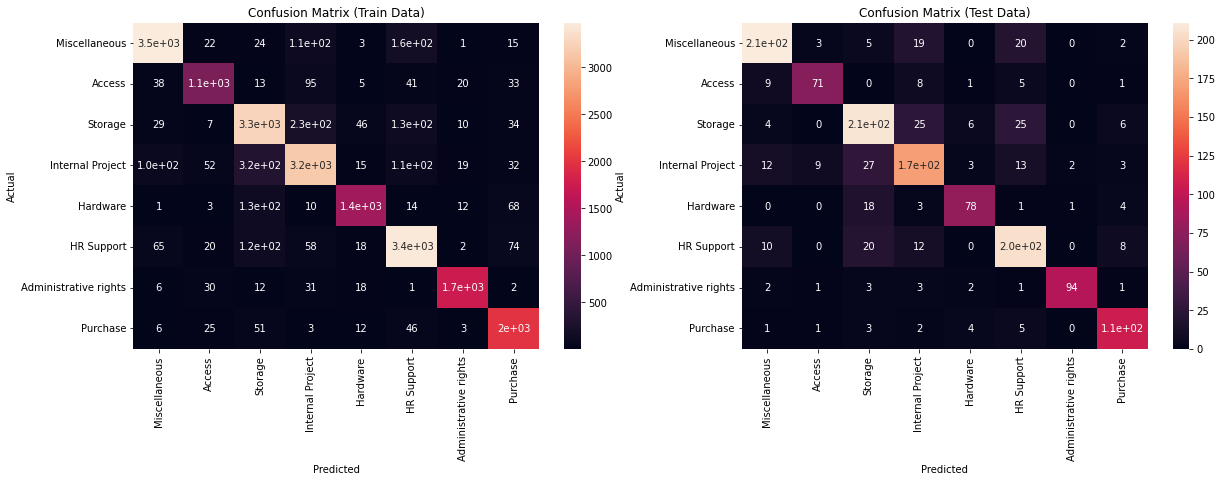

Train Data:
--------------------------------------------------------
                       precision    recall  f1-score   support

        Miscellaneous       0.91      0.93      0.92      3725
               Access       0.82      0.87      0.84      1249
              Storage       0.87      0.83      0.85      3934
     Internal Project       0.83      0.86      0.84      3702
             Hardware       0.86      0.92      0.89      1509
           HR Support       0.90      0.87      0.89      3948
Administrative rights       0.95      0.96      0.95      1816
             Purchase       0.93      0.89      0.91      2248

             accuracy                           0.88     22131
            macro avg       0.88      0.89      0.89     22131
         weighted avg       0.88      0.88      0.88     22131


Test Data:
--------------------------------------------------------
                       precision    recall  f1-score   support

        Miscellaneous       0.81      0

In [ ]:
model_RNN.load_weights("best_checkpoint_1B_bilstm")

# Evaluate on test data
model_RNN.evaluate(x=test_text, y=test_labels)

# Display Training History
display_training_loss_and_accuracy(history_spec_RNN)

# Display confusion matrix & classification report
display_classification_confusion_matrix(model_RNN, train_text, train_labels, test_text, test_labels, unique_categories)

The testing accuracy of the RNN model was 78.43%. This test accuracy will be used as a baseline for subsequent models.

While the training & validation losses were still downtrending after 7 epochs, the rate of improvement in the validation accuracy is much lower than that of the training accuracy and variance of the model was increasing sizably especially after the fourth epoch. Hence, running more epochs will likely lead to overfitting.

For the next model, attempt to improve on the accuracy by using a more complex model with greater number of weights. To reduce risk of overfitting, fewer epochs will be applied.

### 1C. Build RNN model with Dense layer
- SimpleRNN (64, tanh) 
- Dense (128, relu)

In [ ]:
EMBEDDING_DIM=128

inputs = keras.Input(shape=(MAX_SEQUENCE_LENGTH,))

embedded = keras.layers.Embedding(input_dim=VOCAB_SIZE, 
                                  output_dim=EMBEDDING_DIM, 
                                  mask_zero=True)(inputs)

# RNN Example:
x = keras.layers.SimpleRNN(64)(embedded)
x = keras.layers.Dense(128, activation='relu')(x)
outputs = keras.layers.Dense(8, activation='softmax')(x)   # 8 categories

model_RNN = keras.Model(inputs, outputs)

model_RNN.compile(optimizer=keras.optimizers.Adam(1e-4),
              loss=keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

model_RNN.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 200)]             0         
                                                                 
 embedding_2 (Embedding)     (None, 200, 128)          1227776   
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, 64)                12352     
                                                                 
 dense_4 (Dense)             (None, 128)               8320      
                                                                 
 dense_5 (Dense)             (None, 8)                 1032      
                                                                 
Total params: 1,249,480
Trainable params: 1,249,480
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history_spec_RNN = model_RNN.fit(
    train_text, 
    train_labels,
    validation_data=(val_text, val_labels),
    epochs=6,
    batch_size=32,
    callbacks=[save_best_model('best_checkpoint_1C_bilstm')])

Epoch 1/6
692/692 [==============================] - 339s 487ms/step - loss: 1.7318 - accuracy: 0.3354 - val_loss: 1.4134 - val_accuracy: 0.5075
Epoch 2/6
692/692 [==============================] - 210s 304ms/step - loss: 1.2226 - accuracy: 0.5791 - val_loss: 1.1340 - val_accuracy: 0.6250
Epoch 3/6
692/692 [==============================] - 208s 300ms/step - loss: 0.9896 - accuracy: 0.6795 - val_loss: 1.0553 - val_accuracy: 0.6465
Epoch 4/6
692/692 [==============================] - 205s 296ms/step - loss: 0.8248 - accuracy: 0.7450 - val_loss: 1.6673 - val_accuracy: 0.5438
Epoch 5/6
692/692 [==============================] - 202s 292ms/step - loss: 0.8972 - accuracy: 0.7291 - val_loss: 0.8565 - val_accuracy: 0.7417
Epoch 6/6
692/692 [==============================] - 204s 295ms/step - loss: 0.6224 - accuracy: 0.8205 - val_loss: 0.7922 - val_accuracy: 0.7622


46/46 [==============================] - 1s 23ms/step - loss: 0.7499 - accuracy: 0.7692


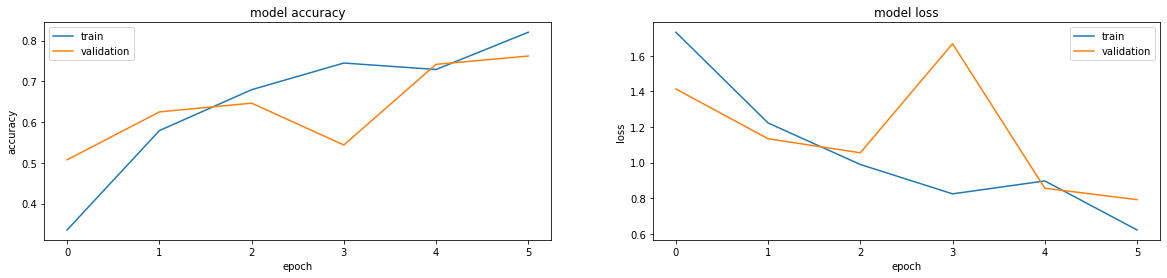

46/46 [==============================] - 2s 46ms/step


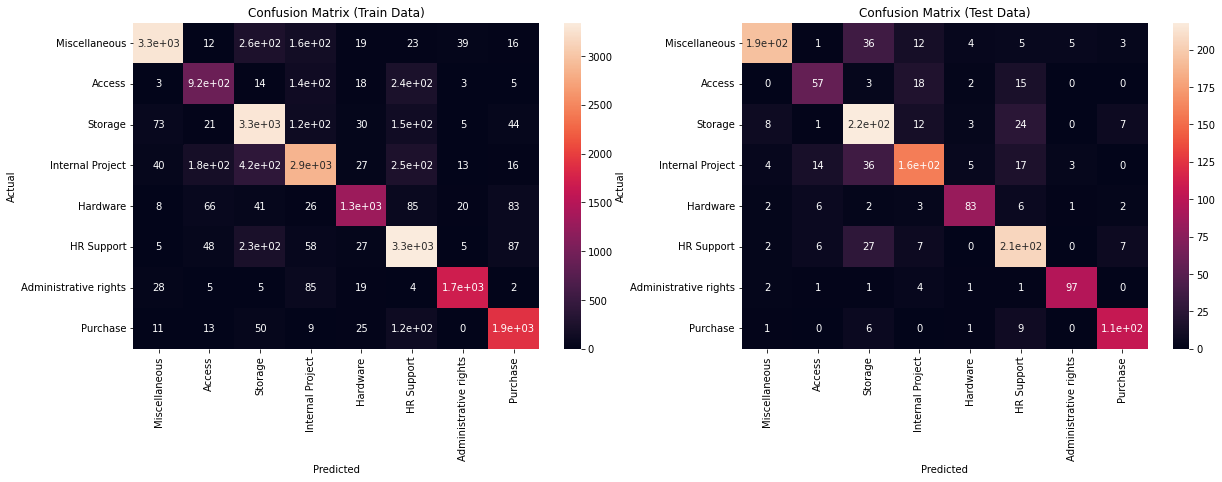

Train Data:
--------------------------------------------------------
                       precision    recall  f1-score   support

        Miscellaneous       0.86      0.95      0.90      3454
               Access       0.69      0.72      0.71      1268
              Storage       0.88      0.76      0.82      4314
     Internal Project       0.75      0.83      0.79      3465
             Hardware       0.80      0.89      0.84      1464
           HR Support       0.88      0.79      0.83      4222
Administrative rights       0.92      0.95      0.94      1786
             Purchase       0.89      0.88      0.89      2158

             accuracy                           0.84     22131
            macro avg       0.83      0.85      0.84     22131
         weighted avg       0.84      0.84      0.84     22131


Test Data:
--------------------------------------------------------
                       precision    recall  f1-score   support

        Miscellaneous       0.75      0

In [ ]:
# Evaluating after training over 6 epochs

model_RNN.load_weights("best_checkpoint_1C_bilstm")

# Evaluate on test data
model_RNN.evaluate(x=test_text, y=test_labels)

# Display Training History
display_training_loss_and_accuracy(history_spec_RNN)

# Display confusion matrix & classification report
display_classification_confusion_matrix(model_RNN, train_text, train_labels, test_text, test_labels, unique_categories)

As the training & validation accuracy is still uptrending, and variance is relatively low after 6 epochs, train the model on another 2 epochs.

In [ ]:
# Add another 2 epochs

history_spec_RNN = model_RNN.fit(
    train_text, 
    train_labels,
    validation_data=(val_text, val_labels),
    epochs=2, #total 8 epochs
    batch_size=32,
    callbacks=[save_best_model('best_checkpoint_1C_bilstm')])

Epoch 1/2
692/692 [==============================] - 287s 414ms/step - loss: 0.5473 - accuracy: 0.8415 - val_loss: 0.7582 - val_accuracy: 0.7799
Epoch 2/2
692/692 [==============================] - 211s 306ms/step - loss: 0.4942 - accuracy: 0.8581 - val_loss: 0.8364 - val_accuracy: 0.7511


46/46 [==============================] - 1s 23ms/step - loss: 0.7497 - accuracy: 0.7699


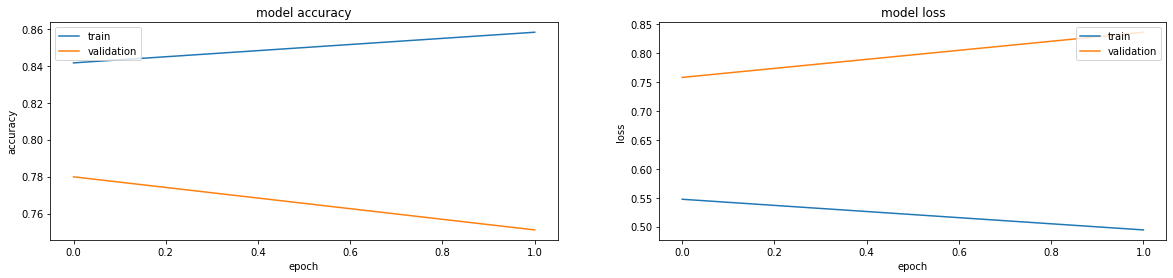

46/46 [==============================] - 2s 35ms/step


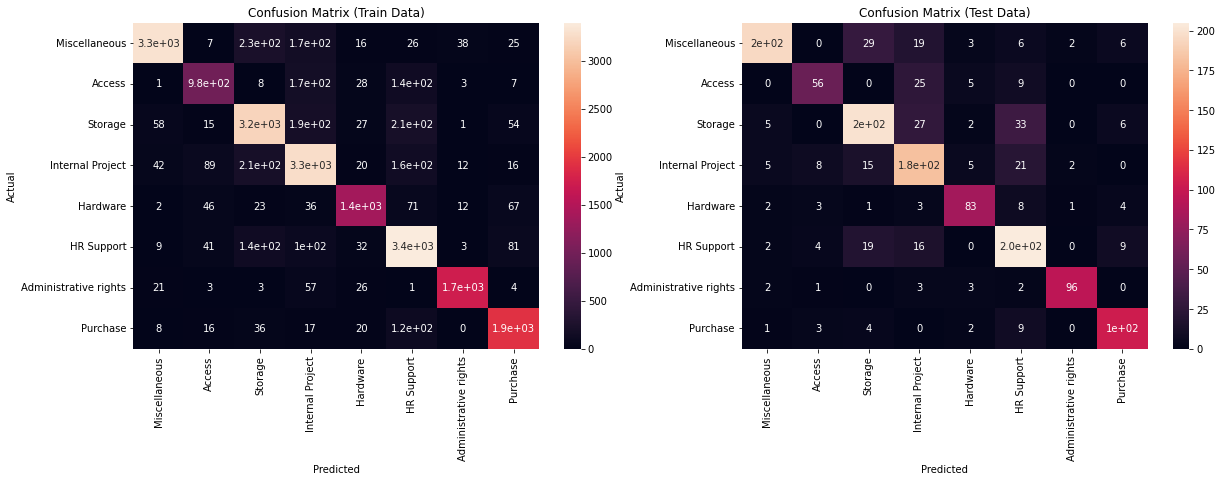

Train Data:
--------------------------------------------------------
                       precision    recall  f1-score   support

        Miscellaneous       0.87      0.96      0.91      3447
               Access       0.73      0.82      0.77      1197
              Storage       0.85      0.83      0.84      3841
     Internal Project       0.86      0.82      0.84      4016
             Hardware       0.84      0.89      0.87      1540
           HR Support       0.89      0.83      0.86      4109
Administrative rights       0.94      0.96      0.95      1803
             Purchase       0.90      0.88      0.89      2178

             accuracy                           0.87     22131
            macro avg       0.86      0.87      0.87     22131
         weighted avg       0.87      0.87      0.87     22131


Test Data:
--------------------------------------------------------
                       precision    recall  f1-score   support

        Miscellaneous       0.75      0

In [ ]:
# Evaluating after training over 8 epochs

model_RNN.load_weights("best_checkpoint_1C_bilstm")

# Evaluate on test data
model_RNN.evaluate(x=test_text, y=test_labels)

# Display Training History
display_training_loss_and_accuracy(history_spec_RNN)

# Display confusion matrix & classification report
display_classification_confusion_matrix(model_RNN, train_text, train_labels, test_text, test_labels, unique_categories)

After increasing the number of dense layers, The model performed poorer, with a lower testing accuracy of 76.99%.

Adding 2 more epochs after the initial 6 was not helpful. The increase in variance, and decrease in validation accuracy suggests that there may be some overfitting of the model.

In the next run, reduce the number of weights in the Dense layer, and also apply regularisation techniques such as Dropout layers.

### 1D. Build RNN model with Dense layer & Dropouts
- SimpleRNN (128, tanh dropout=0.2, recurrent_dropout=0.2)
- Dense (64, relu)
- Dropout (0.5)

In [ ]:
EMBEDDING_DIM=128

inputs = keras.Input(shape=(MAX_SEQUENCE_LENGTH,))

embedded = keras.layers.Embedding(input_dim=VOCAB_SIZE, 
                                  output_dim=EMBEDDING_DIM, 
                                  mask_zero=True)(inputs)

# RNN Example:
x = keras.layers.SimpleRNN(128, dropout=0.2, recurrent_dropout=0.2)(embedded)
x = keras.layers.Dense(64, activation='relu')(x)
x = keras.layers.Dropout(0.5)(x)
outputs = keras.layers.Dense(8, activation='softmax')(x)   # 8 categories

model_RNN = keras.Model(inputs, outputs)

model_RNN.compile(optimizer=keras.optimizers.Adam(1e-4),
              loss=keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

model_RNN.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 200)]             0         
                                                                 
 embedding_3 (Embedding)     (None, 200, 128)          1227776   
                                                                 
 simple_rnn_3 (SimpleRNN)    (None, 128)               32896     
                                                                 
 dense_6 (Dense)             (None, 64)                8256      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_7 (Dense)             (None, 8)                 520       
                                                                 
Total params: 1,269,448
Trainable params: 1,269,448
Non-tra

In [ ]:
history_spec_RNN = model_RNN.fit(
    train_text, 
    train_labels,
    validation_data=(val_text, val_labels),
    epochs=6,
    batch_size=32,
    callbacks=[save_best_model('best_checkpoint_1D_bilstm')])

Epoch 1/6
692/692 [==============================] - 475s 526ms/step - loss: 2.0938 - accuracy: 0.1604 - val_loss: 1.9915 - val_accuracy: 0.2651
Epoch 2/6
692/692 [==============================] - 287s 415ms/step - loss: 2.0132 - accuracy: 0.2011 - val_loss: 1.8831 - val_accuracy: 0.3100
Epoch 3/6
692/692 [==============================] - 302s 437ms/step - loss: 1.8721 - accuracy: 0.2710 - val_loss: 1.7516 - val_accuracy: 0.3989
Epoch 4/6
692/692 [==============================] - 285s 412ms/step - loss: 1.6504 - accuracy: 0.3901 - val_loss: 1.6896 - val_accuracy: 0.3945
Epoch 5/6
692/692 [==============================] - 295s 427ms/step - loss: 1.4986 - accuracy: 0.4525 - val_loss: 1.9194 - val_accuracy: 0.4106
Epoch 6/6
692/692 [==============================] - 294s 425ms/step - loss: 1.4594 - accuracy: 0.4785 - val_loss: 1.3042 - val_accuracy: 0.5659


In [ ]:
# Add 4 more epochs

history_spec_RNN_2 = model_RNN.fit(
    train_text, 
    train_labels,
    validation_data=(val_text, val_labels),
    epochs=4,
    batch_size=32,
    callbacks=[save_best_model('best_checkpoint_1D_bilstm')])

Epoch 1/4
692/692 [==============================] - 345s 499ms/step - loss: 1.3816 - accuracy: 0.5122 - val_loss: 1.3190 - val_accuracy: 0.5446
Epoch 2/4
692/692 [==============================] - 282s 408ms/step - loss: 1.3360 - accuracy: 0.5345 - val_loss: 1.2484 - val_accuracy: 0.5914
Epoch 3/4
692/692 [==============================] - 283s 408ms/step - loss: 1.2910 - accuracy: 0.5600 - val_loss: 1.2524 - val_accuracy: 0.5867
Epoch 4/4
692/692 [==============================] - 284s 411ms/step - loss: 1.2628 - accuracy: 0.5682 - val_loss: 1.2459 - val_accuracy: 0.5993


After applying regularisation, the training time for this model increased sizably. The model training and validation acc is still uptrending after 10 epochs.

As the training took too long, the training was abandoned early.

## 2. Basic LSTM

### 2A. Build LSTM model with Dense layer
- LSTM (64, tanh) 
- Dense (128, relu)

In [ ]:
EMBEDDING_DIM=128

inputs = keras.Input(shape=(MAX_SEQUENCE_LENGTH,))

embedded = keras.layers.Embedding(input_dim=VOCAB_SIZE, 
                                  output_dim=EMBEDDING_DIM, 
                                  mask_zero=True)(inputs)

# LSTM Example:
x = keras.layers.LSTM(64)(embedded)  # default activation function is tanh
x = keras.layers.Dense(128, activation='relu')(x)
outputs = keras.layers.Dense(8, activation='softmax')(x)   # 8 categories

model_LSTM = keras.Model(inputs, outputs)

model_LSTM.compile(optimizer=keras.optimizers.Adam(1e-4),
              loss=keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

model_LSTM.summary()

Model: "model_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_15 (InputLayer)       [(None, 200)]             0         
                                                                 
 embedding_14 (Embedding)    (None, 200, 128)          1227392   
                                                                 
 lstm_13 (LSTM)              (None, 64)                49408     
                                                                 
 dense_32 (Dense)            (None, 128)               8320      
                                                                 
 dense_33 (Dense)            (None, 8)                 1032      
                                                                 
Total params: 1,286,152
Trainable params: 1,286,152
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history_spec_LSTM = model_LSTM.fit(
    train_text, 
    train_labels,
    validation_data=(val_text, val_labels),
    epochs=10, 
    batch_size=32,
    callbacks=[save_best_model('best_checkpoint_2A_bilstm')])

Epoch 1/10
692/692 [==============================] - 103s 82ms/step - loss: 1.7197 - accuracy: 0.3484 - val_loss: 1.3868 - val_accuracy: 0.5277
Epoch 2/10
692/692 [==============================] - 22s 32ms/step - loss: 1.1703 - accuracy: 0.6064 - val_loss: 1.0491 - val_accuracy: 0.6543
Epoch 3/10
692/692 [==============================] - 15s 22ms/step - loss: 0.8894 - accuracy: 0.7051 - val_loss: 0.8723 - val_accuracy: 0.7148
Epoch 4/10
692/692 [==============================] - 16s 23ms/step - loss: 0.7069 - accuracy: 0.7671 - val_loss: 0.7939 - val_accuracy: 0.7397
Epoch 5/10
692/692 [==============================] - 13s 19ms/step - loss: 0.5979 - accuracy: 0.8175 - val_loss: 0.7393 - val_accuracy: 0.7687
Epoch 6/10
692/692 [==============================] - 12s 17ms/step - loss: 0.5219 - accuracy: 0.8430 - val_loss: 0.7209 - val_accuracy: 0.7802
Epoch 7/10
692/692 [==============================] - 15s 22ms/step - loss: 0.4721 - accuracy: 0.8584 - val_loss: 0.6938 - val_accuracy

46/46 [==============================] - 0s 8ms/step - loss: 0.6989 - accuracy: 0.7960


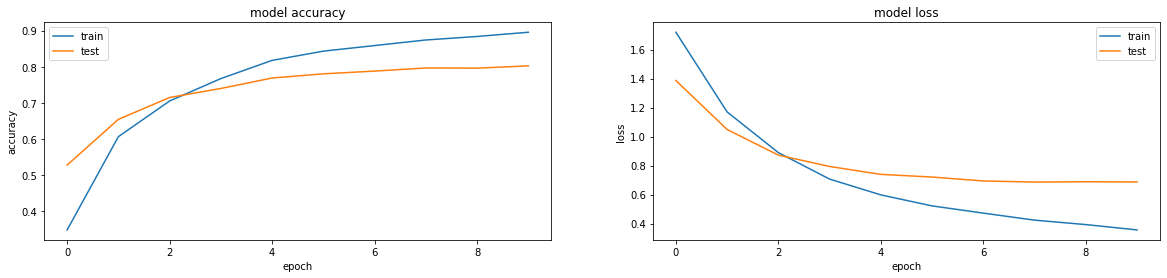

46/46 [==============================] - 0s 5ms/step


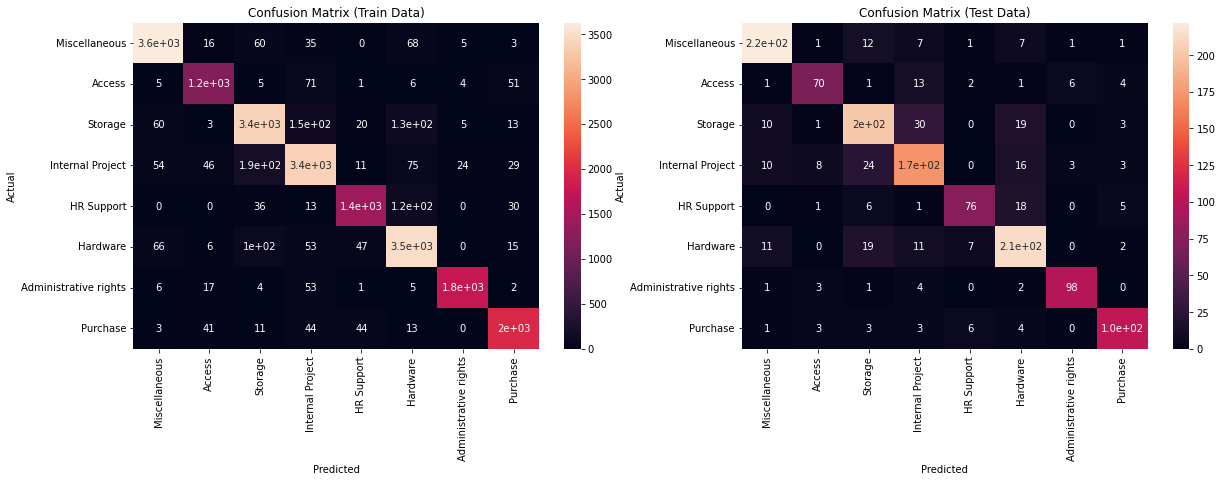

Train Data:
--------------------------------------------------------
                       precision    recall  f1-score   support

        Miscellaneous       0.95      0.95      0.95      3820
               Access       0.89      0.90      0.90      1323
              Storage       0.90      0.89      0.90      3794
     Internal Project       0.89      0.89      0.89      3808
           HR Support       0.88      0.92      0.90      1552
             Hardware       0.92      0.89      0.91      3909
Administrative rights       0.95      0.98      0.97      1802
             Purchase       0.93      0.93      0.93      2123

             accuracy                           0.92     22131
            macro avg       0.91      0.92      0.92     22131
         weighted avg       0.92      0.92      0.92     22131


Test Data:
--------------------------------------------------------
                       precision    recall  f1-score   support

        Miscellaneous       0.88      0

In [ ]:
model_LSTM.load_weights("best_checkpoint_2A_bilstm")

# Evaluate on test data
model_LSTM.evaluate(x=test_text, y=test_labels)

# Display Training History
display_training_loss_and_accuracy(history_spec_LSTM)

# Display confusion matrix & classification report
display_classification_confusion_matrix(model_LSTM, train_text, train_labels, test_text, test_labels, unique_categories)

LSTM performs better (higher test accuracy) than RNN. This is likely because LSTMs are better able to retain long-term dependencies in the data or text. Traditional RNNs have a tendency to lose information from the beginning of the sequence as it is propagated through the network, making it difficult to learn long-term dependencies. LSTMs, on the other hand, have a specialized memory cell that can selectively forget or remember information at each time step, allowing them to maintain information over longer periods of time.

### 2B. Build LSTM model with Dense & Dropout layers

- LSTM (64, tanh) 
- Dropout (0.5)
- Dense (128, relu)
- Dropout (0.5)

In [ ]:
EMBEDDING_DIM=128

inputs = keras.Input(shape=(MAX_SEQUENCE_LENGTH,))

embedded = keras.layers.Embedding(input_dim=VOCAB_SIZE, 
                                  output_dim=EMBEDDING_DIM, 
                                  mask_zero=True)(inputs)

# LSTM Example:
x = keras.layers.LSTM(64)(embedded)
x = keras.layers.Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = keras.layers.Dense(8, activation='softmax')(x)   # 8 categories

model_LSTM = keras.Model(inputs, outputs)

model_LSTM.compile(optimizer=keras.optimizers.Adam(1e-4),
              loss=keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

model_LSTM.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 200)]             0         
                                                                 
 embedding_1 (Embedding)     (None, 200, 128)          1234944   
                                                                 
 lstm_1 (LSTM)               (None, 64)                49408     
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 128)               8320      
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                                 
 dense_4 (Dense)             (None, 8)                 1032

In [ ]:
history_spec_LSTM = model_LSTM.fit(
    train_text, 
    train_labels,
    validation_data=(val_text, val_labels),
    epochs=10, 
    batch_size=32,
    callbacks=[save_best_model('best_checkpoint_2B_bilstm')])

Epoch 1/10
692/692 [==============================] - 69s 89ms/step - loss: 1.9165 - accuracy: 0.2445 - val_loss: 1.7278 - val_accuracy: 0.2986
Epoch 2/10
692/692 [==============================] - 32s 46ms/step - loss: 1.6251 - accuracy: 0.3397 - val_loss: 1.3515 - val_accuracy: 0.4939
Epoch 3/10
692/692 [==============================] - 16s 23ms/step - loss: 1.2432 - accuracy: 0.5250 - val_loss: 1.0301 - val_accuracy: 0.6597
Epoch 4/10
692/692 [==============================] - 13s 18ms/step - loss: 0.9569 - accuracy: 0.6620 - val_loss: 0.9148 - val_accuracy: 0.7003
Epoch 5/10
692/692 [==============================] - 14s 20ms/step - loss: 0.8082 - accuracy: 0.7349 - val_loss: 0.8052 - val_accuracy: 0.7584
Epoch 6/10
692/692 [==============================] - 12s 17ms/step - loss: 0.7115 - accuracy: 0.7780 - val_loss: 0.7630 - val_accuracy: 0.7694
Epoch 7/10
692/692 [==============================] - 13s 18ms/step - loss: 0.7067 - accuracy: 0.7888 - val_loss: 0.7699 - val_accuracy:

46/46 [==============================] - 0s 6ms/step - loss: 0.7097 - accuracy: 0.7995


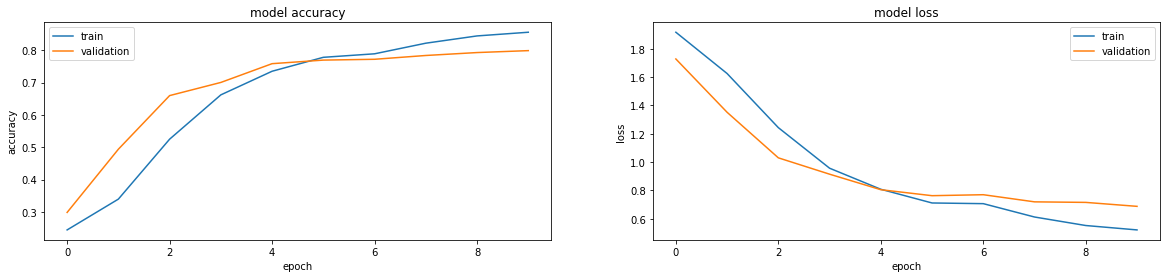

46/46 [==============================] - 0s 4ms/step


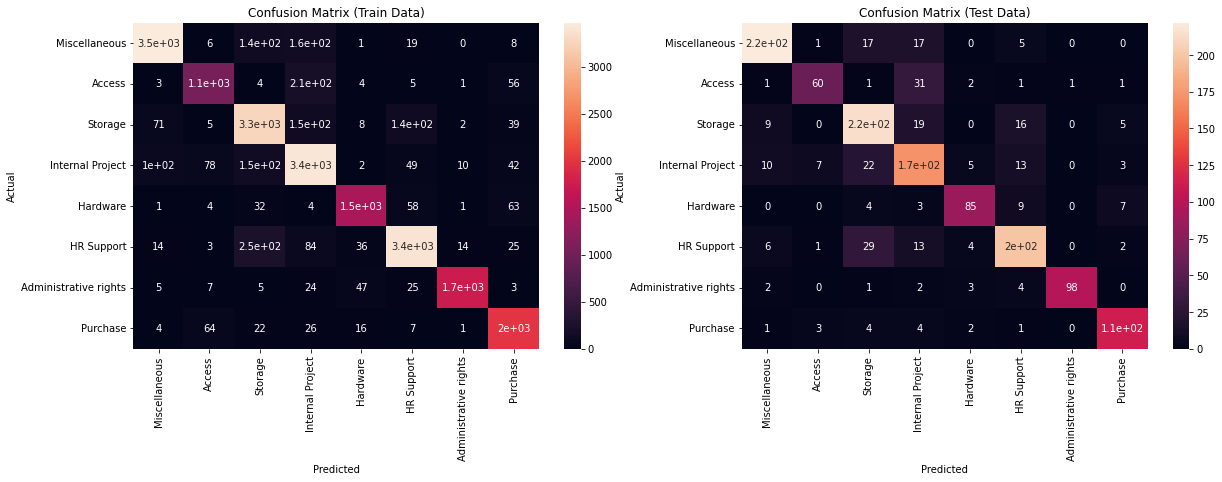

Train Data:
--------------------------------------------------------
                       precision    recall  f1-score   support

        Miscellaneous       0.91      0.95      0.93      3671
               Access       0.79      0.86      0.82      1218
              Storage       0.89      0.85      0.87      3872
     Internal Project       0.89      0.84      0.86      4087
             Hardware       0.90      0.93      0.91      1587
           HR Support       0.89      0.92      0.90      3696
Administrative rights       0.94      0.98      0.96      1767
             Purchase       0.93      0.89      0.91      2233

             accuracy                           0.90     22131
            macro avg       0.89      0.90      0.90     22131
         weighted avg       0.90      0.90      0.90     22131


Test Data:
--------------------------------------------------------
                       precision    recall  f1-score   support

        Miscellaneous       0.85      0

In [ ]:
model_LSTM.load_weights("best_checkpoint_2B_bilstm")

# Evaluate on test data
model_LSTM.evaluate(x=test_text, y=test_labels)

# Display Training History
display_training_loss_and_accuracy(history_spec_LSTM)

# Display confusion matrix & classification report
display_classification_confusion_matrix(model_LSTM, train_text, train_labels, test_text, test_labels, unique_categories)

After applying dropouts, less overfitting observed as compared to 2A, and variance between training and validation is lower.

Slight improvement to testing accuracy.

### Build LSTM model with additional Dense & Dropout layers (Run 2C)

- LSTM (64, tanh) 
- Dropout (0.5)
- Dense (256, relu)
- Dropout (0.5)
- Dense (128, relu)
- Dropout (0.5)

In [ ]:
EMBEDDING_DIM=128

inputs = keras.Input(shape=(MAX_SEQUENCE_LENGTH,))

embedded = keras.layers.Embedding(input_dim=VOCAB_SIZE, 
                                  output_dim=EMBEDDING_DIM, 
                                  mask_zero=True)(inputs)

# LSTM Example:
x = keras.layers.LSTM(64)(embedded)
x = keras.layers.Dropout(0.5)(x)
x = keras.layers.Dense(256, activation='relu')(x)
x = keras.layers.Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = keras.layers.Dense(8, activation='softmax')(x)   # 8 categories

model_LSTM = keras.Model(inputs, outputs)

model_LSTM.compile(optimizer=keras.optimizers.Adam(1e-4),
              loss=keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

model_LSTM.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 200)]             0         
                                                                 
 embedding_2 (Embedding)     (None, 200, 128)          1234944   
                                                                 
 lstm_2 (LSTM)               (None, 64)                49408     
                                                                 
 dropout_4 (Dropout)         (None, 64)                0         
                                                                 
 dense_5 (Dense)             (None, 256)               16640     
                                                                 
 dropout_5 (Dropout)         (None, 256)               0         
                                                                 
 dense_6 (Dense)             (None, 128)               3289

In [ ]:
history_spec_LSTM = model_LSTM.fit(
    train_text, 
    train_labels,
    validation_data=(val_text, val_labels),
    epochs=10, 
    batch_size=32,
    callbacks=[save_best_model('best_checkpoint_2C_bilstm')])

Epoch 1/10
692/692 [==============================] - 53s 65ms/step - loss: 1.8795 - accuracy: 0.2090 - val_loss: 1.5765 - val_accuracy: 0.2662
Epoch 2/10
692/692 [==============================] - 18s 26ms/step - loss: 1.5519 - accuracy: 0.3086 - val_loss: 1.4230 - val_accuracy: 0.3613
Epoch 3/10
692/692 [==============================] - 14s 21ms/step - loss: 1.3797 - accuracy: 0.4069 - val_loss: 1.2486 - val_accuracy: 0.4985
Epoch 4/10
692/692 [==============================] - 12s 17ms/step - loss: 1.1493 - accuracy: 0.5332 - val_loss: 0.9975 - val_accuracy: 0.6089
Epoch 5/10
692/692 [==============================] - 13s 18ms/step - loss: 0.9393 - accuracy: 0.6336 - val_loss: 0.8850 - val_accuracy: 0.6989
Epoch 6/10
692/692 [==============================] - 12s 17ms/step - loss: 0.8068 - accuracy: 0.7125 - val_loss: 0.8111 - val_accuracy: 0.7446
Epoch 7/10
692/692 [==============================] - 12s 17ms/step - loss: 0.6967 - accuracy: 0.7731 - val_loss: 0.7635 - val_accuracy:

46/46 [==============================] - 0s 6ms/step - loss: 0.6736 - accuracy: 0.8022


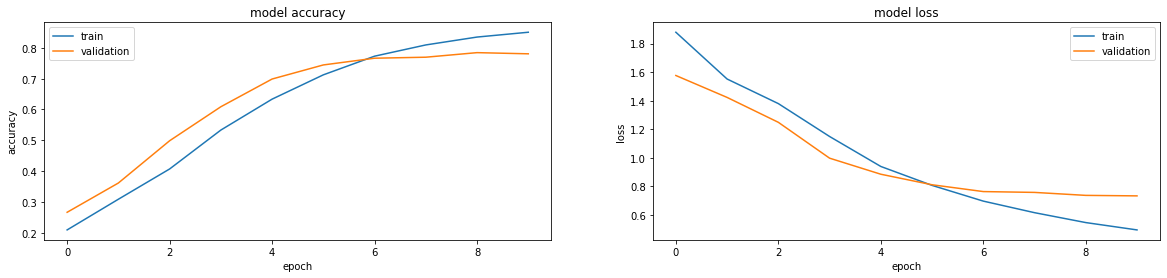

46/46 [==============================] - 0s 4ms/step


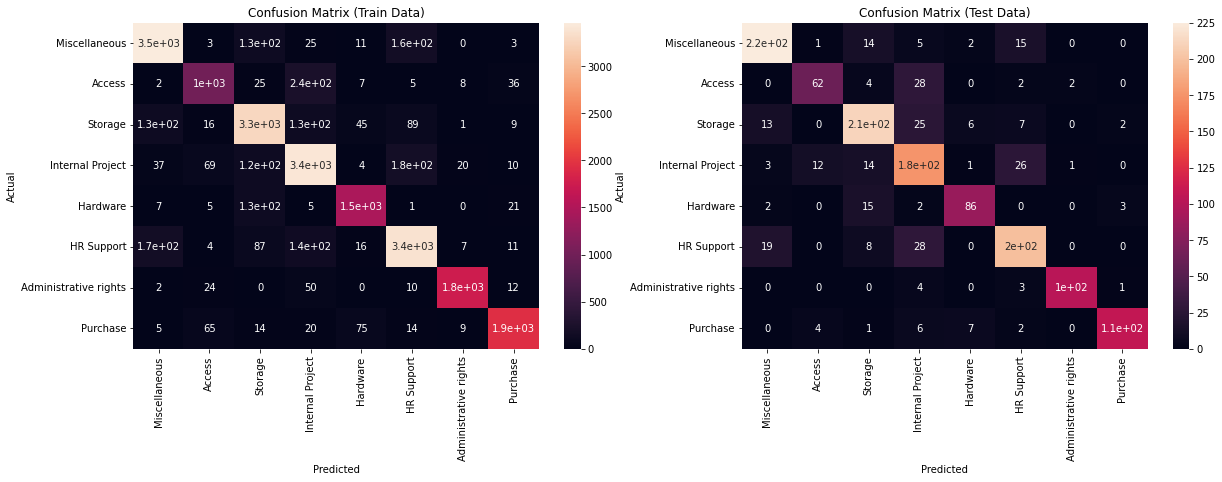

Train Data:
--------------------------------------------------------
                       precision    recall  f1-score   support

        Miscellaneous       0.91      0.91      0.91      3813
               Access       0.76      0.84      0.80      1199
              Storage       0.89      0.86      0.88      3789
     Internal Project       0.88      0.85      0.87      4034
             Hardware       0.89      0.90      0.90      1622
           HR Support       0.88      0.88      0.88      3836
Administrative rights       0.95      0.98      0.96      1801
             Purchase       0.91      0.95      0.93      2037

             accuracy                           0.89     22131
            macro avg       0.88      0.90      0.89     22131
         weighted avg       0.89      0.89      0.89     22131


Test Data:
--------------------------------------------------------
                       precision    recall  f1-score   support

        Miscellaneous       0.86      0

In [ ]:
model_LSTM.load_weights("best_checkpoint_2C_bilstm")

# Evaluate on test data
model_LSTM.evaluate(x=test_text, y=test_labels)

# Display Training History
display_training_loss_and_accuracy(history_spec_LSTM)

# Display confusion matrix & classification report
display_classification_confusion_matrix(model_LSTM, train_text, train_labels, test_text, test_labels, unique_categories)

With an additional dense layer, there is a slight decrease in variance compared to 2B, as well as slight improvement in test accuracy.

The additional complexity may have allowed the model to detect more specific relationships hence allowing it to perform better.

## 3. Basic GRU

### 3A. Build GRU model with Dense layer
- GRU (64, tanh) 
- Dense (128, relu)

In [ ]:
EMBEDDING_DIM=128

inputs = keras.Input(shape=(MAX_SEQUENCE_LENGTH,))

embedded = keras.layers.Embedding(input_dim=VOCAB_SIZE, 
                                  output_dim=EMBEDDING_DIM, 
                                  mask_zero=True)(inputs)

# GRU Example:
x = keras.layers.GRU(64)(embedded)
x = keras.layers.Dense(128, activation='relu')(x)
outputs = keras.layers.Dense(8, activation='softmax')(x)   # 8 categories

model_GRU = keras.Model(inputs, outputs)

model_GRU.compile(optimizer=keras.optimizers.Adam(1e-4),
              loss=keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

model_GRU.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 200)]             0         
                                                                 
 embedding_4 (Embedding)     (None, 200, 128)          1245568   
                                                                 
 gru_1 (GRU)                 (None, 64)                37248     
                                                                 
 dense_5 (Dense)             (None, 128)               8320      
                                                                 
 dense_6 (Dense)             (None, 8)                 1032      
                                                                 
Total params: 1,292,168
Trainable params: 1,292,168
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history_spec_GRU = model_GRU.fit(
    train_text, 
    train_labels,
    validation_data=(val_text, val_labels),
    epochs=10, 
    batch_size=32,
    callbacks=[save_best_model('best_checkpoint_3A_bilstm')])

Epoch 1/10
692/692 [==============================] - 46s 60ms/step - loss: 1.8267 - accuracy: 0.2848 - val_loss: 1.4938 - val_accuracy: 0.4254
Epoch 2/10
692/692 [==============================] - 16s 23ms/step - loss: 1.2546 - accuracy: 0.5317 - val_loss: 1.0856 - val_accuracy: 0.6141
Epoch 3/10
692/692 [==============================] - 14s 20ms/step - loss: 0.8609 - accuracy: 0.7048 - val_loss: 0.8669 - val_accuracy: 0.7179
Epoch 4/10
692/692 [==============================] - 12s 18ms/step - loss: 0.6802 - accuracy: 0.7805 - val_loss: 0.7953 - val_accuracy: 0.7435
Epoch 5/10
692/692 [==============================] - 11s 17ms/step - loss: 0.5882 - accuracy: 0.8151 - val_loss: 0.7714 - val_accuracy: 0.7569
Epoch 6/10
692/692 [==============================] - 13s 18ms/step - loss: 0.5228 - accuracy: 0.8386 - val_loss: 0.7570 - val_accuracy: 0.7618
Epoch 7/10
692/692 [==============================] - 12s 17ms/step - loss: 0.4689 - accuracy: 0.8586 - val_loss: 0.7377 - val_accuracy:

46/46 [==============================] - 0s 6ms/step - loss: 0.6777 - accuracy: 0.7919


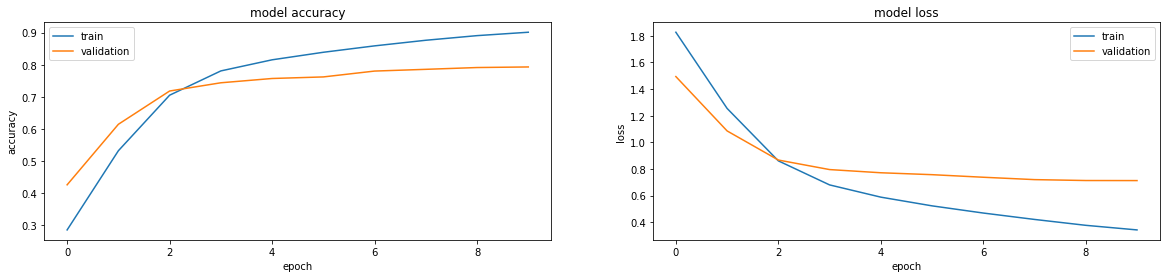

46/46 [==============================] - 0s 4ms/step


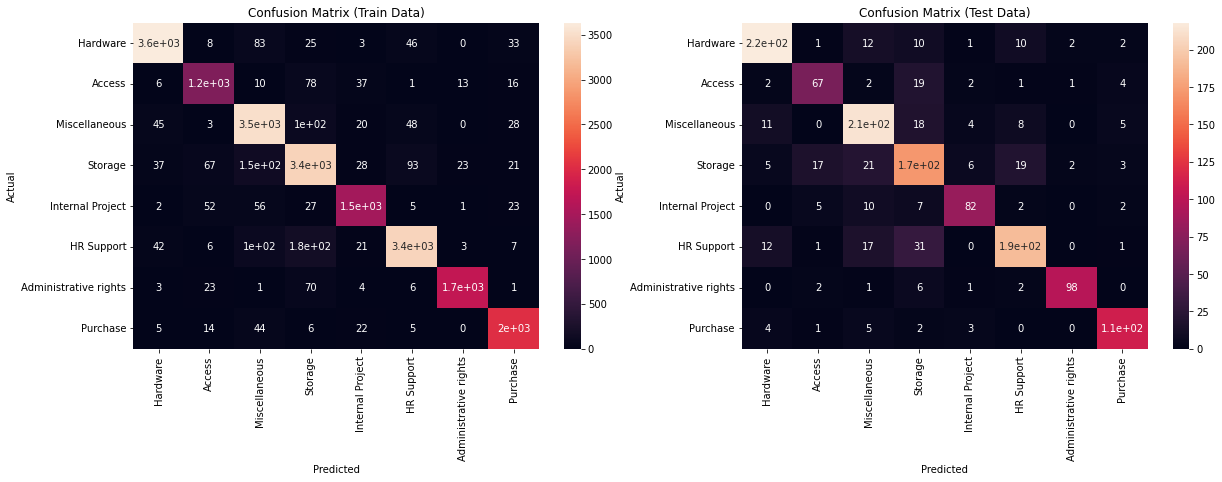

Train Data:
--------------------------------------------------------
                       precision    recall  f1-score   support

             Hardware       0.95      0.96      0.96      3774
               Access       0.88      0.87      0.88      1346
        Miscellaneous       0.93      0.89      0.91      3952
              Storage       0.89      0.87      0.88      3895
     Internal Project       0.90      0.92      0.91      1598
           HR Support       0.90      0.94      0.92      3621
Administrative rights       0.94      0.98      0.96      1778
             Purchase       0.96      0.94      0.95      2167

             accuracy                           0.92     22131
            macro avg       0.92      0.92      0.92     22131
         weighted avg       0.92      0.92      0.92     22131


Test Data:
--------------------------------------------------------
                       precision    recall  f1-score   support

             Hardware       0.85      0

In [ ]:
model_GRU.load_weights("best_checkpoint_3A_bilstm")

# Evaluate on test data
model_GRU.evaluate(x=test_text, y=test_labels)

# Display Training History
display_training_loss_and_accuracy(history_spec_GRU)

# Display confusion matrix & classification report
display_classification_confusion_matrix(model_GRU, train_text, train_labels, test_text, test_labels, unique_categories)

After 10 epochs and compared to basic LSTM (Run 2A), GRU runs slightly faster but has slightly lower test accuracy and higher variance.


## 4. Bidirectional LSTM

### 4A. Build Bidirectional LSTM model
- Bidirectional LSTM (64, tanh) 

In [ ]:
EMBEDDING_DIM=128

inputs = keras.Input(shape=(MAX_SEQUENCE_LENGTH,))

embedded = keras.layers.Embedding(input_dim=VOCAB_SIZE, 
                                  output_dim=EMBEDDING_DIM, 
                                  mask_zero=True)(inputs)

# LSTM Example:
x = keras.layers.Bidirectional(keras.layers.LSTM(64))(embedded) # default activation function is tanh
outputs = keras.layers.Dense(8, activation='softmax')(x)   # 8 categories

model_LSTM = keras.Model(inputs, outputs)

model_LSTM.compile(optimizer=keras.optimizers.Adam(1e-4),
              loss=keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

model_LSTM.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 200)]             0         
                                                                 
 embedding (Embedding)       (None, 200, 128)          1237376   
                                                                 
 bidirectional (Bidirectiona  (None, 128)              98816     
 l)                                                              
                                                                 
 dense (Dense)               (None, 8)                 1032      
                                                                 
Total params: 1,337,224
Trainable params: 1,337,224
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history_spec_LSTM = model_LSTM.fit(
    train_text, 
    train_labels,
    validation_data=(val_text, val_labels),
    epochs=10, 
    batch_size=32,
    callbacks=[save_best_model('best_checkpoint_4A_bilstm')])

Epoch 1/10
692/692 [==============================] - 93s 109ms/step - loss: 1.6413 - accuracy: 0.4612 - val_loss: 1.1558 - val_accuracy: 0.6604
Epoch 2/10
692/692 [==============================] - 26s 37ms/step - loss: 0.9822 - accuracy: 0.7104 - val_loss: 0.8553 - val_accuracy: 0.7482
Epoch 3/10
692/692 [==============================] - 20s 29ms/step - loss: 0.7324 - accuracy: 0.7838 - val_loss: 0.7447 - val_accuracy: 0.7753
Epoch 4/10
692/692 [==============================] - 20s 29ms/step - loss: 0.6028 - accuracy: 0.8264 - val_loss: 0.6618 - val_accuracy: 0.8008
Epoch 5/10
692/692 [==============================] - 17s 25ms/step - loss: 0.5315 - accuracy: 0.8477 - val_loss: 0.6305 - val_accuracy: 0.8077
Epoch 6/10
692/692 [==============================] - 19s 27ms/step - loss: 0.4491 - accuracy: 0.8722 - val_loss: 0.5910 - val_accuracy: 0.8187
Epoch 7/10
692/692 [==============================] - 17s 25ms/step - loss: 0.3981 - accuracy: 0.8838 - val_loss: 0.5778 - val_accuracy

46/46 [==============================] - 1s 13ms/step - loss: 0.5590 - accuracy: 0.8249


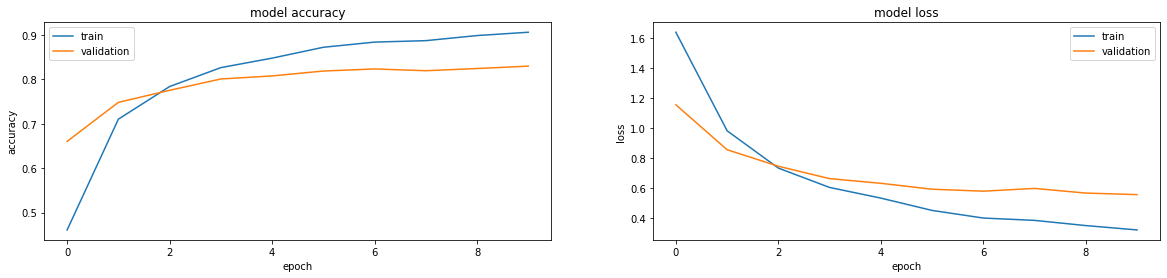

46/46 [==============================] - 0s 8ms/step


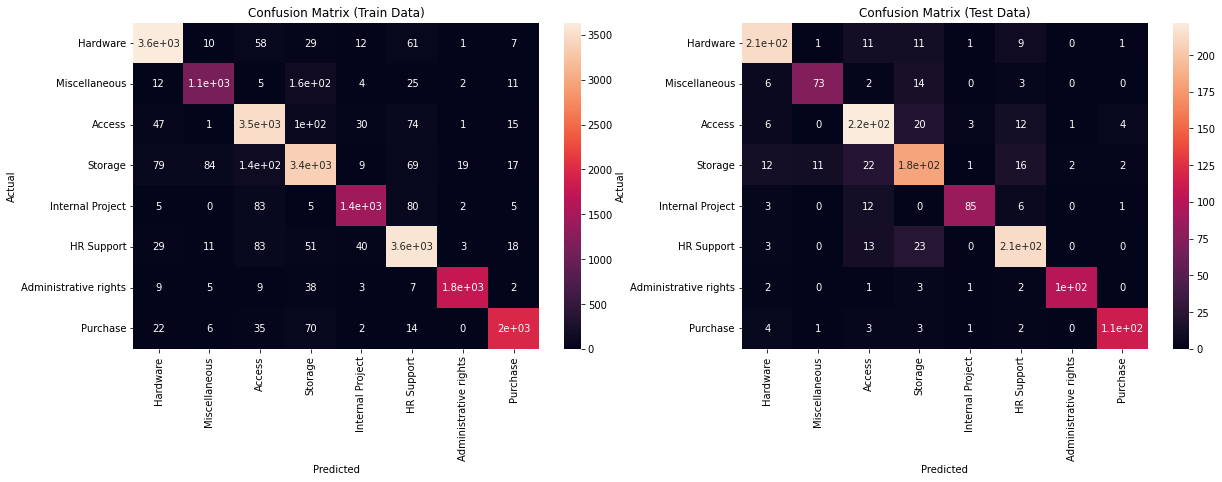

Train Data:
--------------------------------------------------------
                       precision    recall  f1-score   support

             Hardware       0.95      0.95      0.95      3840
        Miscellaneous       0.84      0.90      0.87      1231
               Access       0.93      0.89      0.91      3920
              Storage       0.89      0.88      0.89      3828
     Internal Project       0.89      0.94      0.91      1546
           HR Support       0.94      0.92      0.93      3910
Administrative rights       0.96      0.98      0.97      1798
             Purchase       0.93      0.96      0.95      2058

             accuracy                           0.92     22131
            macro avg       0.92      0.93      0.92     22131
         weighted avg       0.92      0.92      0.92     22131


Test Data:
--------------------------------------------------------
                       precision    recall  f1-score   support

             Hardware       0.86      0

In [ ]:
model_LSTM.load_weights("best_checkpoint_4A_bilstm")

# Evaluate on test data
model_LSTM.evaluate(x=test_text, y=test_labels)

# Display Training History
display_training_loss_and_accuracy(history_spec_LSTM)

# Display confusion matrix & classification report
display_classification_confusion_matrix(model_LSTM, train_text, train_labels, test_text, test_labels, unique_categories)

Simple model without any intermediary dense layers. To attempt to include dense layers in the subsequent runs to observe impact on accuracy.

### 4B. Build Bidirectional LSTM model with Dense layer
- Bidirectional LSTM (64, tanh) 
- Dense (128, relu)

In [ ]:
EMBEDDING_DIM=128

inputs = keras.Input(shape=(MAX_SEQUENCE_LENGTH,))

embedded = keras.layers.Embedding(input_dim=VOCAB_SIZE, 
                                  output_dim=EMBEDDING_DIM, 
                                  mask_zero=True)(inputs)

# LSTM Example:
x = keras.layers.Bidirectional(keras.layers.LSTM(64))(embedded)
x = keras.layers.Dense(128, activation='relu')(x)
outputs = keras.layers.Dense(8, activation='softmax')(x)   # 8 categories

model_LSTM = keras.Model(inputs, outputs)

model_LSTM.compile(optimizer=keras.optimizers.Adam(1e-4),
              loss=keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

model_LSTM.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 200)]             0         
                                                                 
 embedding_2 (Embedding)     (None, 200, 128)          1227392   
                                                                 
 bidirectional_2 (Bidirectio  (None, 128)              98816     
 nal)                                                            
                                                                 
 dense_4 (Dense)             (None, 128)               16512     
                                                                 
 dense_5 (Dense)             (None, 8)                 1032      
                                                                 
Total params: 1,343,752
Trainable params: 1,343,752
Non-trainable params: 0
_________________________________________________

In [ ]:
history_spec_LSTM = model_LSTM.fit(
    train_text, 
    train_labels,
    validation_data=(val_text, val_labels),
    epochs=10, 
    batch_size=32,
    callbacks=[save_best_model('best_checkpoint_4b_bilstm')])

Epoch 1/10
692/692 [==============================] - 79s 96ms/step - loss: 1.5227 - accuracy: 0.4851 - val_loss: 0.9427 - val_accuracy: 0.7217
Epoch 2/10
692/692 [==============================] - 26s 38ms/step - loss: 0.7356 - accuracy: 0.7742 - val_loss: 0.6770 - val_accuracy: 0.7969
Epoch 3/10
692/692 [==============================] - 22s 31ms/step - loss: 0.5257 - accuracy: 0.8390 - val_loss: 0.5958 - val_accuracy: 0.8149
Epoch 4/10
692/692 [==============================] - 22s 32ms/step - loss: 0.4233 - accuracy: 0.8711 - val_loss: 0.5442 - val_accuracy: 0.8308
Epoch 5/10
692/692 [==============================] - 19s 27ms/step - loss: 0.3513 - accuracy: 0.8918 - val_loss: 0.5312 - val_accuracy: 0.8319
Epoch 6/10
692/692 [==============================] - 20s 29ms/step - loss: 0.3052 - accuracy: 0.9083 - val_loss: 0.5398 - val_accuracy: 0.8364
Epoch 7/10
692/692 [==============================] - 18s 26ms/step - loss: 0.2621 - accuracy: 0.9213 - val_loss: 0.5285 - val_accuracy:

46/46 [==============================] - 0s 8ms/step - loss: 0.5556 - accuracy: 0.8331


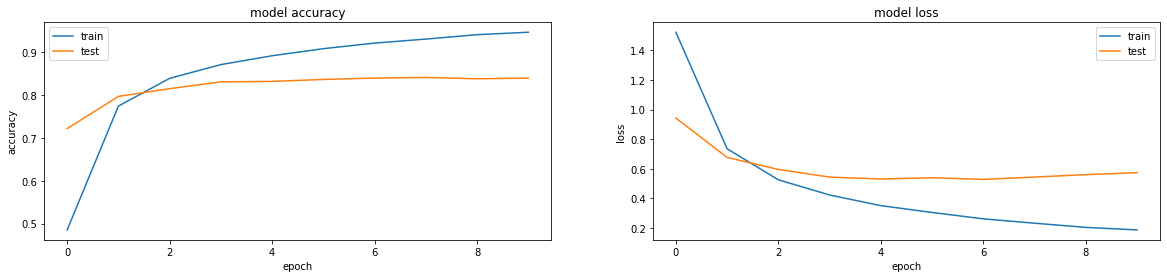

46/46 [==============================] - 0s 7ms/step


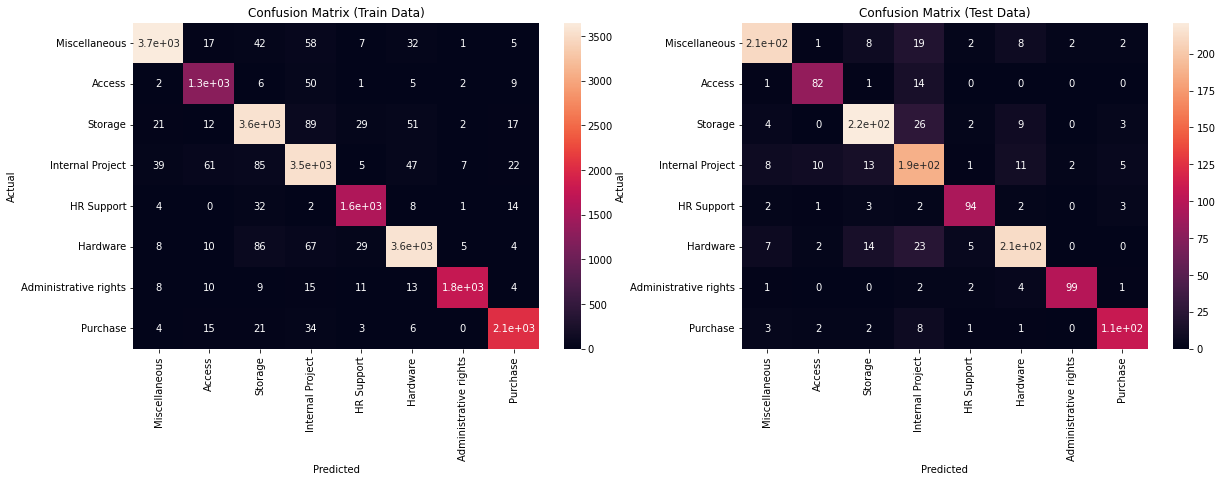

Train Data:
--------------------------------------------------------
                       precision    recall  f1-score   support

        Miscellaneous       0.96      0.98      0.97      3737
               Access       0.94      0.91      0.93      1387
              Storage       0.94      0.93      0.93      3834
     Internal Project       0.93      0.92      0.92      3860
           HR Support       0.96      0.95      0.96      1656
             Hardware       0.94      0.96      0.95      3729
Administrative rights       0.96      0.99      0.98      1800
             Purchase       0.96      0.96      0.96      2128

             accuracy                           0.95     22131
            macro avg       0.95      0.95      0.95     22131
         weighted avg       0.95      0.95      0.95     22131


Test Data:
--------------------------------------------------------
                       precision    recall  f1-score   support

        Miscellaneous       0.83      0

In [ ]:
model_LSTM.load_weights("best_checkpoint_4b_bilstm")

# Evaluate on test data
model_LSTM.evaluate(x=test_text, y=test_labels)

# Display Training History
display_training_loss_and_accuracy(history_spec_LSTM)

# Display confusion matrix & classification report
display_classification_confusion_matrix(model_LSTM, train_text, train_labels, test_text, test_labels, unique_categories)

Some degree of overfitting observed. To attempt some regularisation techniques in the next run.

### 4C. Build Bidirectional LSTM model with Dense & Dropout layer
- Bidirectional LSTM (64, tanh) 
- Dropout (0.5)
- Dense (128, relu)
- Dropout (0.5)

In [ ]:
EMBEDDING_DIM=128

inputs = keras.Input(shape=(MAX_SEQUENCE_LENGTH,))

embedded = keras.layers.Embedding(input_dim=VOCAB_SIZE, 
                                  output_dim=EMBEDDING_DIM, 
                                  mask_zero=True)(inputs)

# LSTM Example:
x = keras.layers.Bidirectional(keras.layers.LSTM(64))(embedded)
x = keras.layers.Dropout(0.5)(x)
x = keras.layers.Dense(128, activation='relu')(x)
x = keras.layers.Dropout(0.5)(x)
outputs = keras.layers.Dense(8, activation='softmax')(x)   # 8 categories

model_LSTM = keras.Model(inputs, outputs)

model_LSTM.compile(optimizer=keras.optimizers.Adam(1e-4),
              loss=keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

model_LSTM.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 200)]             0         
                                                                 
 embedding_5 (Embedding)     (None, 200, 128)          1227392   
                                                                 
 bidirectional_5 (Bidirectio  (None, 128)              98816     
 nal)                                                            
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_10 (Dense)            (None, 128)               16512     
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                           

In [ ]:
history_spec_LSTM = model_LSTM.fit(
    train_text, 
    train_labels,
    validation_data=(val_text, val_labels),
    epochs=10, 
    batch_size=32,
    callbacks=[save_best_model('best_checkpoint_4C_bilstm')])

Epoch 1/10
692/692 [==============================] - 66s 82ms/step - loss: 1.8028 - accuracy: 0.2929 - val_loss: 1.3389 - val_accuracy: 0.4798
Epoch 2/10
692/692 [==============================] - 24s 35ms/step - loss: 1.1622 - accuracy: 0.5563 - val_loss: 0.9309 - val_accuracy: 0.6922
Epoch 3/10
692/692 [==============================] - 20s 28ms/step - loss: 0.8260 - accuracy: 0.7255 - val_loss: 0.7177 - val_accuracy: 0.7871
Epoch 4/10
692/692 [==============================] - 18s 26ms/step - loss: 0.6453 - accuracy: 0.8023 - val_loss: 0.6258 - val_accuracy: 0.8126
Epoch 5/10
692/692 [==============================] - 21s 30ms/step - loss: 0.5409 - accuracy: 0.8391 - val_loss: 0.6039 - val_accuracy: 0.8184
Epoch 6/10
692/692 [==============================] - 18s 26ms/step - loss: 0.4655 - accuracy: 0.8649 - val_loss: 0.5823 - val_accuracy: 0.8223
Epoch 7/10
692/692 [==============================] - 20s 29ms/step - loss: 0.4242 - accuracy: 0.8785 - val_loss: 0.5663 - val_accuracy:

46/46 [==============================] - 0s 9ms/step - loss: 0.5994 - accuracy: 0.8352


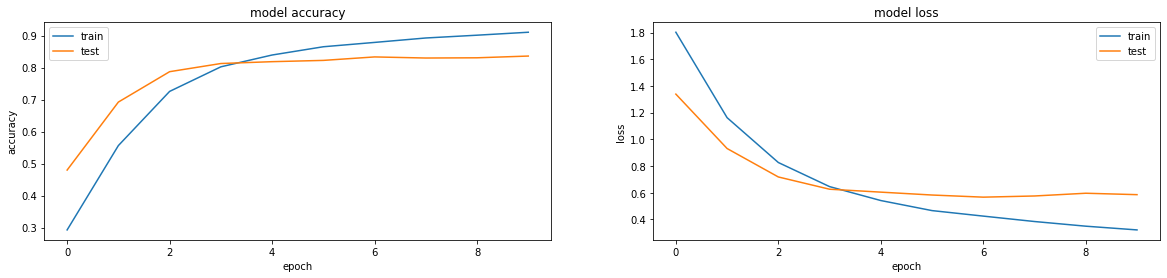

46/46 [==============================] - 0s 7ms/step


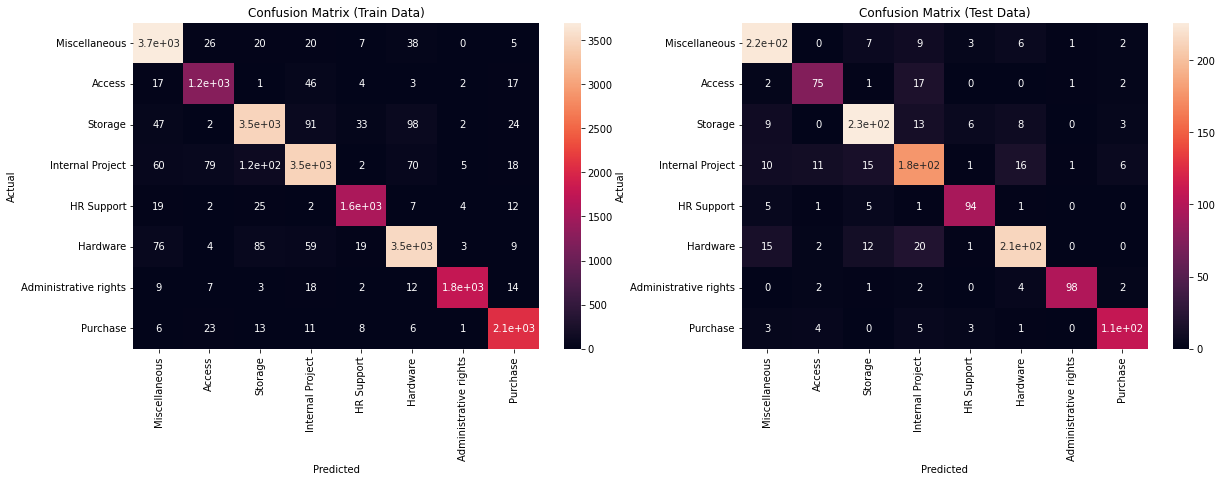

Train Data:
--------------------------------------------------------
                       precision    recall  f1-score   support

        Miscellaneous       0.97      0.94      0.95      3931
               Access       0.93      0.90      0.91      1390
              Storage       0.92      0.93      0.93      3741
     Internal Project       0.91      0.93      0.92      3707
           HR Support       0.96      0.95      0.96      1636
             Hardware       0.93      0.94      0.94      3755
Administrative rights       0.96      0.99      0.98      1804
             Purchase       0.97      0.95      0.96      2167

             accuracy                           0.94     22131
            macro avg       0.94      0.94      0.94     22131
         weighted avg       0.94      0.94      0.94     22131


Test Data:
--------------------------------------------------------
                       precision    recall  f1-score   support

        Miscellaneous       0.89      0

In [ ]:
model_LSTM.load_weights("best_checkpoint_4C_bilstm")

# Evaluate on test data
model_LSTM.evaluate(x=test_text, y=test_labels)

# Display Training History
display_training_loss_and_accuracy(history_spec_LSTM)

# Display confusion matrix & classification report
display_classification_confusion_matrix(model_LSTM, train_text, train_labels, test_text, test_labels, unique_categories)

Slightly less overfitting, testing accuracy improved slightly.

Compared to standard LSTM (run 2B), the test accuracy improved significantly. However, variance has also increased suggesting slight overfitting, likely because biLSTM is a more complex model.


### 4D. Build Bidirectional LSTM model with Dense & Dropout layer
- Bidirectional LSTM (128, tanh) 
- Dropout (0.5)
- Dense (128, relu)
- Dropout (0.5)

With 7 epochs

In [ ]:
EMBEDDING_DIM=128

inputs = keras.Input(shape=(MAX_SEQUENCE_LENGTH,))

embedded = keras.layers.Embedding(input_dim=VOCAB_SIZE, 
                                  output_dim=EMBEDDING_DIM, 
                                  mask_zero=True)(inputs)

# LSTM Example:
x = keras.layers.Bidirectional(keras.layers.LSTM(128))(embedded)
x = keras.layers.Dropout(0.5)(x)
x = keras.layers.Dense(128, activation='relu')(x)
x = keras.layers.Dropout(0.5)(x)
outputs = keras.layers.Dense(8, activation='softmax')(x)   # 8 categories

model_LSTM = keras.Model(inputs, outputs)

model_LSTM.compile(optimizer=keras.optimizers.Adam(1e-4),
              loss=keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

model_LSTM.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 200)]             0         
                                                                 
 embedding (Embedding)       (None, 200, 128)          1226240   
                                                                 
 bidirectional (Bidirectiona  (None, 256)              263168    
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense (Dense)               (None, 128)               32896     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                             

In [ ]:
history_spec_LSTM = model_LSTM.fit(
    train_text, 
    train_labels,
    validation_data=(val_text, val_labels),
    epochs=6, 
    batch_size=32,
    callbacks=[save_best_model('best_checkpoint_4D_bilstm')])

Epoch 1/7
692/692 [==============================] - 88s 103ms/step - loss: 1.7471 - accuracy: 0.3153 - val_loss: 1.2208 - val_accuracy: 0.5626
Epoch 2/7
692/692 [==============================] - 28s 40ms/step - loss: 1.0430 - accuracy: 0.6277 - val_loss: 0.8389 - val_accuracy: 0.7280
Epoch 3/7
692/692 [==============================] - 20s 29ms/step - loss: 0.7065 - accuracy: 0.7787 - val_loss: 0.6066 - val_accuracy: 0.8124
Epoch 4/7
692/692 [==============================] - 21s 30ms/step - loss: 0.5317 - accuracy: 0.8433 - val_loss: 0.5598 - val_accuracy: 0.8263
Epoch 5/7
692/692 [==============================] - 19s 28ms/step - loss: 0.4418 - accuracy: 0.8701 - val_loss: 0.5420 - val_accuracy: 0.8330
Epoch 6/7
692/692 [==============================] - 23s 33ms/step - loss: 0.3826 - accuracy: 0.8881 - val_loss: 0.5181 - val_accuracy: 0.8343
Epoch 7/7
692/692 [==============================] - 18s 26ms/step - loss: 0.3389 - accuracy: 0.9028 - val_loss: 0.5249 - val_accuracy: 0.836

46/46 [==============================] - 0s 10ms/step - loss: 0.5185 - accuracy: 0.8372


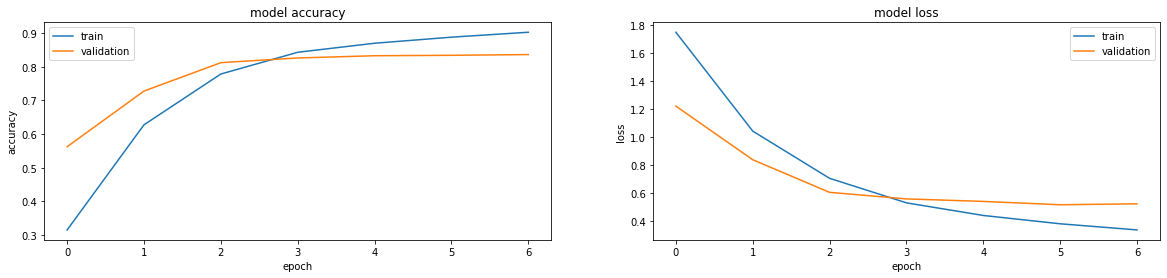

46/46 [==============================] - 0s 10ms/step


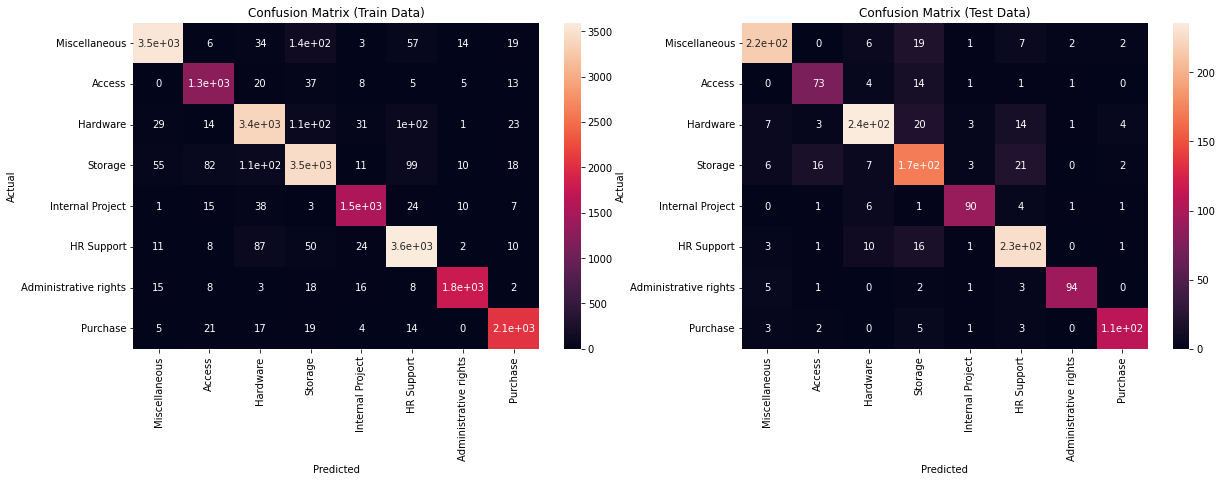

Train Data:
--------------------------------------------------------
                       precision    recall  f1-score   support

        Miscellaneous       0.93      0.97      0.95      3665
               Access       0.93      0.89      0.91      1408
             Hardware       0.92      0.92      0.92      3702
              Storage       0.90      0.90      0.90      3828
     Internal Project       0.94      0.94      0.94      1639
           HR Support       0.95      0.92      0.93      3905
Administrative rights       0.96      0.98      0.97      1830
             Purchase       0.96      0.96      0.96      2154

             accuracy                           0.93     22131
            macro avg       0.94      0.93      0.94     22131
         weighted avg       0.93      0.93      0.93     22131


Test Data:
--------------------------------------------------------
                       precision    recall  f1-score   support

        Miscellaneous       0.85      0

In [ ]:
model_LSTM.load_weights("best_checkpoint_4D_bilstm")

# Evaluate on test data
model_LSTM.evaluate(x=test_text, y=test_labels)

# Display Training History
display_training_loss_and_accuracy(history_spec_LSTM)

# Display confusion matrix & classification report
display_classification_confusion_matrix(model_LSTM, train_text, train_labels, test_text, test_labels, unique_categories)

Variance has decreased slightly but still sizable, also with slight improvement in the testing accuracy.
Attempt to reduce variance further by having fewer epochs.

### 4E. Build Bidirectional LSTM model with Dense & Dropout layer
- Bidirectional LSTM (128, tanh) 
- Dropout (0.5)
- Dense (128, relu)
- Dropout (0.5)

With 6 epochs

In [ ]:
EMBEDDING_DIM=128

inputs = keras.Input(shape=(MAX_SEQUENCE_LENGTH,))

embedded = keras.layers.Embedding(input_dim=VOCAB_SIZE, 
                                  output_dim=EMBEDDING_DIM, 
                                  mask_zero=True)(inputs)

# LSTM Example:
x = keras.layers.Bidirectional(keras.layers.LSTM(128))(embedded)
x = keras.layers.Dropout(0.5)(x)
x = keras.layers.Dense(128, activation='relu')(x)
x = keras.layers.Dropout(0.5)(x)
outputs = keras.layers.Dense(8, activation='softmax')(x)   # 8 categories

model_LSTM = keras.Model(inputs, outputs)

model_LSTM.compile(optimizer=keras.optimizers.Adam(1e-4),
              loss=keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

model_LSTM.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 200)]             0         
                                                                 
 embedding_1 (Embedding)     (None, 200, 128)          1226240   
                                                                 
 bidirectional_1 (Bidirectio  (None, 256)              263168    
 nal)                                                            
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                           

In [ ]:
history_spec_LSTM = model_LSTM.fit(
    train_text, 
    train_labels,
    validation_data=(val_text, val_labels),
    epochs=6, 
    batch_size=32,
    callbacks=[save_best_model('best_checkpoint_4E_bilstm')])

Epoch 1/6
692/692 [==============================] - 65s 75ms/step - loss: 1.7147 - accuracy: 0.3355 - val_loss: 1.1017 - val_accuracy: 0.6477
Epoch 2/6
692/692 [==============================] - 28s 40ms/step - loss: 0.9121 - accuracy: 0.7128 - val_loss: 0.6934 - val_accuracy: 0.7900
Epoch 3/6
692/692 [==============================] - 21s 30ms/step - loss: 0.6270 - accuracy: 0.8134 - val_loss: 0.5785 - val_accuracy: 0.8169
Epoch 4/6
692/692 [==============================] - 19s 27ms/step - loss: 0.5029 - accuracy: 0.8530 - val_loss: 0.5378 - val_accuracy: 0.8364
Epoch 5/6
692/692 [==============================] - 19s 28ms/step - loss: 0.4248 - accuracy: 0.8760 - val_loss: 0.5395 - val_accuracy: 0.8325
Epoch 6/6
692/692 [==============================] - 19s 27ms/step - loss: 0.3746 - accuracy: 0.8907 - val_loss: 0.5271 - val_accuracy: 0.8372


46/46 [==============================] - 1s 12ms/step - loss: 0.5247 - accuracy: 0.8324


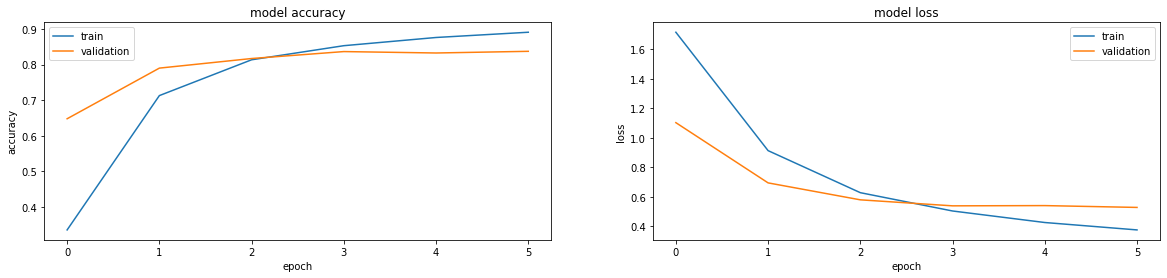

46/46 [==============================] - 1s 16ms/step


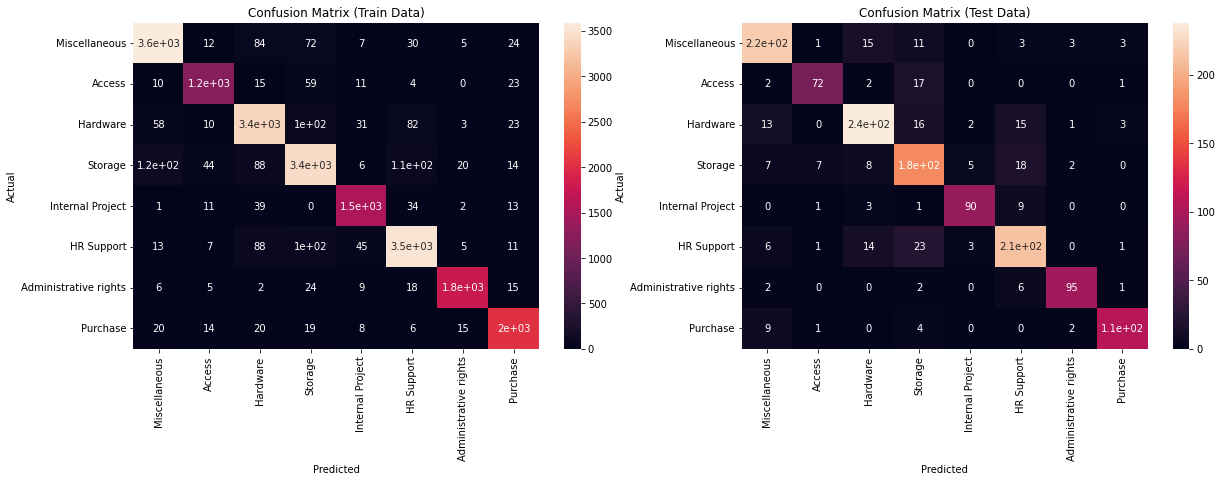

Train Data:
--------------------------------------------------------
                       precision    recall  f1-score   support

        Miscellaneous       0.94      0.94      0.94      3814
               Access       0.91      0.92      0.92      1323
             Hardware       0.92      0.91      0.91      3727
              Storage       0.90      0.90      0.90      3819
     Internal Project       0.94      0.93      0.93      1657
           HR Support       0.93      0.93      0.93      3799
Administrative rights       0.96      0.97      0.97      1829
             Purchase       0.95      0.94      0.95      2163

             accuracy                           0.93     22131
            macro avg       0.93      0.93      0.93     22131
         weighted avg       0.93      0.93      0.93     22131


Test Data:
--------------------------------------------------------
                       precision    recall  f1-score   support

        Miscellaneous       0.86      0

In [ ]:
model_LSTM.load_weights("best_checkpoint_4E_bilstm")

# Evaluate on test data
model_LSTM.evaluate(x=test_text, y=test_labels)

# Display Training History
display_training_loss_and_accuracy(history_spec_LSTM)

# Display confusion matrix & classification report
display_classification_confusion_matrix(model_LSTM, train_text, train_labels, test_text, test_labels, unique_categories)

Variance is lower when ran with fewer epochs. Validation accuracy is similar but testing accuracy is also slightly lower.

### 4F. Build Bidirectional LSTM model with Dense & Dropout layer
- Bidirectional LSTM (128, tanh) 
- Dropout (0.5)
- Dense (**256**, relu)
- Dropout (0.5)

In [ ]:
EMBEDDING_DIM=128

inputs = keras.Input(shape=(MAX_SEQUENCE_LENGTH,))

embedded = keras.layers.Embedding(input_dim=VOCAB_SIZE, 
                                  output_dim=EMBEDDING_DIM, 
                                  mask_zero=True)(inputs)

# LSTM Example:
x = keras.layers.Bidirectional(keras.layers.LSTM(128))(embedded)
x = keras.layers.Dropout(0.5)(x)
x = keras.layers.Dense(256, activation='relu')(x)
x = keras.layers.Dropout(0.5)(x)
outputs = keras.layers.Dense(8, activation='softmax')(x)   # 8 categories

model_LSTM = keras.Model(inputs, outputs)

model_LSTM.compile(optimizer=keras.optimizers.Adam(1e-4),
              loss=keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

model_LSTM.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 200)]             0         
                                                                 
 embedding_3 (Embedding)     (None, 200, 128)          1226240   
                                                                 
 bidirectional_3 (Bidirectio  (None, 256)              263168    
 nal)                                                            
                                                                 
 dropout_6 (Dropout)         (None, 256)               0         
                                                                 
 dense_6 (Dense)             (None, 256)               65792     
                                                                 
 dropout_7 (Dropout)         (None, 256)               0         
                                                           

In [ ]:
history_spec_LSTM = model_LSTM.fit(
    train_text, 
    train_labels,
    validation_data=(val_text, val_labels),
    epochs=6, 
    batch_size=32,
    callbacks=[save_best_model('best_checkpoint_4F_bilstm')])

Epoch 1/6
692/692 [==============================] - 72s 83ms/step - loss: 1.6944 - accuracy: 0.3449 - val_loss: 1.1358 - val_accuracy: 0.6318
Epoch 2/6
692/692 [==============================] - 22s 32ms/step - loss: 0.8964 - accuracy: 0.7058 - val_loss: 0.7114 - val_accuracy: 0.7875
Epoch 3/6
692/692 [==============================] - 20s 29ms/step - loss: 0.5984 - accuracy: 0.8151 - val_loss: 0.5693 - val_accuracy: 0.8184
Epoch 4/6
692/692 [==============================] - 19s 28ms/step - loss: 0.4692 - accuracy: 0.8577 - val_loss: 0.5216 - val_accuracy: 0.8348
Epoch 5/6
692/692 [==============================] - 20s 29ms/step - loss: 0.3892 - accuracy: 0.8855 - val_loss: 0.5090 - val_accuracy: 0.8399
Epoch 6/6
692/692 [==============================] - 17s 25ms/step - loss: 0.3285 - accuracy: 0.9008 - val_loss: 0.5058 - val_accuracy: 0.8435


46/46 [==============================] - 0s 7ms/step - loss: 0.5041 - accuracy: 0.8413


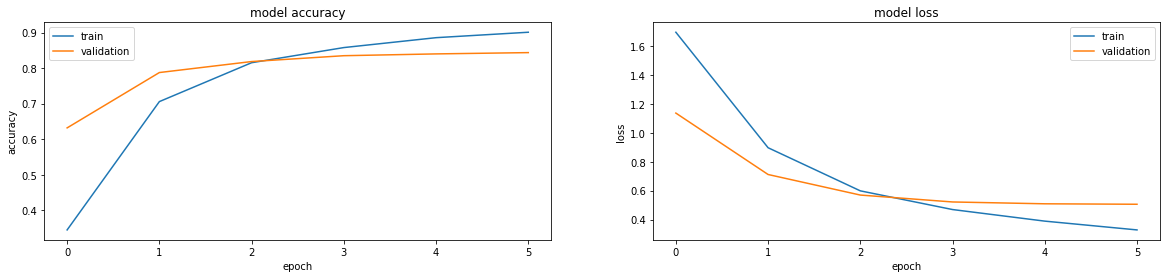

46/46 [==============================] - 0s 9ms/step


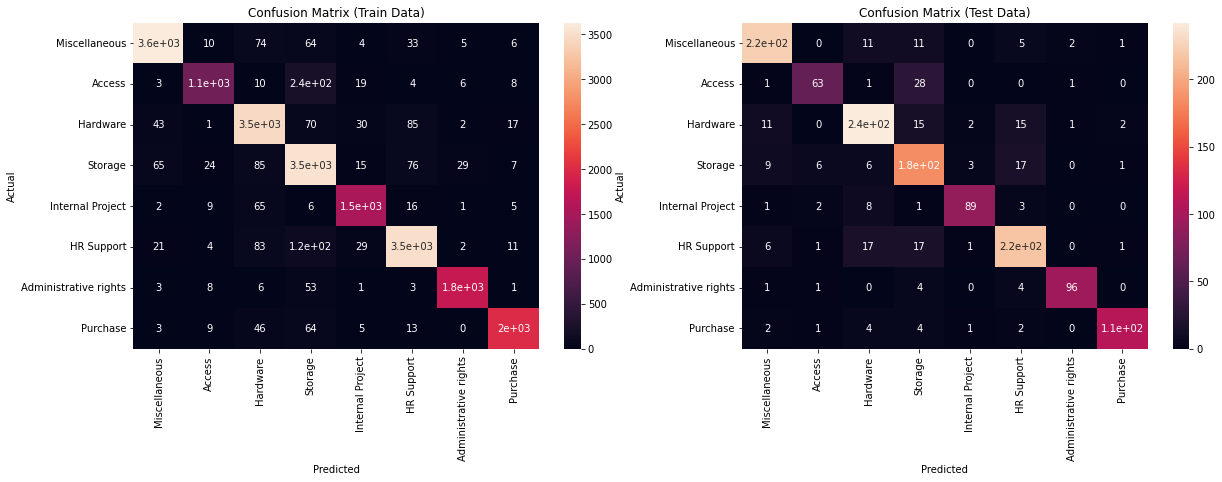

Train Data:
--------------------------------------------------------
                       precision    recall  f1-score   support

        Miscellaneous       0.95      0.96      0.96      3768
               Access       0.78      0.94      0.86      1117
             Hardware       0.93      0.90      0.92      3820
              Storage       0.92      0.85      0.88      4160
     Internal Project       0.94      0.94      0.94      1639
           HR Support       0.93      0.94      0.93      3742
Administrative rights       0.96      0.98      0.97      1828
             Purchase       0.93      0.97      0.95      2057

             accuracy                           0.93     22131
            macro avg       0.92      0.94      0.93     22131
         weighted avg       0.93      0.93      0.93     22131


Test Data:
--------------------------------------------------------
                       precision    recall  f1-score   support

        Miscellaneous       0.88      0

In [ ]:
model_LSTM.load_weights("best_checkpoint_4F_bilstm")

# Evaluate on test data
model_LSTM.evaluate(x=test_text, y=test_labels)

# Display Training History
display_training_loss_and_accuracy(history_spec_LSTM)

# Display confusion matrix & classification report
display_classification_confusion_matrix(model_LSTM, train_text, train_labels, test_text, test_labels, unique_categories)

Similar variance, but testing accuracy also increased.
However, "Access" & "Storage" tended to perform poorly with lower F1 score.

### 4G. Build Bidirectional LSTM model with multiple Dense & Dropout layers
- Bidirectional LSTM (128, tanh) 
- Dropout (0.5)
- Dense (256, relu)
- Dropout (0.5)
- Dense (256, relu)
- Dropout (0.5)

In [ ]:
EMBEDDING_DIM=128

inputs = keras.Input(shape=(MAX_SEQUENCE_LENGTH,))

embedded = keras.layers.Embedding(input_dim=VOCAB_SIZE, 
                                  output_dim=EMBEDDING_DIM, 
                                  mask_zero=True)(inputs)

# LSTM Example:
x = keras.layers.Bidirectional(keras.layers.LSTM(128))(embedded)
x = keras.layers.Dropout(0.5)(x)
x = keras.layers.Dense(256, activation='relu')(x)
x = keras.layers.Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = keras.layers.Dense(8, activation='softmax')(x)   # 8 categories

model_LSTM = keras.Model(inputs, outputs)

model_LSTM.compile(optimizer=keras.optimizers.Adam(1e-4),
              loss=keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

model_LSTM.summary()

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 200)]             0         
                                                                 
 embedding_8 (Embedding)     (None, 200, 128)          1226240   
                                                                 
 bidirectional_8 (Bidirectio  (None, 256)              263168    
 nal)                                                            
                                                                 
 dropout_20 (Dropout)        (None, 256)               0         
                                                                 
 dense_20 (Dense)            (None, 256)               65792     
                                                                 
 dropout_21 (Dropout)        (None, 256)               0         
                                                           

In [ ]:
history_spec_LSTM = model_LSTM.fit(
    train_text, 
    train_labels,
    validation_data=(val_text, val_labels),
    epochs=5, 
    batch_size=32,
    callbacks=[save_best_model('best_checkpoint_4G_bilstm')])

Epoch 1/5
692/692 [==============================] - 61s 75ms/step - loss: 1.7715 - accuracy: 0.2587 - val_loss: 1.3028 - val_accuracy: 0.5433
Epoch 2/5
692/692 [==============================] - 23s 34ms/step - loss: 0.9568 - accuracy: 0.6643 - val_loss: 0.6622 - val_accuracy: 0.7853
Epoch 3/5
692/692 [==============================] - 19s 28ms/step - loss: 0.6094 - accuracy: 0.8062 - val_loss: 0.5847 - val_accuracy: 0.8113
Epoch 4/5
692/692 [==============================] - 20s 29ms/step - loss: 0.4869 - accuracy: 0.8516 - val_loss: 0.5421 - val_accuracy: 0.8258
Epoch 5/5
692/692 [==============================] - 19s 28ms/step - loss: 0.4051 - accuracy: 0.8780 - val_loss: 0.5589 - val_accuracy: 0.8290


46/46 [==============================] - 0s 10ms/step - loss: 0.5363 - accuracy: 0.8276


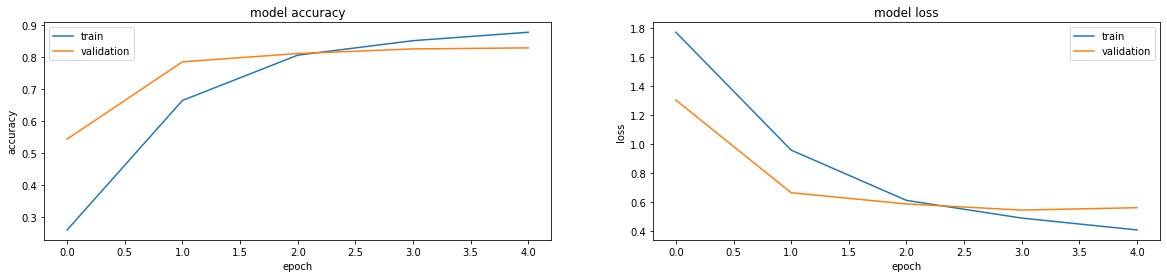

46/46 [==============================] - 0s 7ms/step


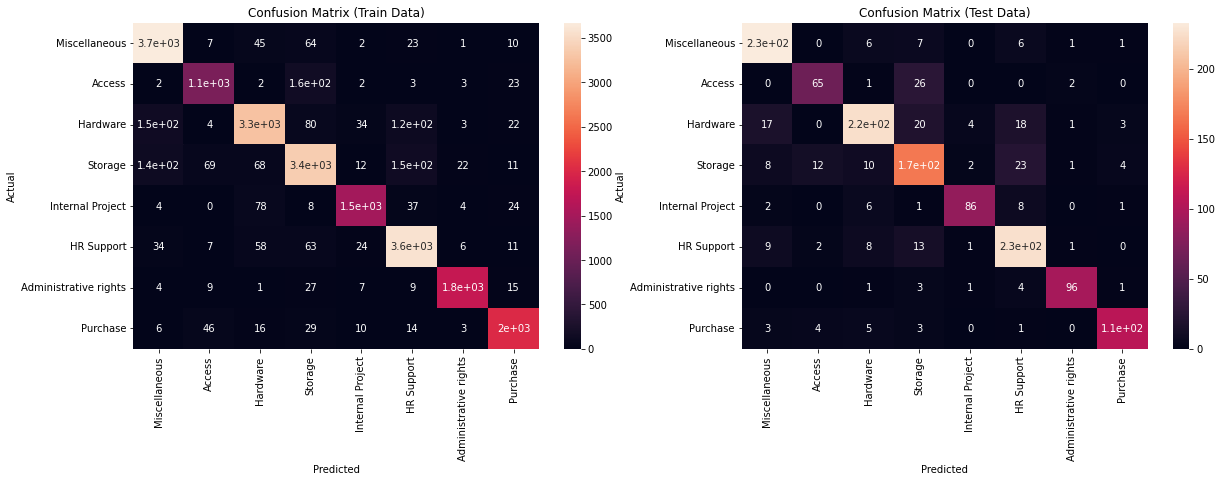

Train Data:
--------------------------------------------------------
                       precision    recall  f1-score   support

        Miscellaneous       0.96      0.92      0.94      4008
               Access       0.85      0.89      0.87      1285
             Hardware       0.89      0.92      0.91      3552
              Storage       0.88      0.89      0.88      3808
     Internal Project       0.91      0.94      0.92      1576
           HR Support       0.95      0.91      0.93      3940
Administrative rights       0.96      0.98      0.97      1828
             Purchase       0.94      0.95      0.94      2134

             accuracy                           0.92     22131
            macro avg       0.92      0.92      0.92     22131
         weighted avg       0.92      0.92      0.92     22131


Test Data:
--------------------------------------------------------
                       precision    recall  f1-score   support

        Miscellaneous       0.92      0

In [ ]:
model_LSTM.load_weights("best_checkpoint_4G_bilstm")

# Evaluate on test data
model_LSTM.evaluate(x=test_text, y=test_labels)

# Display Training History
display_training_loss_and_accuracy(history_spec_LSTM)

# Display confusion matrix & classification report
display_classification_confusion_matrix(model_LSTM, train_text, train_labels, test_text, test_labels, unique_categories)

Slightly lower variance, due to fewer epochs being run. However, adding a pair of dense+dropout layer did not seem to have much effect on the accuracy, which is lower than the previous run.

F1-score of  "Access" & "Storage" tends to be the poorest among the categories (0.73).

## 5. Bidirectional GRU

### 5A. Build Bidirectional GRU model with Dense layer

- Bidirectional GRU (64, tanh) 
- Dense (128, relu)

In [ ]:
EMBEDDING_DIM=128

inputs = keras.Input(shape=(MAX_SEQUENCE_LENGTH,))

embedded = keras.layers.Embedding(input_dim=VOCAB_SIZE, 
                                  output_dim=EMBEDDING_DIM, 
                                  mask_zero=True)(inputs)

# GRU Example:
x = keras.layers.Bidirectional(keras.layers.GRU(64))(embedded) # default tanh activation fn
x = Dense(128, activation='relu')(x)
outputs = keras.layers.Dense(8, activation='softmax')(x)   # 8 categories

model_GRU = keras.Model(inputs, outputs)

model_GRU.compile(optimizer=keras.optimizers.Adam(1e-4),
              loss=keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

model_GRU.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 200)]             0         
                                                                 
 embedding_1 (Embedding)     (None, 200, 128)          1233024   
                                                                 
 bidirectional (Bidirectiona  (None, 128)              74496     
 l)                                                              
                                                                 
 dense (Dense)               (None, 128)               16512     
                                                                 
 dense_1 (Dense)             (None, 8)                 1032      
                                                                 
Total params: 1,325,064
Trainable params: 1,325,064
Non-trainable params: 0
___________________________________________________

In [ ]:
history_spec_GRU = model_GRU.fit(
    train_text, 
    train_labels,
    validation_data=(val_text, val_labels),
    epochs=10, 
    batch_size=32,
    callbacks=[save_best_model('best_checkpoint_5A_bilstm')])

Epoch 1/10
692/692 [==============================] - 81s 98ms/step - loss: 1.5561 - accuracy: 0.4686 - val_loss: 0.8927 - val_accuracy: 0.7303
Epoch 2/10
692/692 [==============================] - 28s 40ms/step - loss: 0.6699 - accuracy: 0.7945 - val_loss: 0.6121 - val_accuracy: 0.8068
Epoch 3/10
692/692 [==============================] - 24s 35ms/step - loss: 0.4730 - accuracy: 0.8529 - val_loss: 0.5586 - val_accuracy: 0.8205
Epoch 4/10
692/692 [==============================] - 19s 27ms/step - loss: 0.3879 - accuracy: 0.8816 - val_loss: 0.5476 - val_accuracy: 0.8269
Epoch 5/10
692/692 [==============================] - 18s 26ms/step - loss: 0.3320 - accuracy: 0.8985 - val_loss: 0.5697 - val_accuracy: 0.8241
Epoch 6/10
692/692 [==============================] - 19s 27ms/step - loss: 0.2953 - accuracy: 0.9119 - val_loss: 0.5857 - val_accuracy: 0.8279
Epoch 7/10
692/692 [==============================] - 17s 25ms/step - loss: 0.2562 - accuracy: 0.9221 - val_loss: 0.5955 - val_accuracy:

46/46 [==============================] - 0s 8ms/step - loss: 0.5798 - accuracy: 0.8359


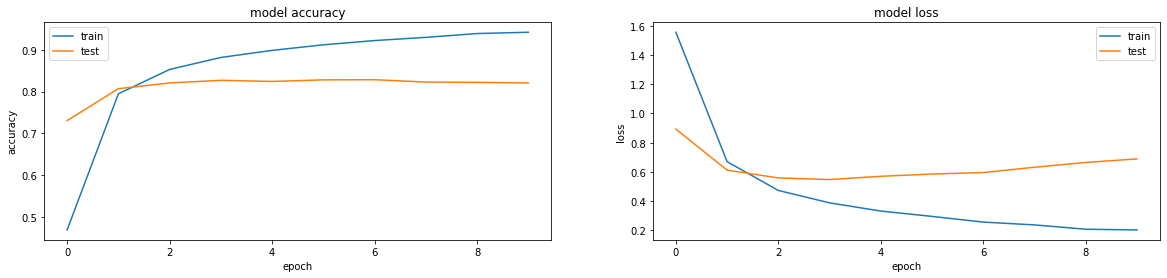

46/46 [==============================] - 0s 6ms/step


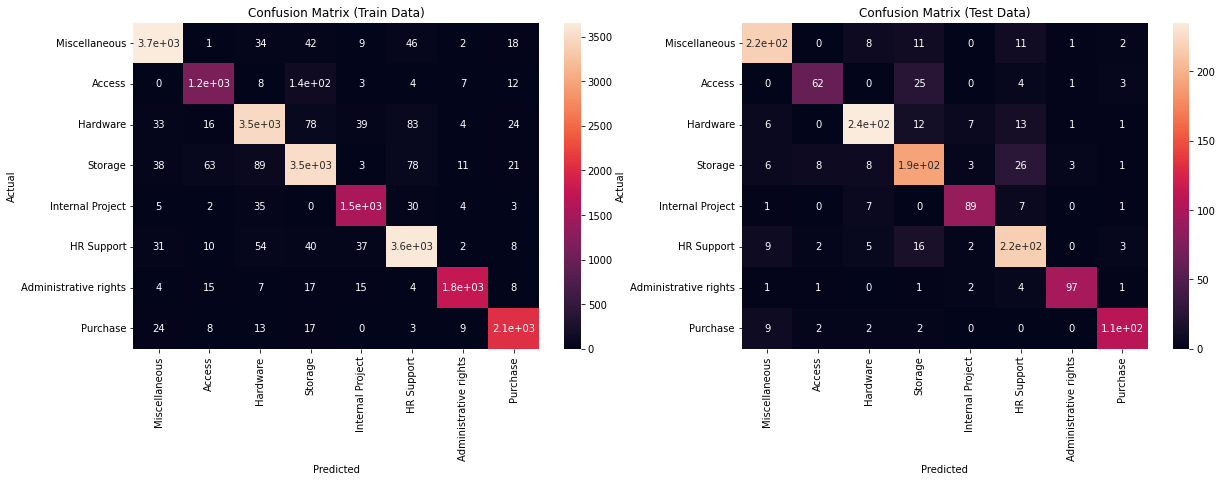

Train Data:
--------------------------------------------------------
                       precision    recall  f1-score   support

        Miscellaneous       0.96      0.96      0.96      3791
               Access       0.87      0.91      0.89      1271
             Hardware       0.93      0.94      0.93      3717
              Storage       0.92      0.91      0.92      3861
     Internal Project       0.95      0.94      0.94      1655
           HR Support       0.95      0.94      0.94      3863
Administrative rights       0.96      0.98      0.97      1817
             Purchase       0.97      0.96      0.96      2156

             accuracy                           0.94     22131
            macro avg       0.94      0.94      0.94     22131
         weighted avg       0.94      0.94      0.94     22131


Test Data:
--------------------------------------------------------
                       precision    recall  f1-score   support

        Miscellaneous       0.87      0

In [ ]:
model_GRU.load_weights("best_checkpoint_5A_bilstm")

# Evaluate on test data
model_GRU.evaluate(x=test_text, y=test_labels)

# Display Training History
display_training_loss_and_accuracy(history_spec_GRU)

# Display confusion matrix & classification report
display_classification_confusion_matrix(model_GRU, train_text, train_labels, test_text, test_labels, unique_categories)

Testing accuracy was 83.5%. However, significant overfitting was observed. Validation accuracy did not change much after 4 epochs.

To attempt regularisation techniques by applying dropout layers. Reduce number of epochs.

Application of GRU has also led to a decrease in the F1-score especially for the "Access", "Storage" & "HR Support" categories. This may suggest that this GRU model is too simple to accurately classify these categories. 

To increase number of weights while concurrently applying dropout layers.

### 5B. Build Bidirectional GRU model with Dense & Dropout layers

- Bidirectional GRU (128, tanh) 
- Dropout (0.5)
- Dense (128, relu)
- Dropout (0.5)

In [ ]:
EMBEDDING_DIM=128

inputs = keras.Input(shape=(MAX_SEQUENCE_LENGTH,))

embedded = keras.layers.Embedding(input_dim=VOCAB_SIZE, 
                                  output_dim=EMBEDDING_DIM, 
                                  mask_zero=True)(inputs)

# GRU Example:
x = keras.layers.Bidirectional(keras.layers.GRU(128))(embedded)
x = keras.layers.Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = keras.layers.Dense(8, activation='softmax')(x)   # 8 categories

model_GRU = keras.Model(inputs, outputs)

model_GRU.compile(optimizer=keras.optimizers.Adam(1e-4),
              loss=keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

model_GRU.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 200)]             0         
                                                                 
 embedding_6 (Embedding)     (None, 200, 128)          1233024   
                                                                 
 bidirectional_4 (Bidirectio  (None, 256)              198144    
 nal)                                                            
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 dense_8 (Dense)             (None, 128)               32896     
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                           

In [ ]:
history_spec_GRU = model_GRU.fit(
    train_text, 
    train_labels,
    validation_data=(val_text, val_labels),
    epochs=5, 
    batch_size=32,
    callbacks=[save_best_model('best_checkpoint_5B_bilstm')])

Epoch 1/5
692/692 [==============================] - 66s 82ms/step - loss: 1.8141 - accuracy: 0.2863 - val_loss: 1.3726 - val_accuracy: 0.5489
Epoch 2/5
692/692 [==============================] - 24s 35ms/step - loss: 1.0084 - accuracy: 0.6702 - val_loss: 0.6913 - val_accuracy: 0.7864
Epoch 3/5
692/692 [==============================] - 26s 37ms/step - loss: 0.5917 - accuracy: 0.8137 - val_loss: 0.5631 - val_accuracy: 0.8169
Epoch 4/5
692/692 [==============================] - 20s 29ms/step - loss: 0.4642 - accuracy: 0.8549 - val_loss: 0.5342 - val_accuracy: 0.8254
Epoch 5/5
692/692 [==============================] - 20s 29ms/step - loss: 0.3905 - accuracy: 0.8798 - val_loss: 0.5478 - val_accuracy: 0.8310


46/46 [==============================] - 0s 9ms/step - loss: 0.5175 - accuracy: 0.8345


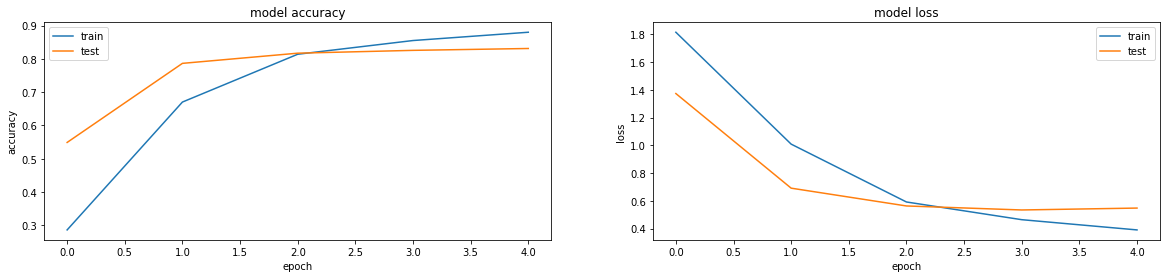

46/46 [==============================] - 0s 6ms/step


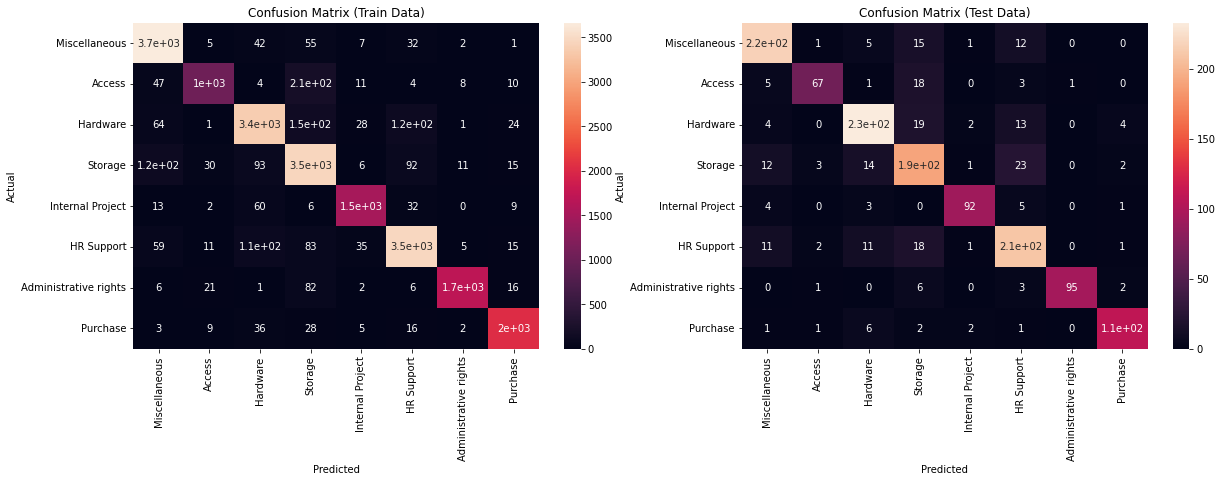

Train Data:
--------------------------------------------------------
                       precision    recall  f1-score   support

        Miscellaneous       0.96      0.92      0.94      3980
               Access       0.78      0.93      0.85      1117
             Hardware       0.90      0.91      0.90      3723
              Storage       0.90      0.85      0.88      4067
     Internal Project       0.93      0.94      0.93      1600
           HR Support       0.92      0.92      0.92      3774
Administrative rights       0.93      0.98      0.95      1743
             Purchase       0.95      0.96      0.96      2127

             accuracy                           0.92     22131
            macro avg       0.91      0.93      0.92     22131
         weighted avg       0.92      0.92      0.92     22131


Test Data:
--------------------------------------------------------
                       precision    recall  f1-score   support

        Miscellaneous       0.86      0

In [ ]:
model_GRU.load_weights("best_checkpoint_5B_bilstm")

# Evaluate on test data
model_GRU.evaluate(x=test_text, y=test_labels)

# Display Training History
display_training_loss_and_accuracy(history_spec_GRU)

# Display confusion matrix & classification report
display_classification_confusion_matrix(model_GRU, train_text, train_labels, test_text, test_labels, unique_categories)

Model performed better. Test accuracy remained similar at 83.45%. Regularisation (dropout layer & fewer epochs) helped in reducing the variance and overfitting.

### 5C. Build Bidirectional GRU model with Dense & Dropout layers

- Bidirectional GRU (128, tanh) 
- Dropout (0.5)
- Dense (**256**, relu)
- Dropout (0.5)

In [ ]:
EMBEDDING_DIM=128

inputs = keras.Input(shape=(MAX_SEQUENCE_LENGTH,))

embedded = keras.layers.Embedding(input_dim=VOCAB_SIZE, 
                                  output_dim=EMBEDDING_DIM, 
                                  mask_zero=True)(inputs)

# GRU Example:
x = keras.layers.Bidirectional(keras.layers.GRU(128))(embedded)
x = keras.layers.Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = keras.layers.Dense(8, activation='softmax')(x)   # 8 categories

model_GRU = keras.Model(inputs, outputs)

model_GRU.compile(optimizer=keras.optimizers.Adam(1e-4),
              loss=keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

model_GRU.summary()

Model: "model_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 200)]             0         
                                                                 
 embedding_11 (Embedding)    (None, 200, 128)          1226240   
                                                                 
 bidirectional_11 (Bidirecti  (None, 256)              198144    
 onal)                                                           
                                                                 
 dropout_27 (Dropout)        (None, 256)               0         
                                                                 
 dense_27 (Dense)            (None, 256)               65792     
                                                                 
 dropout_28 (Dropout)        (None, 256)               0         
                                                          

In [ ]:
history_spec_GRU = model_GRU.fit(
    train_text, 
    train_labels,
    validation_data=(val_text, val_labels),
    epochs=5, 
    batch_size=32,
    callbacks=[save_best_model('best_checkpoint_5C_bilstm')])

Epoch 1/5
692/692 [==============================] - 71s 86ms/step - loss: 1.7214 - accuracy: 0.3517 - val_loss: 1.0901 - val_accuracy: 0.6526
Epoch 2/5
692/692 [==============================] - 32s 46ms/step - loss: 0.7983 - accuracy: 0.7365 - val_loss: 0.6116 - val_accuracy: 0.8059
Epoch 3/5
692/692 [==============================] - 35s 50ms/step - loss: 0.5460 - accuracy: 0.8287 - val_loss: 0.5494 - val_accuracy: 0.8256
Epoch 4/5
692/692 [==============================] - 28s 41ms/step - loss: 0.4532 - accuracy: 0.8600 - val_loss: 0.5505 - val_accuracy: 0.8317
Epoch 5/5
692/692 [==============================] - 18s 27ms/step - loss: 0.3963 - accuracy: 0.8795 - val_loss: 0.5414 - val_accuracy: 0.8308


46/46 [==============================] - 0s 9ms/step - loss: 0.5405 - accuracy: 0.8262


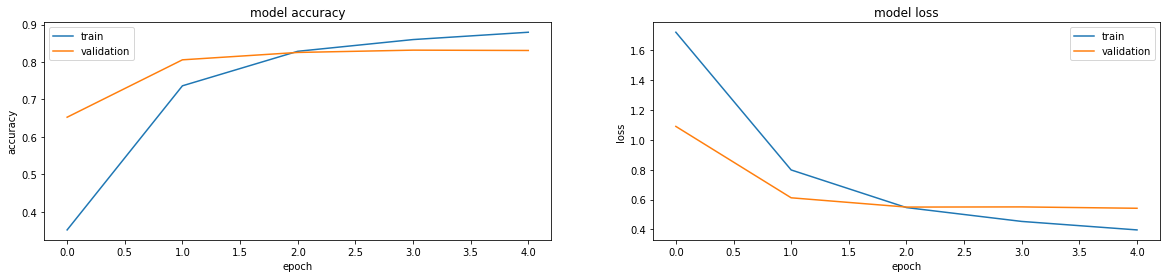

46/46 [==============================] - 0s 9ms/step


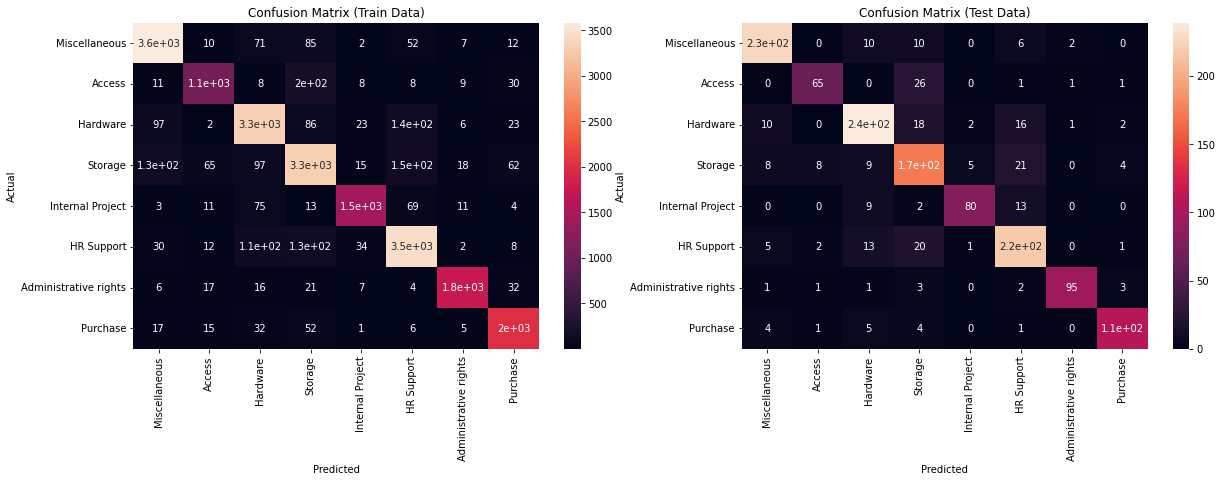

Train Data:
--------------------------------------------------------
                       precision    recall  f1-score   support

        Miscellaneous       0.94      0.92      0.93      3877
               Access       0.79      0.89      0.84      1198
             Hardware       0.90      0.89      0.89      3739
              Storage       0.86      0.85      0.85      3897
     Internal Project       0.89      0.94      0.91      1544
           HR Support       0.91      0.89      0.90      3878
Administrative rights       0.94      0.97      0.96      1813
             Purchase       0.94      0.92      0.93      2185

             accuracy                           0.90     22131
            macro avg       0.90      0.91      0.90     22131
         weighted avg       0.90      0.90      0.90     22131


Test Data:
--------------------------------------------------------
                       precision    recall  f1-score   support

        Miscellaneous       0.89      0

In [ ]:
model_GRU.load_weights("best_checkpoint_5C_bilstm")

# Evaluate on test data
model_GRU.evaluate(x=test_text, y=test_labels)

# Display Training History
display_training_loss_and_accuracy(history_spec_GRU)

# Display confusion matrix & classification report
display_classification_confusion_matrix(model_GRU, train_text, train_labels, test_text, test_labels, unique_categories)

Model did not perform better after increasing the number of weights of the Dense layer. There is lower variance but also lower testing accuracy.

The Access & Storage classes tend to be misclassified with low F1 score. Attempt to add an additional dense layer to better allow model to detect more complex patterns and observe if there is improvement.


### 5D. Build Bidirectional GRU model with multiple Dense & Dropout layers

- Bidirectional GRU (128, tanh) 
- Dropout (0.5)
- Dense (256, relu)
- Dropout (0.5)
- Dense (128, relu)
- Dropout (0.5)

In [ ]:
EMBEDDING_DIM=128

inputs = keras.Input(shape=(MAX_SEQUENCE_LENGTH,))

embedded = keras.layers.Embedding(input_dim=VOCAB_SIZE, 
                                  output_dim=EMBEDDING_DIM, 
                                  mask_zero=True)(inputs)

# GRU Example:
x = keras.layers.Bidirectional(keras.layers.GRU(128))(embedded)
x = keras.layers.Dropout(0.5)(x)
x = keras.layers.Dense(256, activation='relu')(x)
x = keras.layers.Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = keras.layers.Dense(8, activation='softmax')(x)   # 8 categories

model_GRU = keras.Model(inputs, outputs)

model_GRU.compile(optimizer=keras.optimizers.Adam(1e-4),
              loss=keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

model_GRU.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 200)]             0         
                                                                 
 embedding_7 (Embedding)     (None, 200, 128)          1233024   
                                                                 
 bidirectional_5 (Bidirectio  (None, 256)              198144    
 nal)                                                            
                                                                 
 dropout_4 (Dropout)         (None, 256)               0         
                                                                 
 dense_10 (Dense)            (None, 256)               65792     
                                                                 
 dropout_5 (Dropout)         (None, 256)               0         
                                                           

In [ ]:
history_spec_GRU = model_GRU.fit(
    train_text, 
    train_labels,
    validation_data=(val_text, val_labels),
    epochs=7, 
    batch_size=32,
    callbacks=[save_best_model('best_checkpoint_5D_bilstm')])

Epoch 1/7
692/692 [==============================] - 66s 76ms/step - loss: 1.8430 - accuracy: 0.2579 - val_loss: 1.3420 - val_accuracy: 0.5301
Epoch 2/7
692/692 [==============================] - 25s 36ms/step - loss: 1.0841 - accuracy: 0.6044 - val_loss: 0.7122 - val_accuracy: 0.7705
Epoch 3/7
692/692 [==============================] - 30s 44ms/step - loss: 0.6737 - accuracy: 0.7846 - val_loss: 0.6229 - val_accuracy: 0.7965
Epoch 4/7
692/692 [==============================] - 23s 33ms/step - loss: 0.5395 - accuracy: 0.8330 - val_loss: 0.5836 - val_accuracy: 0.8138
Epoch 5/7
692/692 [==============================] - 26s 38ms/step - loss: 0.4678 - accuracy: 0.8609 - val_loss: 0.5843 - val_accuracy: 0.8113
Epoch 6/7
692/692 [==============================] - 18s 26ms/step - loss: 0.4102 - accuracy: 0.8784 - val_loss: 0.5846 - val_accuracy: 0.8176
Epoch 7/7
692/692 [==============================] - 20s 28ms/step - loss: 0.3637 - accuracy: 0.8924 - val_loss: 0.5851 - val_accuracy: 0.8236

46/46 [==============================] - 0s 9ms/step - loss: 0.5519 - accuracy: 0.8386


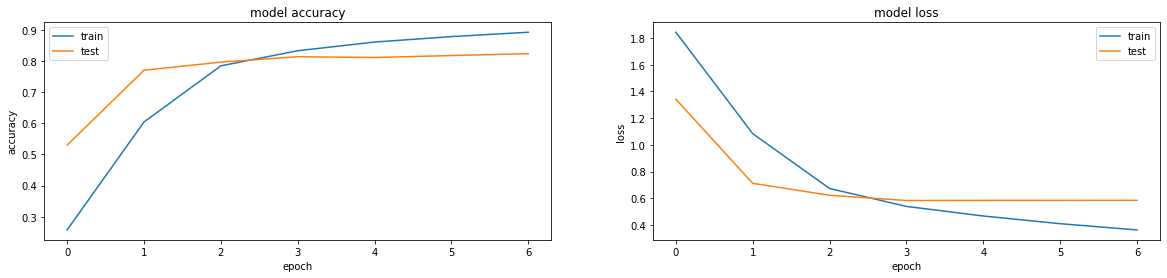

46/46 [==============================] - 0s 7ms/step


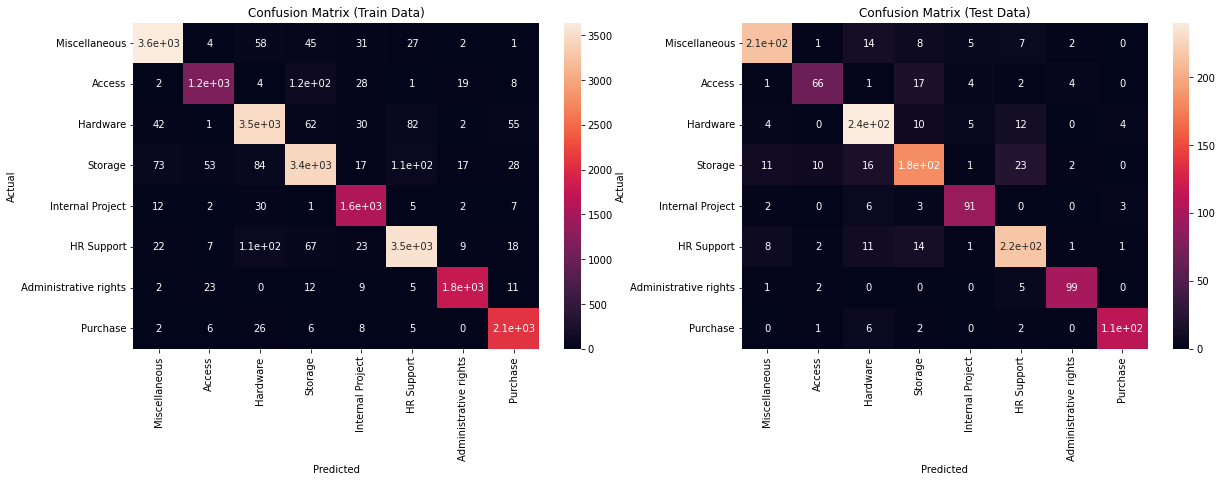

Train Data:
--------------------------------------------------------
                       precision    recall  f1-score   support

        Miscellaneous       0.96      0.96      0.96      3795
               Access       0.87      0.92      0.89      1252
             Hardware       0.93      0.92      0.92      3789
              Storage       0.90      0.92      0.91      3751
     Internal Project       0.96      0.91      0.94      1715
           HR Support       0.93      0.94      0.94      3781
Administrative rights       0.97      0.97      0.97      1837
             Purchase       0.98      0.94      0.96      2211

             accuracy                           0.94     22131
            macro avg       0.94      0.94      0.94     22131
         weighted avg       0.94      0.94      0.94     22131


Test Data:
--------------------------------------------------------
                       precision    recall  f1-score   support

        Miscellaneous       0.85      0

In [ ]:
model_GRU.load_weights("best_checkpoint_5D_bilstm")

# Evaluate on test data
model_GRU.evaluate(x=test_text, y=test_labels)

# Display Training History
display_training_loss_and_accuracy(history_spec_GRU)

# Display confusion matrix & classification report
display_classification_confusion_matrix(model_GRU, train_text, train_labels, test_text, test_labels, unique_categories)

Model performed slightly better with 83.86% test accuracy. 
Variance between training and validation is acceptable.

However, it seems that the F1 score for Access & Storage did not improve much.

## 6. CNN + Bidirectional LSTM


### 6A. Build Convolutional + Bidirectional LSTM model

- SpatialDropout1D (0.2)
- Bidirectional LSTM (64, tanh) 
- Conv1D (64)
- Concatenate: GlobalAveragePooling1D + GlobalMaxPooling1D

In [ ]:
EMBEDDING_DIM=128

inputs = keras.Input(shape=(MAX_SEQUENCE_LENGTH,))

embedded = keras.layers.Embedding(input_dim=VOCAB_SIZE, 
                                  output_dim=EMBEDDING_DIM, 
                                  mask_zero=True)(inputs)

# LSTM Example:
x = keras.layers.SpatialDropout1D(0.2)(embedded)
x = keras.layers.Bidirectional(keras.layers.LSTM(64, return_sequences=True))(x)
x = keras.layers.Conv1D(64, kernel_size=3, padding = "valid", kernel_initializer = "glorot_uniform")(x)

avg_pool = keras.layers.GlobalAveragePooling1D()(x)
max_pool = keras.layers.GlobalMaxPooling1D()(x)
x = concatenate([avg_pool, max_pool]) 

outputs = keras.layers.Dense(8, activation='softmax')(x)   # 8 categories

model_CNN_LSTM = keras.Model(inputs, outputs)

model_CNN_LSTM.compile(optimizer=keras.optimizers.Adam(1e-4),
              loss=keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

model_CNN_LSTM.summary()

Model: "model_13"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_22 (InputLayer)          [(None, 200)]        0           []                               
                                                                                                  
 embedding_21 (Embedding)       (None, 200, 128)     1233024     ['input_22[0][0]']               
                                                                                                  
 spatial_dropout1d_13 (SpatialD  (None, 200, 128)    0           ['embedding_21[0][0]']           
 ropout1D)                                                                                        
                                                                                                  
 bidirectional_19 (Bidirectiona  (None, 200, 128)    98816       ['spatial_dropout1d_13[0][

In [ ]:
history_spec_model_CNN_LSTM = model_CNN_LSTM.fit(
    train_text, 
    train_labels,
    validation_data=(val_text, val_labels),
    epochs=7, 
    batch_size=32,
    callbacks=[save_best_model('best_checkpoint_6A_bilstm')])

Epoch 1/7
692/692 [==============================] - 77s 94ms/step - loss: 1.6809 - accuracy: 0.3701 - val_loss: 1.1083 - val_accuracy: 0.6378
Epoch 2/7
692/692 [==============================] - 25s 36ms/step - loss: 0.8500 - accuracy: 0.7279 - val_loss: 0.7249 - val_accuracy: 0.7788
Epoch 3/7
692/692 [==============================] - 22s 32ms/step - loss: 0.5791 - accuracy: 0.8170 - val_loss: 0.6305 - val_accuracy: 0.8026
Epoch 4/7
692/692 [==============================] - 20s 28ms/step - loss: 0.4622 - accuracy: 0.8554 - val_loss: 0.5782 - val_accuracy: 0.8119
Epoch 5/7
692/692 [==============================] - 21s 30ms/step - loss: 0.3940 - accuracy: 0.8763 - val_loss: 0.5607 - val_accuracy: 0.8234
Epoch 6/7
692/692 [==============================] - 19s 27ms/step - loss: 0.3422 - accuracy: 0.8907 - val_loss: 0.5485 - val_accuracy: 0.8274
Epoch 7/7
692/692 [==============================] - 21s 30ms/step - loss: 0.3031 - accuracy: 0.9032 - val_loss: 0.5693 - val_accuracy: 0.8245

46/46 [==============================] - 1s 14ms/step - loss: 0.5063 - accuracy: 0.8352


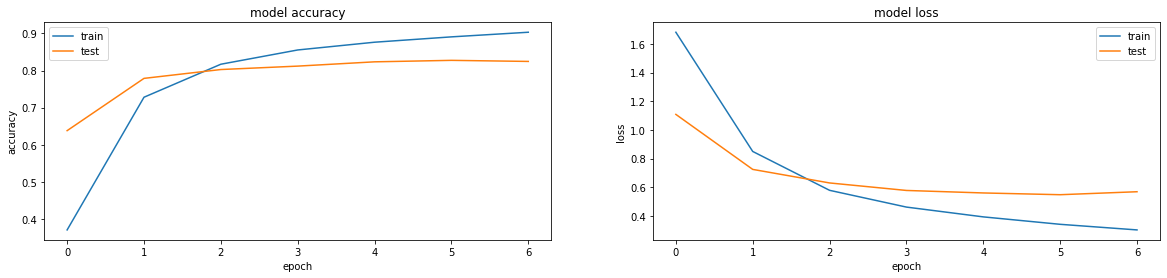

46/46 [==============================] - 0s 7ms/step


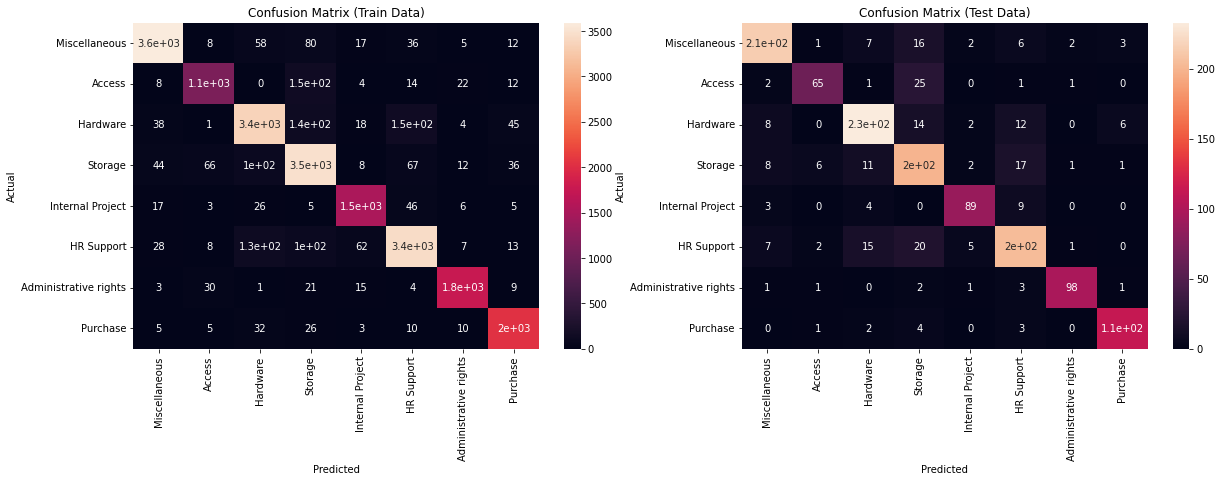

Train Data:
--------------------------------------------------------
                       precision    recall  f1-score   support

        Miscellaneous       0.94      0.96      0.95      3735
               Access       0.85      0.90      0.87      1250
             Hardware       0.90      0.91      0.90      3715
              Storage       0.91      0.87      0.89      4004
     Internal Project       0.93      0.92      0.93      1647
           HR Support       0.91      0.91      0.91      3772
Administrative rights       0.96      0.96      0.96      1831
             Purchase       0.96      0.94      0.95      2177

             accuracy                           0.92     22131
            macro avg       0.92      0.92      0.92     22131
         weighted avg       0.92      0.92      0.92     22131


Test Data:
--------------------------------------------------------
                       precision    recall  f1-score   support

        Miscellaneous       0.85      0

In [ ]:
model_CNN_LSTM.load_weights("best_checkpoint_6A_bilstm")

# Evaluate on test data
model_CNN_LSTM.evaluate(x=test_text, y=test_labels)

# Display Training History
display_training_loss_and_accuracy(history_spec_model_CNN_LSTM)

# Display confusion matrix & classification report
display_classification_confusion_matrix(model_CNN_LSTM, train_text, train_labels, test_text, test_labels, unique_categories)

Combination of CNN + LSTM did not perform better than bidirectional LSTM alone.

Increase number of weights for LSTM to 128 to observe if there is any improvement.

### 6B. Build Convolutional + Bidirectional LSTM model

- SpatialDropout1D (0.2)
- Bidirectional LSTM (128, tanh) 
- Conv1D (64)
- concatenate: GlobalAveragePooling1D + GlobalMaxPooling1D

In [ ]:
EMBEDDING_DIM=128

inputs = keras.Input(shape=(MAX_SEQUENCE_LENGTH,))

embedded = keras.layers.Embedding(input_dim=VOCAB_SIZE, 
                                  output_dim=EMBEDDING_DIM, 
                                  mask_zero=True)(inputs)

# LSTM Example:
x = keras.layers.SpatialDropout1D(0.2)(embedded)
x = keras.layers.Bidirectional(keras.layers.LSTM(128, return_sequences=True))(x)
x = keras.layers.Conv1D(64, kernel_size=3)(x)

avg_pool = keras.layers.GlobalAveragePooling1D()(x)
max_pool = keras.layers.GlobalMaxPooling1D()(x)
x = concatenate([avg_pool, max_pool]) 

outputs = keras.layers.Dense(8, activation='softmax')(x)   # 8 categories

model_CNN_LSTM = keras.Model(inputs, outputs)

model_CNN_LSTM.compile(optimizer=keras.optimizers.Adam(1e-4),
              loss=keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

model_CNN_LSTM.summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_13 (InputLayer)          [(None, 200)]        0           []                               
                                                                                                  
 embedding_12 (Embedding)       (None, 200, 128)     1240320     ['input_13[0][0]']               
                                                                                                  
 spatial_dropout1d_12 (SpatialD  (None, 200, 128)    0           ['embedding_12[0][0]']           
 ropout1D)                                                                                        
                                                                                                  
 bidirectional_11 (Bidirectiona  (None, 200, 256)    263168      ['spatial_dropout1d_12[0][0

In [ ]:
history_spec_model_CNN_LSTM = model_CNN_LSTM.fit(
    train_text, 
    train_labels,
    validation_data=(val_text, val_labels),
    epochs=7, 
    batch_size=32,
    callbacks=[save_best_model('best_checkpoint_6B_bilstm')])

Epoch 1/7
692/692 [==============================] - 96s 113ms/step - loss: 1.6294 - accuracy: 0.3965 - val_loss: 1.1448 - val_accuracy: 0.6181
Epoch 2/7
692/692 [==============================] - 26s 38ms/step - loss: 0.8727 - accuracy: 0.7250 - val_loss: 0.6939 - val_accuracy: 0.7864
Epoch 3/7
692/692 [==============================] - 20s 29ms/step - loss: 0.5614 - accuracy: 0.8272 - val_loss: 0.5711 - val_accuracy: 0.8182
Epoch 4/7
692/692 [==============================] - 21s 31ms/step - loss: 0.4387 - accuracy: 0.8612 - val_loss: 0.5127 - val_accuracy: 0.8278
Epoch 5/7
692/692 [==============================] - 20s 29ms/step - loss: 0.3708 - accuracy: 0.8823 - val_loss: 0.5255 - val_accuracy: 0.8285
Epoch 6/7
692/692 [==============================] - 21s 30ms/step - loss: 0.3217 - accuracy: 0.9001 - val_loss: 0.4939 - val_accuracy: 0.8357
Epoch 7/7
692/692 [==============================] - 21s 30ms/step - loss: 0.2840 - accuracy: 0.9094 - val_loss: 0.4959 - val_accuracy: 0.839

46/46 [==============================] - 1s 14ms/step - loss: 0.4857 - accuracy: 0.8317


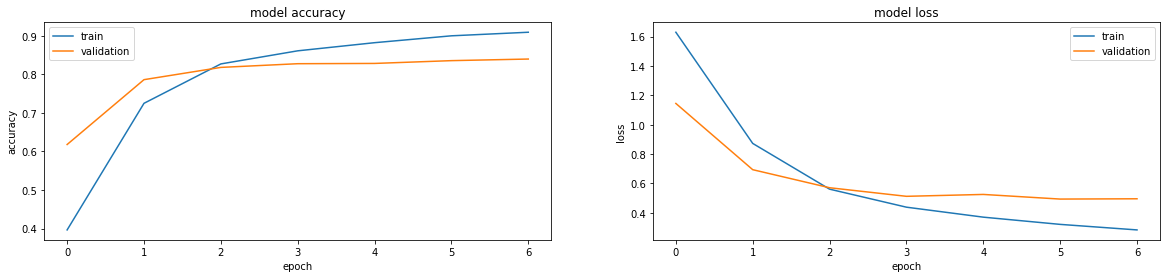

46/46 [==============================] - 1s 11ms/step


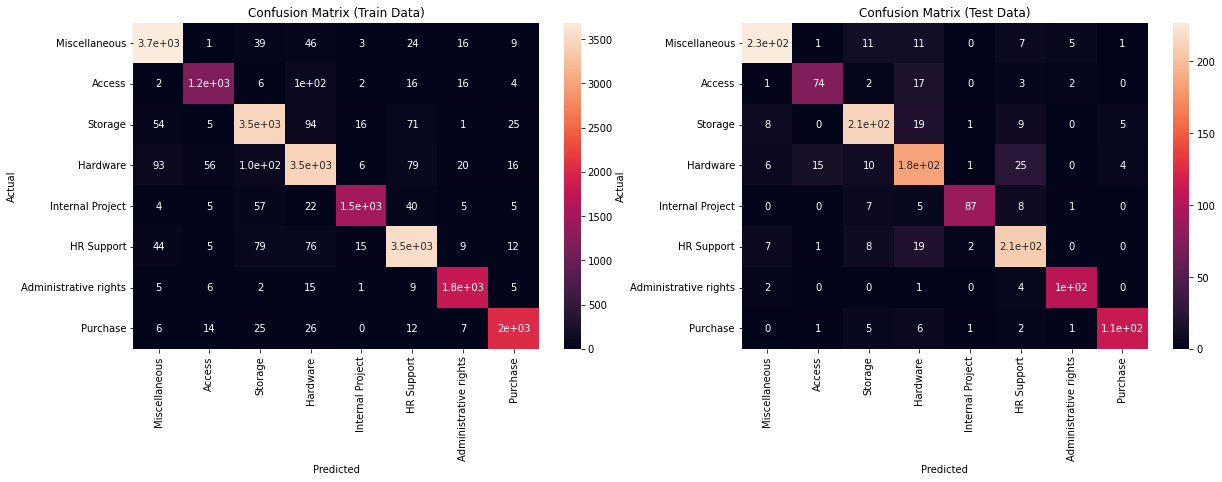

Train Data:
--------------------------------------------------------
                       precision    recall  f1-score   support

        Miscellaneous       0.96      0.95      0.96      3893
               Access       0.89      0.93      0.91      1280
              Storage       0.93      0.92      0.92      3786
             Hardware       0.90      0.90      0.90      3834
     Internal Project       0.92      0.97      0.94      1537
           HR Support       0.94      0.93      0.94      3800
Administrative rights       0.98      0.96      0.97      1882
             Purchase       0.96      0.96      0.96      2119

             accuracy                           0.94     22131
            macro avg       0.93      0.94      0.94     22131
         weighted avg       0.94      0.94      0.94     22131


Test Data:
--------------------------------------------------------
                       precision    recall  f1-score   support

        Miscellaneous       0.86      0

In [ ]:
model_CNN_LSTM.load_weights("best_checkpoint_6B_bilstm")

# Evaluate on test data
model_CNN_LSTM.evaluate(x=test_text, y=test_labels)

# Display Training History
display_training_loss_and_accuracy(history_spec_model_CNN_LSTM)

# Display confusion matrix & classification report
display_classification_confusion_matrix(model_CNN_LSTM, train_text, train_labels, test_text, test_labels, unique_categories)

After increasing number of weights, the model did not perform better. The test accuracy decreased sloghtly although validation accuracy increase. Variance was similar.

In the next run, apply a small dense layer after the conv1D layer in an attempt to increase accuracy, as well as dropouts to reduce variance.

### 6C. Build Convolutional + Bidirectional LSTM model with Dense & Dropout layers

- SpatialDropout1D (0.2)
- Bidirectional LSTM (128, tanh) 
- Dropout(0.5)
- Conv1D (64)
- concatenate: GlobalAveragePooling1D + GlobalMaxPooling1D
- Dense (32, relu)
- Dropout(0.5)

In [ ]:
EMBEDDING_DIM=128

inputs = keras.Input(shape=(MAX_SEQUENCE_LENGTH,))

embedded = keras.layers.Embedding(input_dim=VOCAB_SIZE, 
                                  output_dim=EMBEDDING_DIM, 
                                  mask_zero=True)(inputs)

# LSTM Example:
x = keras.layers.SpatialDropout1D(0.2)(embedded)
x = keras.layers.Bidirectional(keras.layers.LSTM(128, return_sequences=True))(x)
x = Dropout(0.5)(x)
x = keras.layers.Conv1D(64, kernel_size=3, padding = "valid", kernel_initializer = "glorot_uniform")(x)

avg_pool = keras.layers.GlobalAveragePooling1D()(x)
max_pool = keras.layers.GlobalMaxPooling1D()(x)
x = concatenate([avg_pool, max_pool]) 

x = Dense(32, activation='relu')(x)
x = Dropout(0.5)(x)

outputs = keras.layers.Dense(8, activation='softmax')(x)   # 8 categories

model_CNN_LSTM = keras.Model(inputs, outputs)

model_CNN_LSTM.compile(optimizer=keras.optimizers.Adam(1e-4),
              loss=keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

model_CNN_LSTM.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 200)]        0           []                               
                                                                                                  
 embedding_2 (Embedding)        (None, 200, 128)     1238016     ['input_3[0][0]']                
                                                                                                  
 spatial_dropout1d_2 (SpatialDr  (None, 200, 128)    0           ['embedding_2[0][0]']            
 opout1D)                                                                                         
                                                                                                  
 bidirectional_2 (Bidirectional  (None, 200, 256)    263168      ['spatial_dropout1d_2[0][0]

In [ ]:
history_spec_model_CNN_LSTM = model_CNN_LSTM.fit(
    train_text, 
    train_labels,
    validation_data=(val_text, val_labels),
    epochs=7, 
    batch_size=32,
    callbacks=[save_best_model('best_checkpoint_6C_bilstm')])

Epoch 1/7
692/692 [==============================] - 106s 86ms/step - loss: 1.8632 - accuracy: 0.2897 - val_loss: 1.4558 - val_accuracy: 0.5626
Epoch 2/7
692/692 [==============================] - 28s 40ms/step - loss: 1.2300 - accuracy: 0.5859 - val_loss: 0.8725 - val_accuracy: 0.7399
Epoch 3/7
692/692 [==============================] - 26s 37ms/step - loss: 0.8661 - accuracy: 0.7237 - val_loss: 0.6822 - val_accuracy: 0.7891
Epoch 4/7
692/692 [==============================] - 22s 32ms/step - loss: 0.7163 - accuracy: 0.7742 - val_loss: 0.6124 - val_accuracy: 0.8117
Epoch 5/7
692/692 [==============================] - 21s 31ms/step - loss: 0.6285 - accuracy: 0.8098 - val_loss: 0.5766 - val_accuracy: 0.8166
Epoch 6/7
692/692 [==============================] - 23s 33ms/step - loss: 0.5543 - accuracy: 0.8310 - val_loss: 0.5543 - val_accuracy: 0.8274
Epoch 7/7
692/692 [==============================] - 21s 30ms/step - loss: 0.4924 - accuracy: 0.8544 - val_loss: 0.5418 - val_accuracy: 0.831

46/46 [==============================] - 1s 13ms/step - loss: 0.5396 - accuracy: 0.8420


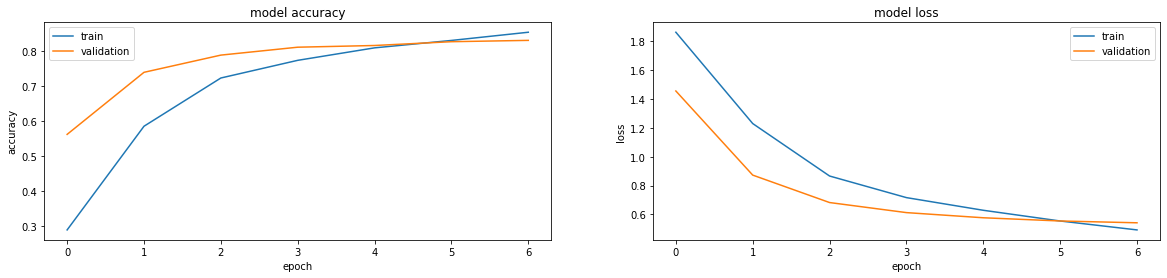

46/46 [==============================] - 0s 8ms/step


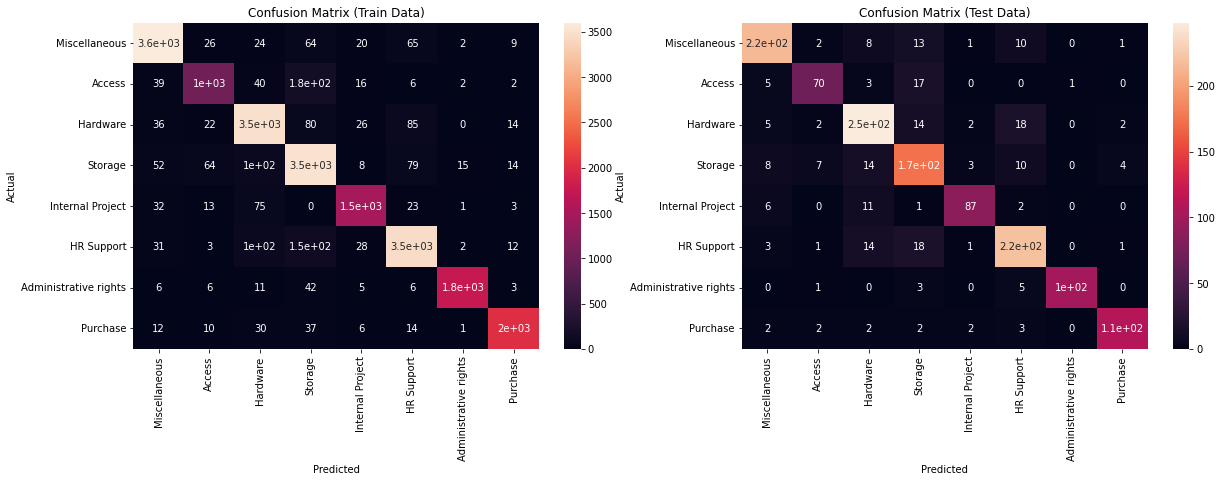

Train Data:
--------------------------------------------------------
                       precision    recall  f1-score   support

        Miscellaneous       0.94      0.95      0.95      3810
               Access       0.78      0.88      0.83      1191
             Hardware       0.93      0.90      0.92      3875
              Storage       0.91      0.86      0.89      4062
     Internal Project       0.91      0.93      0.92      1587
           HR Support       0.91      0.93      0.92      3739
Administrative rights       0.96      0.99      0.97      1786
             Purchase       0.95      0.97      0.96      2081

             accuracy                           0.92     22131
            macro avg       0.91      0.93      0.92     22131
         weighted avg       0.92      0.92      0.92     22131


Test Data:
--------------------------------------------------------
                       precision    recall  f1-score   support

        Miscellaneous       0.86      0

In [ ]:
model_CNN_LSTM.load_weights("best_checkpoint_6C_bilstm")

# Evaluate on test data
model_CNN_LSTM.evaluate(x=test_text, y=test_labels)

# Display Training History
display_training_loss_and_accuracy(history_spec_model_CNN_LSTM)

# Display confusion matrix & classification report
display_classification_confusion_matrix(model_CNN_LSTM, train_text, train_labels, test_text, test_labels, unique_categories)

Applying a dense layer and dropout layers reduced the variance and improved on the testing accuracy.

### 6D. Build Convolutional + Bidirectional LSTM model with Dense & Dropout layers

- SpatialDropout1D (0.2)
- Bidirectional LSTM (128, tanh) 
- Dropout(0.5)
- Conv1D (64)
- concatenate: GlobalAveragePooling1D + GlobalMaxPooling1D
- Dense (**64**, relu)
- Dropout(0.5)

In [ ]:
EMBEDDING_DIM=128

inputs = keras.Input(shape=(MAX_SEQUENCE_LENGTH,))

embedded = keras.layers.Embedding(input_dim=VOCAB_SIZE, 
                                  output_dim=EMBEDDING_DIM, 
                                  mask_zero=True)(inputs)

# LSTM Example:
x = keras.layers.SpatialDropout1D(0.2)(embedded)
x = keras.layers.Bidirectional(keras.layers.LSTM(128, return_sequences=True))(x)
x = Dropout(0.5)(x)
x = keras.layers.Conv1D(64, kernel_size=3, padding = "valid", kernel_initializer = "glorot_uniform")(x)

avg_pool = keras.layers.GlobalAveragePooling1D()(x)
max_pool = keras.layers.GlobalMaxPooling1D()(x)
x = concatenate([avg_pool, max_pool]) 

x = Dense(64, activation='relu')(x)
x = Dropout(0.5)(x)

outputs = keras.layers.Dense(8, activation='softmax')(x)   # 8 categories

model_CNN_LSTM = keras.Model(inputs, outputs)

model_CNN_LSTM.compile(optimizer=keras.optimizers.Adam(1e-4),
              loss=keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

model_CNN_LSTM.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 200)]        0           []                               
                                                                                                  
 embedding_5 (Embedding)        (None, 200, 128)     1238016     ['input_6[0][0]']                
                                                                                                  
 spatial_dropout1d_5 (SpatialDr  (None, 200, 128)    0           ['embedding_5[0][0]']            
 opout1D)                                                                                         
                                                                                                  
 bidirectional_5 (Bidirectional  (None, 200, 256)    263168      ['spatial_dropout1d_5[0][0]

In [ ]:
history_spec_model_CNN_LSTM = model_CNN_LSTM.fit(
    train_text, 
    train_labels,
    validation_data=(val_text, val_labels),
    epochs=7, 
    batch_size=32,
    callbacks=[save_best_model('best_checkpoint_6D_bilstm')])

Epoch 1/7
692/692 [==============================] - 67s 82ms/step - loss: 1.8150 - accuracy: 0.2618 - val_loss: 1.3749 - val_accuracy: 0.5628
Epoch 2/7
692/692 [==============================] - 26s 38ms/step - loss: 1.0301 - accuracy: 0.6375 - val_loss: 0.7730 - val_accuracy: 0.7461
Epoch 3/7
692/692 [==============================] - 23s 32ms/step - loss: 0.7140 - accuracy: 0.7672 - val_loss: 0.6452 - val_accuracy: 0.7898
Epoch 4/7
692/692 [==============================] - 23s 33ms/step - loss: 0.5885 - accuracy: 0.8146 - val_loss: 0.6004 - val_accuracy: 0.8048
Epoch 5/7
692/692 [==============================] - 22s 32ms/step - loss: 0.5068 - accuracy: 0.8475 - val_loss: 0.5662 - val_accuracy: 0.8146
Epoch 6/7
692/692 [==============================] - 20s 29ms/step - loss: 0.4541 - accuracy: 0.8651 - val_loss: 0.5669 - val_accuracy: 0.8169
Epoch 7/7
692/692 [==============================] - 21s 30ms/step - loss: 0.4089 - accuracy: 0.8786 - val_loss: 0.5560 - val_accuracy: 0.8204

46/46 [==============================] - 1s 16ms/step - loss: 0.5551 - accuracy: 0.8331


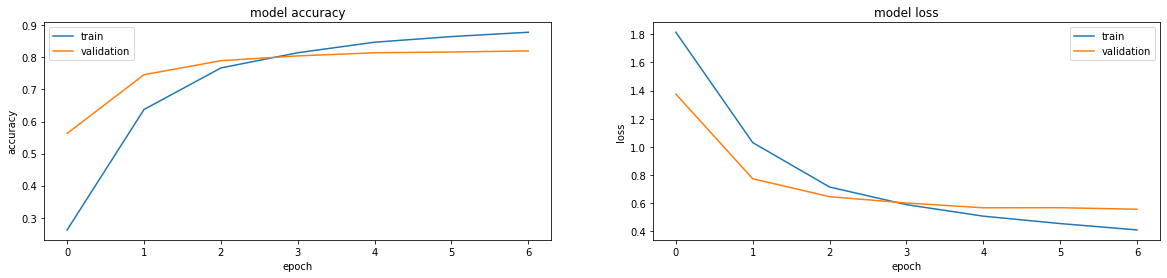

46/46 [==============================] - 0s 7ms/step


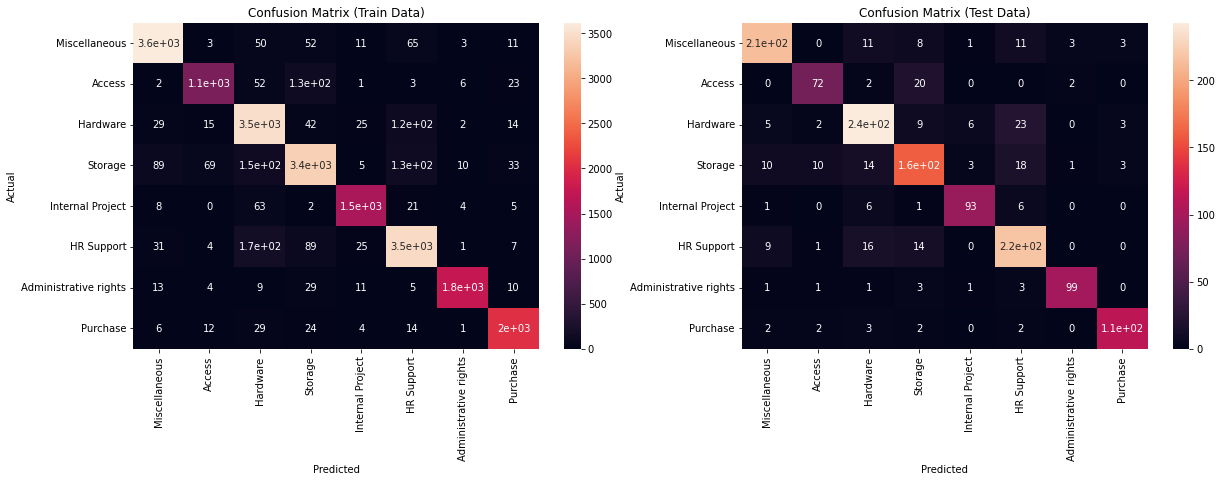

Train Data:
--------------------------------------------------------
                       precision    recall  f1-score   support

        Miscellaneous       0.95      0.95      0.95      3795
               Access       0.84      0.91      0.87      1225
             Hardware       0.93      0.87      0.90      4031
              Storage       0.87      0.90      0.89      3723
     Internal Project       0.94      0.95      0.94      1604
           HR Support       0.91      0.91      0.91      3818
Administrative rights       0.96      0.98      0.97      1788
             Purchase       0.96      0.95      0.95      2147

             accuracy                           0.92     22131
            macro avg       0.92      0.93      0.92     22131
         weighted avg       0.92      0.92      0.92     22131


Test Data:
--------------------------------------------------------
                       precision    recall  f1-score   support

        Miscellaneous       0.85      0

In [ ]:
model_CNN_LSTM.load_weights("best_checkpoint_6D_bilstm")

# Evaluate on test data
model_CNN_LSTM.evaluate(x=test_text, y=test_labels)

# Display Training History
display_training_loss_and_accuracy(history_spec_model_CNN_LSTM)

# Display confusion matrix & classification report
display_classification_confusion_matrix(model_CNN_LSTM, train_text, train_labels, test_text, test_labels, unique_categories)

After increasing the number of weights in the dense layer, the variance increased and test accuracy decreased.
Suggesting that this model is likely too complex for this purpose and is overfitting slightly.

## 7. CNN + Bidirectional GRU


### 7A. Build Convolutional + Bidirectional GRU model

- SpatialDropout1D (0.2)
- Bidirectional GRU (128, tanh) 
- Conv1D (64)
- concatenate: GlobalAveragePooling1D + GlobalMaxPooling1D

In [ ]:
EMBEDDING_DIM=128

inputs = keras.Input(shape=(MAX_SEQUENCE_LENGTH,))

embedded = keras.layers.Embedding(input_dim=VOCAB_SIZE, 
                                  output_dim=EMBEDDING_DIM, 
                                  mask_zero=True)(inputs)

# GRU Example:
x = keras.layers.SpatialDropout1D(0.2)(embedded)
x = keras.layers.Bidirectional(keras.layers.GRU(128, return_sequences=True))(x)
x = keras.layers.Conv1D(64, kernel_size=3, padding = "valid", kernel_initializer = "glorot_uniform")(x)
avg_pool = keras.layers.GlobalAveragePooling1D()(x)
max_pool = keras.layers.GlobalMaxPooling1D()(x)
x = concatenate([avg_pool, max_pool]) 

outputs = keras.layers.Dense(8, activation='softmax')(x)   # 8 categories

model_CNN_GRU = keras.Model(inputs, outputs)

model_CNN_GRU.compile(optimizer=keras.optimizers.Adam(1e-4),
              loss=keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

model_CNN_GRU.summary()

Model: "model_11"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_17 (InputLayer)          [(None, 200)]        0           []                               
                                                                                                  
 embedding_16 (Embedding)       (None, 200, 128)     1233024     ['input_17[0][0]']               
                                                                                                  
 spatial_dropout1d_8 (SpatialDr  (None, 200, 128)    0           ['embedding_16[0][0]']           
 opout1D)                                                                                         
                                                                                                  
 bidirectional_14 (Bidirectiona  (None, 200, 256)    198144      ['spatial_dropout1d_8[0][0

In [ ]:
history_spec_model_CNN_GRU = model_CNN_GRU.fit(
    train_text, 
    train_labels,
    validation_data=(val_text, val_labels),
    epochs=7, 
    batch_size=32,
    callbacks=[save_best_model('best_checkpoint_7A_bilstm')])

Epoch 1/7
692/692 [==============================] - 81s 103ms/step - loss: 1.5756 - accuracy: 0.4361 - val_loss: 0.8803 - val_accuracy: 0.7219
Epoch 2/7
692/692 [==============================] - 29s 41ms/step - loss: 0.6416 - accuracy: 0.7996 - val_loss: 0.5564 - val_accuracy: 0.8166
Epoch 3/7
692/692 [==============================] - 21s 31ms/step - loss: 0.4498 - accuracy: 0.8572 - val_loss: 0.4842 - val_accuracy: 0.8370
Epoch 4/7
692/692 [==============================] - 20s 28ms/step - loss: 0.3739 - accuracy: 0.8803 - val_loss: 0.4577 - val_accuracy: 0.8493
Epoch 5/7
692/692 [==============================] - 22s 32ms/step - loss: 0.3211 - accuracy: 0.8966 - val_loss: 0.4500 - val_accuracy: 0.8522
Epoch 6/7
692/692 [==============================] - 23s 33ms/step - loss: 0.2787 - accuracy: 0.9085 - val_loss: 0.4625 - val_accuracy: 0.8494
Epoch 7/7
692/692 [==============================] - 23s 33ms/step - loss: 0.2487 - accuracy: 0.9188 - val_loss: 0.4603 - val_accuracy: 0.851

46/46 [==============================] - 38s 10ms/step - loss: 0.4300 - accuracy: 0.8503


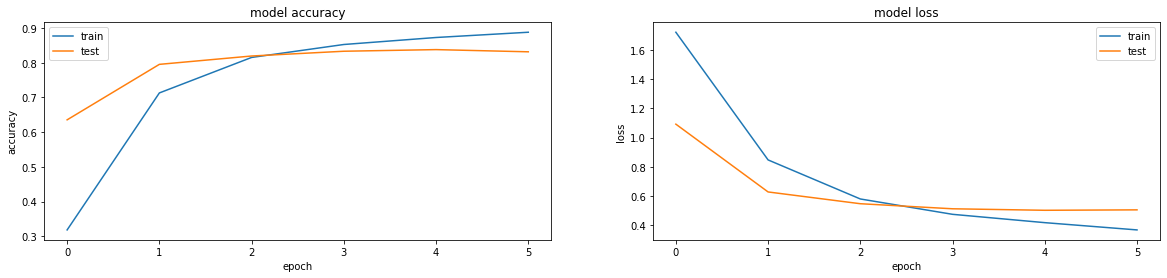

46/46 [==============================] - 0s 8ms/step


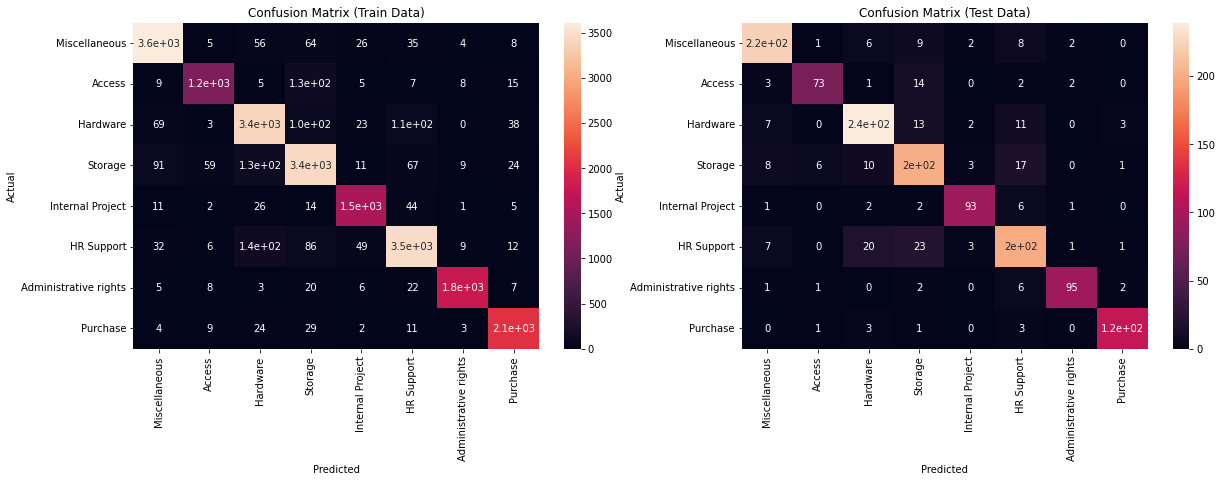

Train Data:
--------------------------------------------------------
                       precision    recall  f1-score   support

        Miscellaneous       0.95      0.94      0.95      3831
               Access       0.87      0.93      0.90      1248
             Hardware       0.91      0.90      0.90      3789
              Storage       0.90      0.88      0.89      3885
     Internal Project       0.94      0.93      0.93      1647
           HR Support       0.91      0.92      0.92      3757
Administrative rights       0.96      0.98      0.97      1811
             Purchase       0.96      0.95      0.96      2163

             accuracy                           0.92     22131
            macro avg       0.92      0.93      0.93     22131
         weighted avg       0.92      0.92      0.92     22131


Test Data:
--------------------------------------------------------
                       precision    recall  f1-score   support

        Miscellaneous       0.89      0

In [ ]:
model_CNN_GRU.load_weights("best_checkpoint_7A_bilstm")

# Evaluate on test data
model_CNN_GRU.evaluate(x=test_text, y=test_labels)

# Display Training History
display_training_loss_and_accuracy(history_spec_model_CNN_GRU)

# Display confusion matrix & classification report
display_classification_confusion_matrix(model_CNN_GRU, train_text, train_labels, test_text, test_labels, unique_categories)

Model performed better with 85.03% test accuracy. This is the highest obtained  test accuracy thus far. The number of epochs may be reduced slightly, as validation accuracy did not improve and variance increased after 5 epochs.

F1 score for Access & Storage improved slightly to 79%, however these categories still have the lowest F1 scores among the other categories. 

In [ ]:
# Save the model
model_CNN_GRU.save(proj_folder+"/text_classification_LSTM_model_vCA.h5")

# Load the model
# model_CNN_GRU = keras.models.load_model(proj_folder+"/text_classification_LSTM_model_vCA.h5")

### 7B. Build Convolutional + Bidirectional GRU model with Dropouts

- SpatialDropout1D (0.2)
- Bidirectional GRU (128, tanh, dropout=0.1,recurrent_dropout=0.1) 
- Conv1D (64)
- concatenate: GlobalAveragePooling1D + GlobalMaxPooling1D

In [ ]:
EMBEDDING_DIM=128

inputs = keras.Input(shape=(MAX_SEQUENCE_LENGTH,))

embedded = keras.layers.Embedding(input_dim=VOCAB_SIZE, 
                                  output_dim=EMBEDDING_DIM, 
                                  mask_zero=True)(inputs)

# GRU Example:
x = keras.layers.SpatialDropout1D(0.2)(embedded)
x = keras.layers.Bidirectional(keras.layers.GRU(128, return_sequences=True, dropout=0.1,recurrent_dropout=0.1))(x)
x = keras.layers.Conv1D(64, kernel_size=3, padding = "valid", kernel_initializer = "glorot_uniform")(x)
avg_pool = keras.layers.GlobalAveragePooling1D()(x)
max_pool = keras.layers.GlobalMaxPooling1D()(x)
x = concatenate([avg_pool, max_pool]) 

outputs = keras.layers.Dense(8, activation='softmax')(x)   # 8 categories

model_CNN_GRU = keras.Model(inputs, outputs)

model_CNN_GRU.compile(optimizer=keras.optimizers.Adam(1e-4),
              loss=keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

model_CNN_GRU.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 200)]        0           []                               
                                                                                                  
 embedding (Embedding)          (None, 200, 128)     1225088     ['input_1[0][0]']                
                                                                                                  
 spatial_dropout1d (SpatialDrop  (None, 200, 128)    0           ['embedding[0][0]']              
 out1D)                                                                                           
                                                                                                  
 bidirectional (Bidirectional)  (None, 200, 256)     198144      ['spatial_dropout1d[0][0]']  

In [ ]:
history_spec_model_CNN_GRU = model_CNN_GRU.fit(
    train_text, 
    train_labels,
    validation_data=(val_text, val_labels),
    epochs=6, 
    batch_size=32,
    callbacks=[save_best_model('best_checkpoint_7B_bilstm')])

Epoch 1/6
692/692 [==============================] - 1350s 2s/step - loss: 1.6140 - accuracy: 0.4162 - val_loss: 0.9759 - val_accuracy: 0.6900
Epoch 2/6
692/692 [==============================] - 1257s 2s/step - loss: 0.7256 - accuracy: 0.7627 - val_loss: 0.6167 - val_accuracy: 0.7961
Epoch 3/6
692/692 [==============================] - 1249s 2s/step - loss: 0.5045 - accuracy: 0.8376 - val_loss: 0.5232 - val_accuracy: 0.8193
Epoch 4/6
692/692 [==============================] - 1243s 2s/step - loss: 0.4105 - accuracy: 0.8675 - val_loss: 0.4854 - val_accuracy: 0.8363
Epoch 5/6
692/692 [==============================] - 1235s 2s/step - loss: 0.3559 - accuracy: 0.8829 - val_loss: 0.4743 - val_accuracy: 0.8411
Epoch 6/6
692/692 [==============================] - 1226s 2s/step - loss: 0.3126 - accuracy: 0.8975 - val_loss: 0.4682 - val_accuracy: 0.8440


46/46 [==============================] - 5s 116ms/step - loss: 0.4447 - accuracy: 0.8503


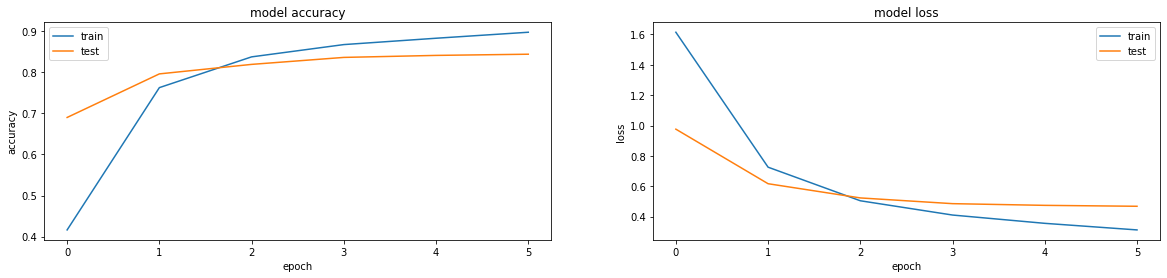

46/46 [==============================] - 6s 141ms/step


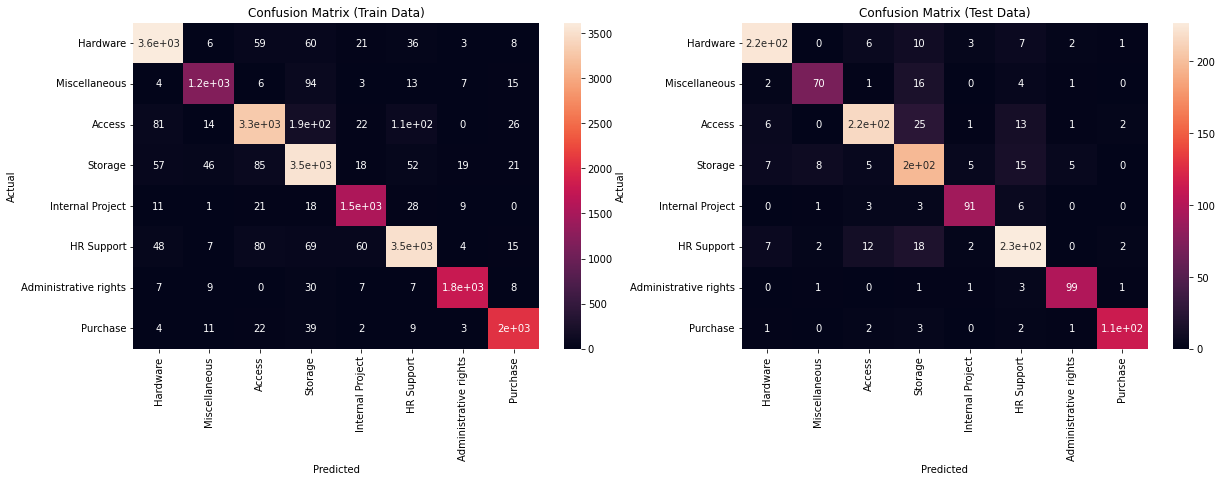

Train Data:
--------------------------------------------------------
                       precision    recall  f1-score   support

             Hardware       0.95      0.94      0.95      3827
        Miscellaneous       0.89      0.93      0.91      1290
               Access       0.88      0.92      0.90      3567
              Storage       0.92      0.88      0.90      4039
     Internal Project       0.95      0.92      0.93      1678
           HR Support       0.93      0.93      0.93      3762
Administrative rights       0.96      0.98      0.97      1827
             Purchase       0.96      0.96      0.96      2141

             accuracy                           0.93     22131
            macro avg       0.93      0.93      0.93     22131
         weighted avg       0.93      0.93      0.93     22131


Test Data:
--------------------------------------------------------
                       precision    recall  f1-score   support

             Hardware       0.89      0

In [ ]:
model_CNN_GRU.load_weights("best_checkpoint_7B_bilstm")

# Evaluate on test data
model_CNN_GRU.evaluate(x=test_text, y=test_labels)

# Display Training History
display_training_loss_and_accuracy(history_spec_model_CNN_GRU)

# Display confusion matrix & classification report
display_classification_confusion_matrix(model_CNN_GRU, train_text, train_labels, test_text, test_labels, unique_categories)

Compared to 7A, the model performed similarly with 85.03% test accuracy. The number of epochs may be reduced slightly, as validation accuracy did not improve and variance increased after 5 epochs. Variance was slightly higher.

However, it took a very long time to train due to dropouts applied within the birectional GRU layer. To reduce training time, Dropout layers will be applied instead as a regularisation technique.



### 7C. Build Convolutional + Bidirectional GRU model with Dense & Dropout layers

- SpatialDropout1D (0.2)
- Bidirectional GRU (128, tanh) 
- Conv1D (64)
- concatenate: GlobalAveragePooling1D + GlobalMaxPooling1D
- Dense (128, relu)
- Dropout (0.5)

In [ ]:
EMBEDDING_DIM=128

inputs = keras.Input(shape=(MAX_SEQUENCE_LENGTH,))

embedded = keras.layers.Embedding(input_dim=VOCAB_SIZE, 
                                  output_dim=EMBEDDING_DIM, 
                                  mask_zero=True)(inputs)

# GRU Example:
x = keras.layers.SpatialDropout1D(0.2)(embedded)
x = keras.layers.Bidirectional(keras.layers.GRU(128, return_sequences=True))(x)
x = keras.layers.Conv1D(64, kernel_size=3, padding = "valid", kernel_initializer = "glorot_uniform")(x)
avg_pool = keras.layers.GlobalAveragePooling1D()(x)
max_pool = keras.layers.GlobalMaxPooling1D()(x)
x = concatenate([avg_pool, max_pool]) 
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = keras.layers.Dense(8, activation='softmax')(x)   # 8 categories

model_CNN_GRU = keras.Model(inputs, outputs)

model_CNN_GRU.compile(optimizer=keras.optimizers.Adam(1e-4),
              loss=keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

model_CNN_GRU.summary()

Model: "model_10"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_16 (InputLayer)          [(None, 200)]        0           []                               
                                                                                                  
 embedding_15 (Embedding)       (None, 200, 128)     1233024     ['input_16[0][0]']               
                                                                                                  
 spatial_dropout1d_7 (SpatialDr  (None, 200, 128)    0           ['embedding_15[0][0]']           
 opout1D)                                                                                         
                                                                                                  
 bidirectional_13 (Bidirectiona  (None, 200, 256)    198144      ['spatial_dropout1d_7[0][0

In [ ]:
history_spec_model_CNN_GRU = model_CNN_GRU.fit(
    train_text, 
    train_labels,
    validation_data=(val_text, val_labels),
    epochs=7, 
    batch_size=32,
    callbacks=[save_best_model('best_checkpoint_7C_bilstm')])

Epoch 1/7
692/692 [==============================] - 62s 76ms/step - loss: 1.6997 - accuracy: 0.3350 - val_loss: 0.9908 - val_accuracy: 0.7038
Epoch 2/7
692/692 [==============================] - 24s 35ms/step - loss: 0.7824 - accuracy: 0.7455 - val_loss: 0.6011 - val_accuracy: 0.8115
Epoch 3/7
692/692 [==============================] - 22s 32ms/step - loss: 0.5511 - accuracy: 0.8311 - val_loss: 0.5249 - val_accuracy: 0.8335
Epoch 4/7
692/692 [==============================] - 21s 31ms/step - loss: 0.4527 - accuracy: 0.8630 - val_loss: 0.5086 - val_accuracy: 0.8384
Epoch 5/7
692/692 [==============================] - 18s 27ms/step - loss: 0.3994 - accuracy: 0.8788 - val_loss: 0.4982 - val_accuracy: 0.8386
Epoch 6/7
692/692 [==============================] - 20s 29ms/step - loss: 0.3561 - accuracy: 0.8943 - val_loss: 0.4857 - val_accuracy: 0.8401
Epoch 7/7
692/692 [==============================] - 18s 26ms/step - loss: 0.3252 - accuracy: 0.9014 - val_loss: 0.5120 - val_accuracy: 0.8346

46/46 [==============================] - 0s 9ms/step - loss: 0.4410 - accuracy: 0.8475


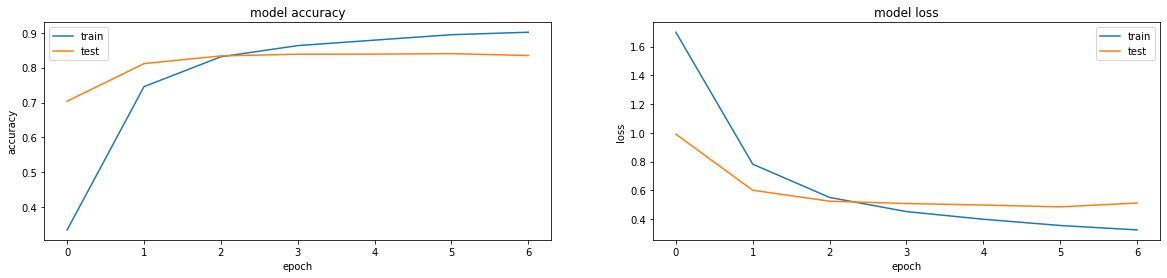

46/46 [==============================] - 0s 8ms/step


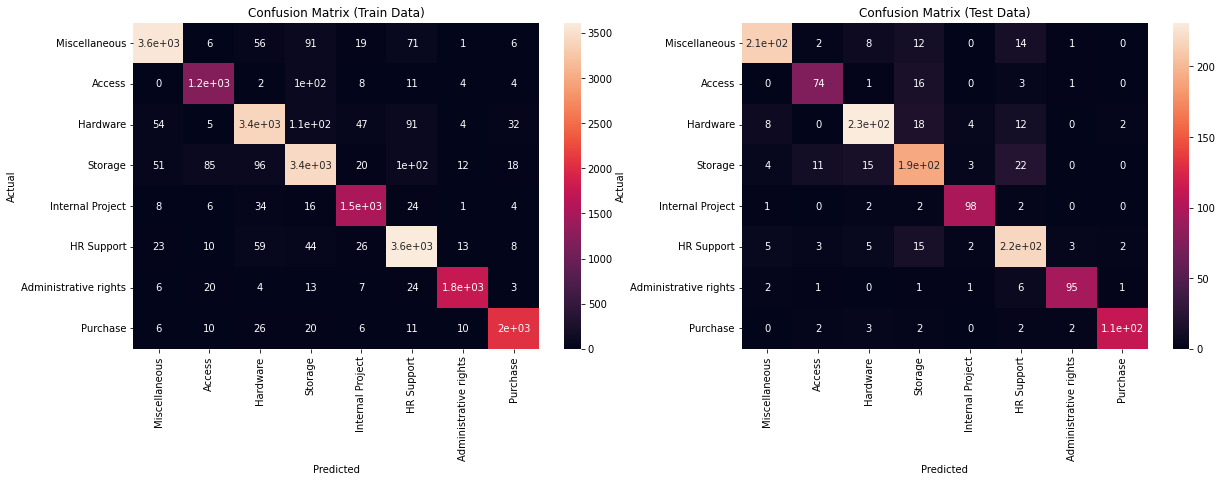

Train Data:
--------------------------------------------------------
                       precision    recall  f1-score   support

        Miscellaneous       0.93      0.96      0.95      3706
               Access       0.90      0.89      0.90      1348
             Hardware       0.91      0.92      0.92      3686
              Storage       0.90      0.90      0.90      3837
     Internal Project       0.94      0.92      0.93      1668
           HR Support       0.95      0.92      0.93      3948
Administrative rights       0.96      0.98      0.97      1816
             Purchase       0.96      0.96      0.96      2122

             accuracy                           0.93     22131
            macro avg       0.93      0.93      0.93     22131
         weighted avg       0.93      0.93      0.93     22131


Test Data:
--------------------------------------------------------
                       precision    recall  f1-score   support

        Miscellaneous       0.85      0

In [ ]:
model_CNN_GRU.load_weights("best_checkpoint_7C_bilstm")

# Evaluate on test data
model_CNN_GRU.evaluate(x=test_text, y=test_labels)

# Display Training History
display_training_loss_and_accuracy(history_spec_model_CNN_GRU)

# Display confusion matrix & classification report
display_classification_confusion_matrix(model_CNN_GRU, train_text, train_labels, test_text, test_labels, unique_categories)

After adding a dense layer, the model performed similarly with 84.75% test accuracy. However, variance is slightly higher.

Vary the number of weights in the dense layer and observe the impact on variance/accuracy.

### 7D. Build Convolutional + Bidirectional GRU model with Dense & Dropout layers

- SpatialDropout1D (0.2)
- Bidirectional GRU (128, tanh, **dropout=0.1, recurrent_dropout=0.1**)
- Conv1D (64)
- concatenate: GlobalAveragePooling1D + GlobalMaxPooling1D
- Dense (128, relu)
- Dropout (0.5)



In [ ]:
EMBEDDING_DIM=128

inputs = keras.Input(shape=(MAX_SEQUENCE_LENGTH,))

embedded = keras.layers.Embedding(input_dim=VOCAB_SIZE, 
                                  output_dim=EMBEDDING_DIM, 
                                  mask_zero=True)(inputs)

# GRU Example:
x = keras.layers.SpatialDropout1D(0.2)(embedded)
x = keras.layers.Bidirectional(keras.layers.GRU(128, return_sequences=True, dropout=0.1,recurrent_dropout=0.1))(x)

x = keras.layers.Conv1D(64, kernel_size=3, padding = "valid", kernel_initializer = "glorot_uniform")(x)
avg_pool = keras.layers.GlobalAveragePooling1D()(x)
max_pool = keras.layers.GlobalMaxPooling1D()(x)
x = concatenate([avg_pool, max_pool]) 

x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = keras.layers.Dense(8, activation='softmax')(x)   # 8 categories

model_CNN_GRU = keras.Model(inputs, outputs)

model_CNN_GRU.compile(optimizer=keras.optimizers.Adam(1e-4),
              loss=keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

model_CNN_GRU.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 200)]        0           []                               
                                                                                                  
 embedding (Embedding)          (None, 200, 128)     1228416     ['input_1[0][0]']                
                                                                                                  
 spatial_dropout1d (SpatialDrop  (None, 200, 128)    0           ['embedding[0][0]']              
 out1D)                                                                                           
                                                                                                  
 bidirectional (Bidirectional)  (None, 200, 256)     198144      ['spatial_dropout1d[0][0]']  

In [ ]:
history_spec_model_CNN_GRU = model_CNN_GRU.fit(
    train_text, 
    train_labels,
    validation_data=(val_text, val_labels),
    epochs=5, 
    batch_size=32,
    callbacks=[save_best_model('best_checkpoint_7D_bilstm')])

# Note: training needs about 1.5hrs

Epoch 1/5
692/692 [==============================] - 1347s 2s/step - loss: 1.7399 - accuracy: 0.3178 - val_loss: 0.9989 - val_accuracy: 0.6756
Epoch 2/5
692/692 [==============================] - 1265s 2s/step - loss: 0.7856 - accuracy: 0.7356 - val_loss: 0.5768 - val_accuracy: 0.8138
Epoch 3/5
692/692 [==============================] - 1258s 2s/step - loss: 0.5623 - accuracy: 0.8207 - val_loss: 0.5113 - val_accuracy: 0.8330
Epoch 4/5
692/692 [==============================] - 1277s 2s/step - loss: 0.4655 - accuracy: 0.8516 - val_loss: 0.4821 - val_accuracy: 0.8429
Epoch 5/5
692/692 [==============================] - 1239s 2s/step - loss: 0.4093 - accuracy: 0.8750 - val_loss: 0.4667 - val_accuracy: 0.8469


46/46 [==============================] - 6s 121ms/step - loss: 0.4692 - accuracy: 0.8407


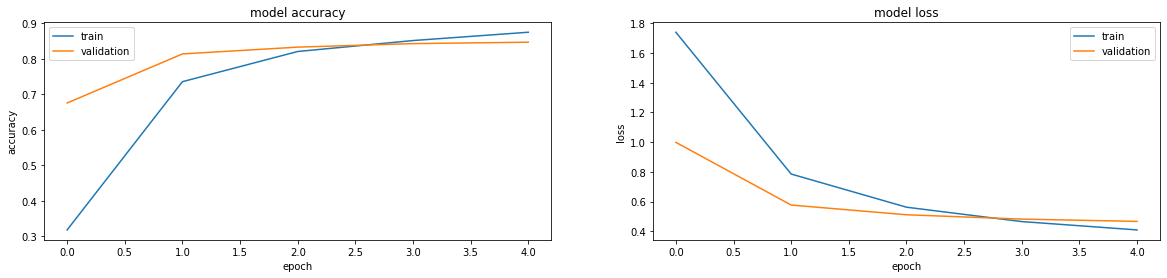

46/46 [==============================] - 5s 116ms/step


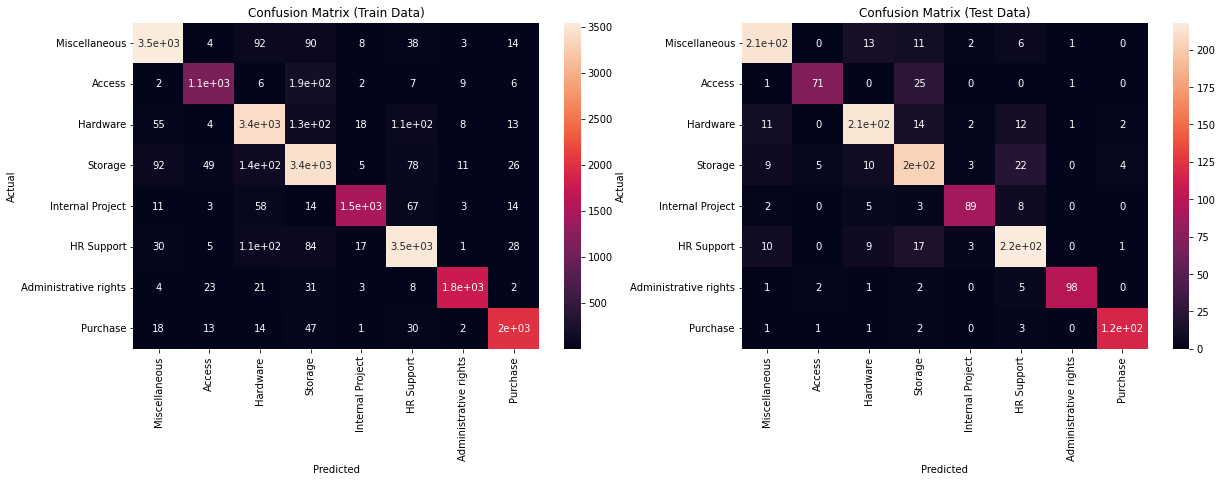

Train Data:
--------------------------------------------------------
                       precision    recall  f1-score   support

        Miscellaneous       0.93      0.94      0.94      3754
               Access       0.84      0.92      0.87      1220
             Hardware       0.91      0.89      0.90      3860
              Storage       0.89      0.86      0.87      4014
     Internal Project       0.90      0.96      0.93      1522
           HR Support       0.93      0.91      0.92      3840
Administrative rights       0.95      0.98      0.96      1801
             Purchase       0.94      0.95      0.95      2120

             accuracy                           0.92     22131
            macro avg       0.91      0.93      0.92     22131
         weighted avg       0.92      0.92      0.92     22131


Test Data:
--------------------------------------------------------
                       precision    recall  f1-score   support

        Miscellaneous       0.87      0

In [ ]:
model_CNN_GRU.load_weights("best_checkpoint_7D_bilstm")

# Evaluate on test data
model_CNN_GRU.evaluate(x=test_text, y=test_labels)

# Display Training History
display_training_loss_and_accuracy(history_spec_model_CNN_GRU)

# Display confusion matrix & classification report
display_classification_confusion_matrix(model_CNN_GRU, train_text, train_labels, test_text, test_labels, unique_categories)

After applying Dropout in the bidirectional GRU layer, the validation/testing accuracy decreased but so did the variance. 

However, training time increased significantly. Hence, to avoid use of dropouts within the LSTM layer due to excessive training time required and no sigificantly benefit to accuracy.

### 7E. Build Convolutional + Bidirectional GRU model with Dense & Dropout layers

- SpatialDropout1D (0.2)
- Bidirectional GRU (128, tanh) 
- Conv1D (64)
- concatenate: GlobalAveragePooling1D + GlobalMaxPooling1D
- Dense (**32**, relu)
- Dropout (0.5)



In [ ]:
EMBEDDING_DIM=128

inputs = keras.Input(shape=(MAX_SEQUENCE_LENGTH,))

embedded = keras.layers.Embedding(input_dim=VOCAB_SIZE, 
                                  output_dim=EMBEDDING_DIM, 
                                  mask_zero=True)(inputs)

# GRU Example:
x = keras.layers.SpatialDropout1D(0.2)(embedded)
x = keras.layers.Bidirectional(keras.layers.GRU(128, return_sequences=True))(x)
x = keras.layers.Conv1D(64, kernel_size=3, padding = "valid", kernel_initializer = "glorot_uniform")(x)
avg_pool = keras.layers.GlobalAveragePooling1D()(x)
max_pool = keras.layers.GlobalMaxPooling1D()(x)
x = concatenate([avg_pool, max_pool]) 
x = Dense(32, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = keras.layers.Dense(8, activation='softmax')(x)   # 8 categories

model_CNN_GRU = keras.Model(inputs, outputs)

model_CNN_GRU.compile(optimizer=keras.optimizers.Adam(1e-4),
              loss=keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

model_CNN_GRU.summary()

Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_10 (InputLayer)          [(None, 200)]        0           []                               
                                                                                                  
 embedding_9 (Embedding)        (None, 200, 128)     1238016     ['input_10[0][0]']               
                                                                                                  
 spatial_dropout1d_9 (SpatialDr  (None, 200, 128)    0           ['embedding_9[0][0]']            
 opout1D)                                                                                         
                                                                                                  
 bidirectional_9 (Bidirectional  (None, 200, 256)    198144      ['spatial_dropout1d_9[0][0]

In [ ]:
history_spec_model_CNN_GRU = model_CNN_GRU.fit(
    train_text, 
    train_labels,
    validation_data=(val_text, val_labels),
    epochs=7, 
    batch_size=32,
    callbacks=[save_best_model('best_checkpoint_7E_bilstm')])

Epoch 1/7
692/692 [==============================] - 103s 126ms/step - loss: 1.8188 - accuracy: 0.3015 - val_loss: 1.2121 - val_accuracy: 0.6365
Epoch 2/7
692/692 [==============================] - 25s 37ms/step - loss: 1.0618 - accuracy: 0.6411 - val_loss: 0.7137 - val_accuracy: 0.7659
Epoch 3/7
692/692 [==============================] - 21s 31ms/step - loss: 0.7860 - accuracy: 0.7431 - val_loss: 0.6163 - val_accuracy: 0.8055
Epoch 4/7
692/692 [==============================] - 24s 34ms/step - loss: 0.6682 - accuracy: 0.7831 - val_loss: 0.5567 - val_accuracy: 0.8250
Epoch 5/7
692/692 [==============================] - 21s 31ms/step - loss: 0.5834 - accuracy: 0.8156 - val_loss: 0.5472 - val_accuracy: 0.8279
Epoch 6/7
692/692 [==============================] - 21s 31ms/step - loss: 0.5242 - accuracy: 0.8327 - val_loss: 0.5373 - val_accuracy: 0.8307
Epoch 7/7
692/692 [==============================] - 22s 31ms/step - loss: 0.4862 - accuracy: 0.8501 - val_loss: 0.5308 - val_accuracy: 0.83

46/46 [==============================] - 1s 12ms/step - loss: 0.5124 - accuracy: 0.8462


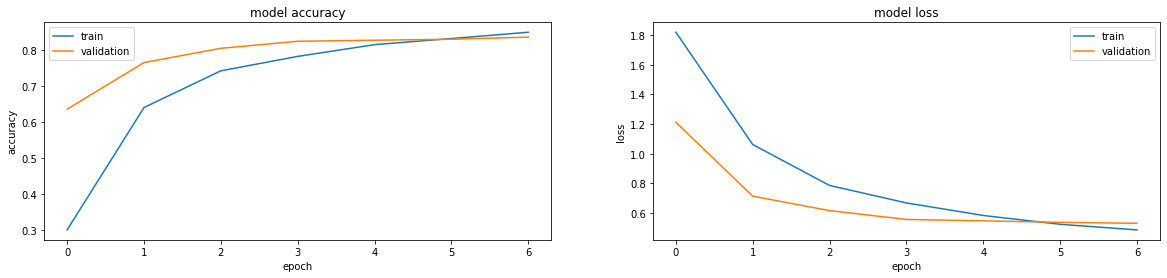

46/46 [==============================] - 0s 7ms/step


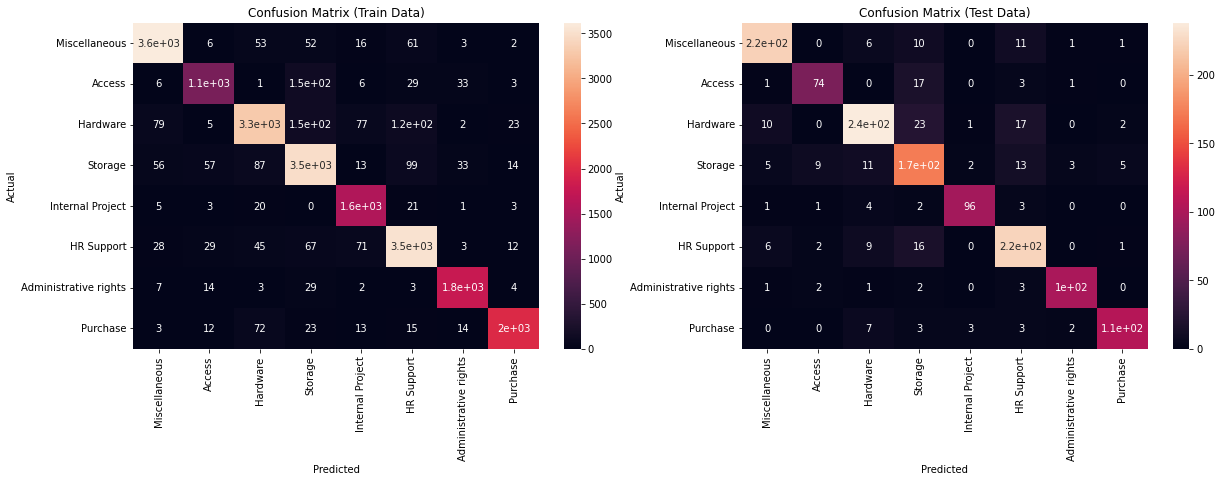

Train Data:
--------------------------------------------------------
                       precision    recall  f1-score   support

        Miscellaneous       0.95      0.95      0.95      3803
               Access       0.83      0.90      0.86      1233
             Hardware       0.88      0.92      0.90      3580
              Storage       0.91      0.88      0.89      3957
     Internal Project       0.97      0.89      0.93      1770
           HR Support       0.93      0.91      0.92      3876
Administrative rights       0.97      0.95      0.96      1869
             Purchase       0.93      0.97      0.95      2043

             accuracy                           0.92     22131
            macro avg       0.92      0.92      0.92     22131
         weighted avg       0.92      0.92      0.92     22131


Test Data:
--------------------------------------------------------
                       precision    recall  f1-score   support

        Miscellaneous       0.88      0

In [ ]:
model_CNN_GRU.load_weights("best_checkpoint_7E_bilstm")

# Evaluate on test data
model_CNN_GRU.evaluate(x=test_text, y=test_labels)

# Display Training History
display_training_loss_and_accuracy(history_spec_model_CNN_GRU)

# Display confusion matrix & classification report
display_classification_confusion_matrix(model_CNN_GRU, train_text, train_labels, test_text, test_labels, unique_categories)

Compared to 7C, reducing the number of weights from 128 to 32 in the dense layer reduced the variance with minimal change (slightly lower) to the testing accuracy. Keeping the number of epochs low also prevented overfitting and allowed for a low and managable variance.

### 7F. Build Convolutional (with activation function) + Bidirectional GRU model with Dense & Dropout layers

- SpatialDropout1D (0.2)
- Bidirectional GRU (128, tanh)
- Conv1D (64, **tanh**)
- concatenate: GlobalAveragePooling1D + GlobalMaxPooling1D
- Dense (32, relu)
- Dropout (0.5)

In [ ]:
EMBEDDING_DIM=128

inputs = keras.Input(shape=(MAX_SEQUENCE_LENGTH,))

embedded = keras.layers.Embedding(input_dim=VOCAB_SIZE, 
                                  output_dim=EMBEDDING_DIM, 
                                  mask_zero=True)(inputs)

# GRU Example:
x = keras.layers.SpatialDropout1D(0.2)(embedded)
x = keras.layers.Bidirectional(keras.layers.GRU(128, return_sequences=True))(x)

x = keras.layers.Conv1D(64, kernel_size=3, activation='tanh')(x)
avg_pool = keras.layers.GlobalAveragePooling1D()(x)
max_pool = keras.layers.GlobalMaxPooling1D()(x)
x = concatenate([avg_pool, max_pool]) 

x = Dense(32, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = keras.layers.Dense(8, activation='softmax')(x)   # 8 categories

model_CNN_GRU = keras.Model(inputs, outputs)

model_CNN_GRU.compile(optimizer=keras.optimizers.Adam(1e-4),
              loss=keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

model_CNN_GRU.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_10 (InputLayer)          [(None, 200)]        0           []                               
                                                                                                  
 embedding_9 (Embedding)        (None, 200, 128)     1240320     ['input_10[0][0]']               
                                                                                                  
 spatial_dropout1d_9 (SpatialDr  (None, 200, 128)    0           ['embedding_9[0][0]']            
 opout1D)                                                                                         
                                                                                                  
 bidirectional_8 (Bidirectional  (None, 200, 256)    198144      ['spatial_dropout1d_9[0][0]

In [ ]:
history_spec_model_CNN_GRU = model_CNN_GRU.fit(
    train_text, 
    train_labels,
    validation_data=(val_text, val_labels),
    epochs=10, 
    batch_size=32,
    callbacks=[save_best_model('best_checkpoint_7F_bilstm')])

Epoch 1/10
692/692 [==============================] - 76s 81ms/step - loss: 1.8536 - accuracy: 0.2834 - val_loss: 1.2653 - val_accuracy: 0.6613
Epoch 2/10
692/692 [==============================] - 23s 33ms/step - loss: 1.0989 - accuracy: 0.6476 - val_loss: 0.7457 - val_accuracy: 0.7835
Epoch 3/10
692/692 [==============================] - 22s 31ms/step - loss: 0.8174 - accuracy: 0.7511 - val_loss: 0.6172 - val_accuracy: 0.8151
Epoch 4/10
692/692 [==============================] - 21s 30ms/step - loss: 0.6856 - accuracy: 0.7938 - val_loss: 0.5541 - val_accuracy: 0.8321
Epoch 5/10
692/692 [==============================] - 20s 28ms/step - loss: 0.5974 - accuracy: 0.8256 - val_loss: 0.5220 - val_accuracy: 0.8429
Epoch 6/10
692/692 [==============================] - 20s 29ms/step - loss: 0.5412 - accuracy: 0.8447 - val_loss: 0.4991 - val_accuracy: 0.8516
Epoch 7/10
692/692 [==============================] - 19s 27ms/step - loss: 0.4879 - accuracy: 0.8591 - val_loss: 0.5021 - val_accuracy:

46/46 [==============================] - 0s 9ms/step - loss: 0.5265 - accuracy: 0.8372


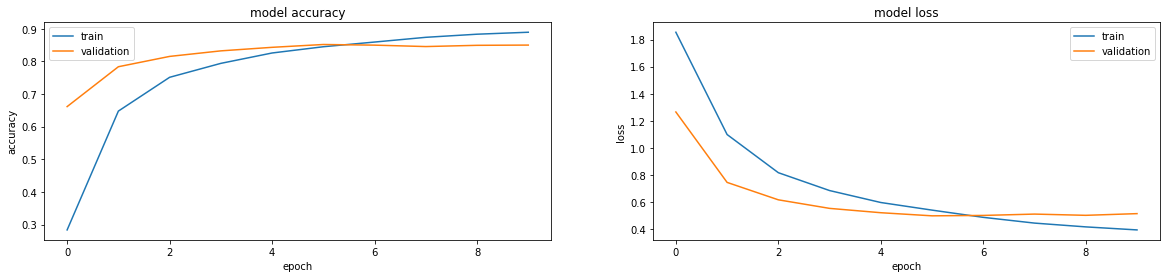

46/46 [==============================] - 0s 10ms/step


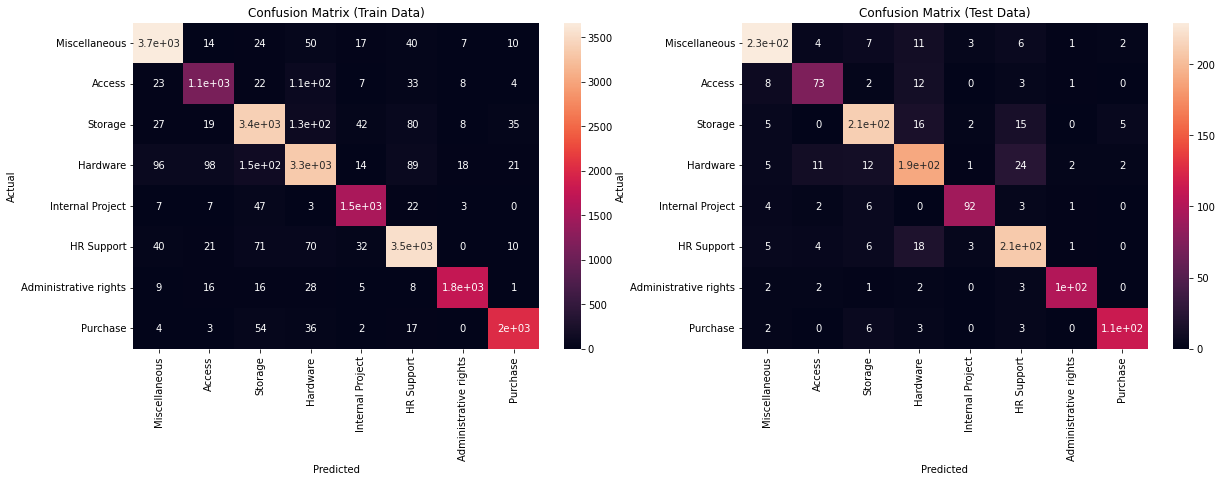

Train Data:
--------------------------------------------------------
                       precision    recall  f1-score   support

        Miscellaneous       0.96      0.95      0.95      3867
               Access       0.85      0.86      0.85      1307
              Storage       0.91      0.90      0.90      3782
             Hardware       0.87      0.89      0.88      3769
     Internal Project       0.95      0.93      0.94      1662
           HR Support       0.94      0.92      0.93      3834
Administrative rights       0.96      0.98      0.97      1812
             Purchase       0.95      0.96      0.95      2098

             accuracy                           0.92     22131
            macro avg       0.92      0.92      0.92     22131
         weighted avg       0.92      0.92      0.92     22131


Test Data:
--------------------------------------------------------
                       precision    recall  f1-score   support

        Miscellaneous       0.87      0

In [ ]:
model_CNN_GRU.load_weights("best_checkpoint_7F_bilstm")

# Evaluate on test data
model_CNN_GRU.evaluate(x=test_text, y=test_labels)

# Display Training History
display_training_loss_and_accuracy(history_spec_model_CNN_GRU)

# Display confusion matrix & classification report
display_classification_confusion_matrix(model_CNN_GRU, train_text, train_labels, test_text, test_labels, unique_categories)

Applying an activation function to the conv1D layer did not appear to improve the model. The test accuracy is lower than in 7E, and variance increased.

## 8. Discussion & Future Work



The best model with a good testing accuracy as well as low varience is Model 7E, with the architecture outlined below.

- SpatialDropout1D(0.2)
- Bidirectional GRU(128, tanh)
- Conv1D(64, kernel_size=3)
- GlobalAveragePooling1D + GlobalMaxPooling1D
- Dense(32, ReLU)
- Dropout (0.5)
- Dense (8, softmax)

Hyperparameters:
- Optimizer: Adam, learning rate = 0.0001
- Batch size: 32
- Epochs: 7

Results:
- Training accuracy: 0.8501
- Validation accuracy: 0.8366
- Testing accuracy: 0.8462


Training curve:

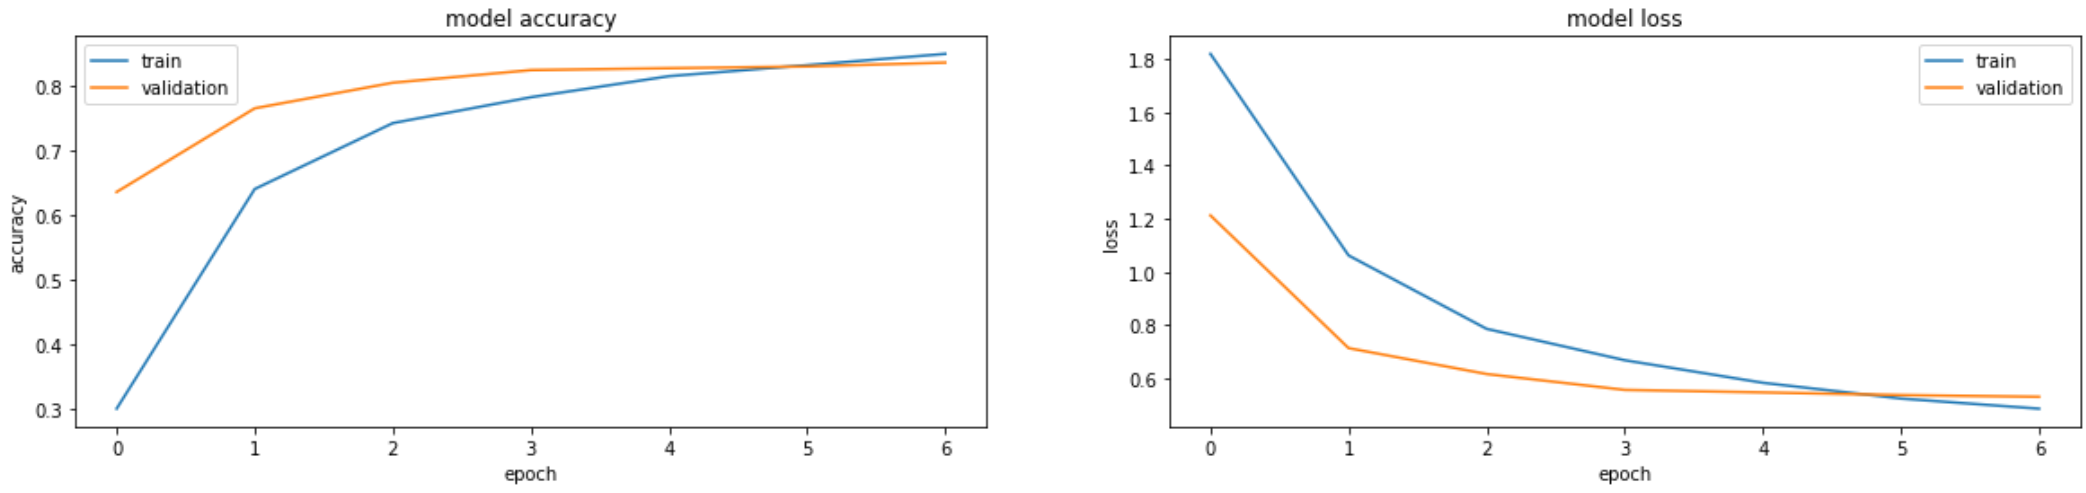

Classification report & Confusion matrix:

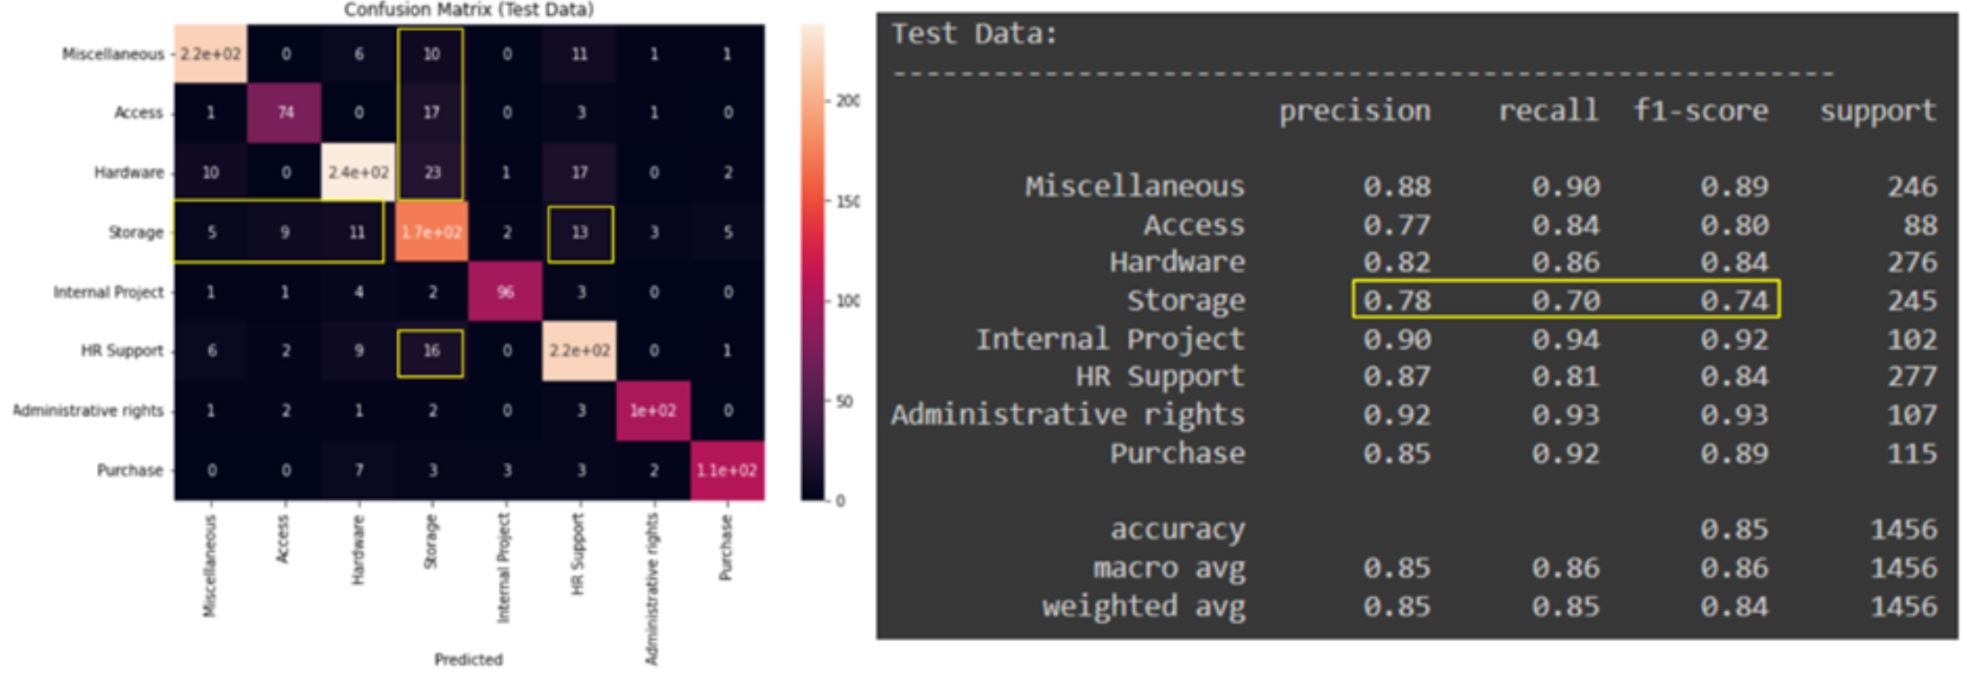

Based on the classification report and confusion matrix of the Bi-GRU+CNN model, the model was generally able to classify tickets accurately as observed with F1-score above 80% for most categories. However, the model performed relatively poorly for tickets of the “Storage” category with a low F1-score of 0.74, often confusing it with other categories especially “HR support”, “Hardware” or “Access”.

To improve on these results, a detailed analysis of the misclassified examples can help identify common patterns or words that are causing the confusion. Based on this information, more sample data may be introduced to training the model to better distinguish between the classes. Apart from that, while the Adam optimizer with learning rate of 0.0001 generally worked well and is useful for text classification, other optimizers such as RMSprop or Adagrad, or varying of hyperparameters such as the learning rate or batch size may also be trialed to find the best combination for this project.
